# Objective

To define supply thresholds based on demand

# Import Packages

In [1]:
import pandas as pd
import glob
import numpy as np

import math
from datetime import datetime

from pyhive import presto

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

# Configs

In [2]:
city = 'Chennai'
service = 'Link'
start_date = '20230710'
end_date = '20230723'

# PATH_TO_ROOT_DIR = '/Users/pallavichandra/commit_repo/lchf_super_clusters/dse-demand-analysis/'
PATH_TO_ROOT_DIR = '/Users/rapido/local-datasets/non-peak-demand/'

# Connection 

In [3]:
# conn = presto.connect(host='prime-trino.serving.data.production.internal',
#                       port=80,
#                       username='pallavi.chandra@rapido.bike')

# conn = presto.connect(host='presto.yoda.run',
#                       port=8080,
#                       username='pallavi.chandra@rapido.bike')


conn  = presto.connect(
    host='presto-gateway.serving.data.production.internal',
    port=80,
    protocol='http',
    catalog='hive',
    username='manoj.ravirajan@rapido.bike'
)

# SQL Queries

In [4]:
fe_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service_name}')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster AS pickup_cluster,
        quarter_hour,
        COUNT(distinct order_id) AS rr_count,
        COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END) AS net_count
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex cls
        ON 
            ols.pickup_location_hex_8 = cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service_name}')
        AND city_name = '{city}'

    GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.quarter_hour,
        fe_count,
        COALESCE(rr_tbl.rr_count,0) AS rr_count,
        COALESCE(rr_tbl.net_count,0) AS net_count
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
),
    
order_stat AS (
    SELECT
        city,
        yyyymmdd,
        orderdate,
        pickup_cluster,
        quarter_hour, 
        SUM(fe_count) AS fe_count,
        SUM(rr_count) AS rr_count,
        SUM(net_count) AS net_count,
        100.0*SUM(rr_count)/SUM(fe_count) AS FE2RR,
        100.0*SUM(net_count)/SUM(rr_count) AS G2N,
        100.0*SUM(net_count)/SUM(fe_count) AS FE2Net
        -- ROUND(SUM(CAST(rr_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE_RR_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(rr_count,0)),4) as G2N_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE2Net_nullif
        
    FROM 
        fe_merged 
    where fe_count > 0 
    and rr_count > 0 
    GROUP BY 
        1,2,3,4,5
)

SELECT * FROM order_stat ORDER BY 1,2,3,4
 
'''.format(
    start_date = start_date,
    end_date = end_date, 
    service_name = service,
    city = city)

In [5]:
print(fe_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Chennai'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '20230710' AND '20230723'
        and 
            fe.city = 'Chennai'
        and 
            service_name IN ('Link')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        o

# Read SQL Queries

In [6]:
#rr_data = pd.read_sql(rr_query, conn)

#rr_data = pd.read_csv('~/Downloads/rr_Hyd_20220905_20221128.csv')

fe_data = pd.read_sql(fe_query, conn)

fe_data

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/2899097727.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fe_data = pd.read_sql(fe_query, conn)


,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net
0,Chennai,20230710,2023-07-10,,1045,23,1,1,4.3,100.0,4.3
1,Chennai,20230710,2023-07-10,,0530,6,1,1,16.7,100.0,16.7
2,Chennai,20230710,2023-07-10,,1715,14,4,4,28.6,100.0,28.6
3,Chennai,20230710,2023-07-10,,1115,7,3,3,42.9,100.0,42.9
4,Chennai,20230710,2023-07-10,,1815,20,4,4,20.0,100.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...
188677,Chennai,20230723,2023-07-23,old Washermanpet,1330,8,3,2,37.5,66.7,25.0
188678,Chennai,20230723,2023-07-23,old Washermanpet,1830,3,1,1,33.3,100.0,33.3
188679,Chennai,20230723,2023-07-23,old Washermanpet,0000,2,1,1,50.0,100.0,50.0
188680,Chennai,20230723,2023-07-23,poonamallee Jaya college,1645,1,1,1,100.0,100.0,100.0


In [7]:
fe_data.to_csv(PATH_TO_ROOT_DIR + 'raw/chennai/fe_data_{}_{}_non_peak_analysis.csv'.format(
    city, service), index = False)

In [8]:
fe_data = pd.read_csv(PATH_TO_ROOT_DIR + 'raw/chennai/fe_data_{}_{}_non_peak_analysis.csv'.format(
    city, service))
fe_data.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net
0,Chennai,20230710,2023-07-10,NaN,1045,23,1,1,4.3,100.0,4.3
1,Chennai,20230710,2023-07-10,NaN,530,6,1,1,16.7,100.0,16.7
2,Chennai,20230710,2023-07-10,NaN,1715,14,4,4,28.6,100.0,28.6
3,Chennai,20230710,2023-07-10,NaN,1115,7,3,3,42.9,100.0,42.9
4,Chennai,20230710,2023-07-10,NaN,1815,20,4,4,20.0,100.0,20.0


## Get time period

In [9]:
def get_period(hour):
    hour = int(hour)
    if (hour >= 8 and hour <= 11):
        return "morning_peak"
    elif (hour >= 17 and hour <= 21):
        return "evening_peak"
    elif (hour > 11 and hour < 17):
        return "afternoon"
    else:
        return "rest"

In [10]:
fe_data['quarter_hour'] = fe_data['quarter_hour'].apply(lambda x: str(x).zfill(4))

fe_data['time_period'] = fe_data['quarter_hour'].apply(
    lambda x: get_period(x[0:2])
)

In [11]:
fe_data['week_period'] = fe_data['yyyymmdd'].map(lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%A')
)

fe_data

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,time_period,week_period
0,Chennai,20230710,2023-07-10,NaN,1045,23,1,1,4.3,100.0,4.3,morning_peak,Monday
1,Chennai,20230710,2023-07-10,NaN,0530,6,1,1,16.7,100.0,16.7,rest,Monday
2,Chennai,20230710,2023-07-10,NaN,1715,14,4,4,28.6,100.0,28.6,evening_peak,Monday
3,Chennai,20230710,2023-07-10,NaN,1115,7,3,3,42.9,100.0,42.9,morning_peak,Monday
4,Chennai,20230710,2023-07-10,NaN,1815,20,4,4,20.0,100.0,20.0,evening_peak,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188677,Chennai,20230723,2023-07-23,old Washermanpet,1330,8,3,2,37.5,66.7,25.0,afternoon,Sunday
188678,Chennai,20230723,2023-07-23,old Washermanpet,1830,3,1,1,33.3,100.0,33.3,evening_peak,Sunday
188679,Chennai,20230723,2023-07-23,old Washermanpet,0000,2,1,1,50.0,100.0,50.0,rest,Sunday
188680,Chennai,20230723,2023-07-23,poonamallee Jaya college,1645,1,1,1,100.0,100.0,100.0,afternoon,Sunday


In [12]:
fe_data_filtered = fe_data[fe_data['time_period'] != 'rest']

In [13]:
fe_data_filtered['yyyymmdd'] = fe_data_filtered['yyyymmdd'].astype(str)
fe_data_filtered['quarter_hour'] = fe_data_filtered['quarter_hour'].astype(str)
fe_data_filtered['pickup_cluster'] = fe_data_filtered['pickup_cluster'].astype(str)

fe_data_filtered = fe_data_filtered.fillna(0)
fe_data_filtered = fe_data_filtered.dropna()

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/3015189938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_data_filtered['yyyymmdd'] = fe_data_filtered['yyyymmdd'].astype(str)
/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/3015189938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_data_filtered['quarter_hour'] = fe_data_filtered['quarter_hour'].astype(str)
/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/3015189938.py:3: SettingWithCopyWarning

In [14]:
fe_data.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,time_period,week_period
0,Chennai,20230710,2023-07-10,NaN,1045,23,1,1,4.3,100.0,4.3,morning_peak,Monday
1,Chennai,20230710,2023-07-10,NaN,0530,6,1,1,16.7,100.0,16.7,rest,Monday
2,Chennai,20230710,2023-07-10,NaN,1715,14,4,4,28.6,100.0,28.6,evening_peak,Monday
3,Chennai,20230710,2023-07-10,NaN,1115,7,3,3,42.9,100.0,42.9,morning_peak,Monday
4,Chennai,20230710,2023-07-10,NaN,1815,20,4,4,20.0,100.0,20.0,evening_peak,Monday


In [15]:
fe_data['quarter_hour'] = fe_data['quarter_hour'].apply(lambda x: str(x).zfill(4))

fe_data['quarter_hour'] = fe_data['quarter_hour'].astype(str)

fe_data['hour'] = fe_data['quarter_hour'].str[0:2]

In [16]:
cluster_temporal_stats = fe_data.groupby(
        ['pickup_cluster', 'hour', 'week_period']).agg(
        total_fe_count=pd.NamedAgg('fe_count', 'sum'),
        total_rr_count=pd.NamedAgg('rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('net_count', 'sum'),
    ).reset_index().sort_values('hour')

In [17]:
cluster_temporal_stats['fe_rr_ratio'] = (
        100 * cluster_temporal_stats['total_rr_count'] / (cluster_temporal_stats['total_fe_count'] + 1)
)

cluster_temporal_stats['g2n_ratio'] = (
        100 * cluster_temporal_stats['total_net_orders'] / (cluster_temporal_stats['total_rr_count'] + 1)
)

In [18]:
cluster_temporal_stats.head()

,pickup_cluster,hour,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio
0,Adambakkam,00,Friday,19,10,5,50.000000,45.454545
29372,Vadapalani Thirunagar,00,Sunday,82,22,16,26.506024,69.565217
29373,Vadapalani Thirunagar,00,Thursday,42,21,14,48.837209,63.636364
29374,Vadapalani Thirunagar,00,Tuesday,43,14,12,31.818182,80.000000
17277,New Vellanur,00,Monday,4,3,0,60.000000,0.000000


In [19]:
fe2rr_below_25_percentile = cluster_temporal_stats[
        cluster_temporal_stats['fe_rr_ratio'] < cluster_temporal_stats['fe_rr_ratio'].quantile(0.25)]


In [20]:
cluster_temporal_stats = fe_data.groupby(
        ['pickup_cluster', 'time_period', 'week_period']).agg(
        total_fe_count=pd.NamedAgg('fe_count', 'sum'),
        total_rr_count=pd.NamedAgg('rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('net_count', 'sum'),
    ).reset_index().sort_values('pickup_cluster')


cluster_temporal_stats.head()

,pickup_cluster,time_period,week_period,total_fe_count,total_rr_count,total_net_orders
0,Adambakkam,afternoon,Friday,1204,290,194
27,Adambakkam,rest,Wednesday,468,171,124
26,Adambakkam,rest,Tuesday,501,183,116
25,Adambakkam,rest,Thursday,698,238,111
24,Adambakkam,rest,Sunday,450,129,93


In [21]:
cluster_temporal_stats['fe_rr_ratio'] = (
        100 * cluster_temporal_stats['total_rr_count'] / (cluster_temporal_stats['total_fe_count'] + 1)
)

cluster_temporal_stats['g2n_ratio'] = (
        100 * cluster_temporal_stats['total_net_orders'] / (cluster_temporal_stats['total_rr_count'] + 1)
)

fe2rr_below_25_percentile = cluster_temporal_stats[
        cluster_temporal_stats['fe_rr_ratio'] < cluster_temporal_stats['fe_rr_ratio'].quantile(0.25)]


In [22]:
lower_quantile_threshold_list = [0.25, 0.20, 0.15, 0.12, 0.1]
higher_quantile_threshold_list = [0.75, 0.80, 0.85, 0.87, 0.9]
temporal_stats_for_threshold = pd.DataFrame({})

In [23]:
## check 
temporal_stats_for_each_threshold = cluster_temporal_stats.groupby(
        ['pickup_cluster', 'time_period']).agg(
        lower_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(0.25)),
        higher_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(0.75)),
        lower_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(0.20)),
        higher_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(0.80))
    ).reset_index()
    
temporal_stats_for_each_threshold.head()

,pickup_cluster,time_period,lower_g2n_threshold,higher_g2n_threshold,lower_fe2rr_threshold,higher_fe2rr_threshold
0,Adambakkam,afternoon,70.314526,74.067164,19.517234,23.884211
1,Adambakkam,evening_peak,73.437118,75.843394,18.132159,26.583157
2,Adambakkam,morning_peak,39.799506,58.195963,21.956587,23.416348
3,Adambakkam,rest,52.823747,68.696060,31.848441,36.043616
4,Adhanur,afternoon,8.333333,23.636364,36.833333,48.144499


In [37]:
temporal_stats_for_threshold = pd.DataFrame()

for i in range(0, len(lower_quantile_threshold_list), 1):
    
    lower_g2n_threshold_str = 'lower_g2n_threshold_' + str(lower_quantile_threshold_list[i])
    higher_g2n_threshold_str = 'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])
    lower_fe2rr_threshold_str = 'lower_fe2rr_threshold_' + str(lower_quantile_threshold_list[i])
    higher_fe2rr_threshold_str = 'higher_fe2rr_threshold_' + str(higher_quantile_threshold_list[i])
    print(lower_quantile_threshold_list[i])

    temporal_stats_for_each_threshold = cluster_temporal_stats.groupby(
        ['pickup_cluster', 'time_period']).agg(
        lower_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(lower_quantile_threshold_list[i])),
        higher_g2n_threshold=pd.NamedAgg('g2n_ratio', lambda x: x.quantile(higher_quantile_threshold_list[i])),
        lower_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(lower_quantile_threshold_list[i])),
        higher_fe2rr_threshold=pd.NamedAgg('fe_rr_ratio', lambda x: x.quantile(higher_quantile_threshold_list[i]))
    ).reset_index()

    temporal_stats_for_each_threshold.rename(
        columns={'lower_g2n_threshold': lower_g2n_threshold_str, 
                 'higher_g2n_threshold': higher_g2n_threshold_str,
                 'lower_fe2rr_threshold': lower_fe2rr_threshold_str,
                 'higher_fe2rr_threshold': higher_fe2rr_threshold_str}, 
        inplace=True)
    
    #print(temporal_stats_for_each_threshold.head())
    
    #temporal_stats_for_threshold = pd.concat([temporal_stats_for_threshold, temporal_stats_for_each_threshold], axis=1)
    
    temporal_stats_for_each_threshold.to_csv( PATH_TO_ROOT_DIR + 'processed/chennai/temporal_stats_for_each_threshold/temporal_stats_for_each_threshold_'+str(
        lower_quantile_threshold_list[i])+'_'+str(higher_quantile_threshold_list[i])+'.csv', index=False)
    
filepath = "/Users/rapido/local-datasets/non-peak-demand/processed/chennai/temporal_stats_for_each_threshold/"
filenames = glob.glob(filepath + "/*.csv")


li = []
for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    
    print(li)

frame = pd.concat(li, axis=1)

        


0.25
0.2
0.15
0.12
0.1
[               pickup_cluster   time_period  lower_g2n_threshold_0.1  \
0                  Adambakkam     afternoon                68.109966   
1                  Adambakkam  evening_peak                72.423712   
2                  Adambakkam  morning_peak                35.108549   
3                  Adambakkam          rest                46.120077   
4                     Adhanur     afternoon                 0.000000   
..                        ...           ...                      ...   
870          old Washermanpet          rest                37.848485   
871  poonamallee Jaya college     afternoon                26.000000   
872  poonamallee Jaya college  evening_peak                27.142857   
873  poonamallee Jaya college  morning_peak                11.111111   
874  poonamallee Jaya college          rest                 0.000000   

     higher_g2n_threshold_0.9  lower_fe2rr_threshold_0.1  \
0                   75.055004                  17.5

In [38]:
frame.describe()

,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,lower_fe2rr_threshold_0.1,higher_fe2rr_threshold_0.9,lower_g2n_threshold_0.12,higher_g2n_threshold_0.87,lower_fe2rr_threshold_0.12,higher_fe2rr_threshold_0.87,lower_g2n_threshold_0.2,higher_g2n_threshold_0.8,lower_fe2rr_threshold_0.2,higher_fe2rr_threshold_0.8,lower_g2n_threshold_0.15,higher_g2n_threshold_0.85,lower_fe2rr_threshold_0.15,higher_fe2rr_threshold_0.85,lower_g2n_threshold_0.25,higher_g2n_threshold_0.75,lower_fe2rr_threshold_0.25,higher_fe2rr_threshold_0.75
count,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000
mean,45.343152,64.403234,22.924527,33.956386,46.069186,63.511511,23.342100,33.428086,48.502044,61.486105,24.869126,32.390898,47.158237,62.917029,23.968459,33.075885,49.604133,60.089714,25.686494,31.805014
std,18.337465,14.437689,6.457241,11.224948,18.307446,14.681157,6.529051,10.847500,18.159242,15.095176,6.735107,10.099796,18.311216,14.875989,6.678819,10.615710,17.943913,15.224371,6.703924,9.636809
min,0.000000,0.000000,6.962242,18.304685,0.000000,0.000000,7.124085,17.963727,0.000000,0.000000,8.836915,17.467273,0.000000,0.000000,7.366851,17.736422,0.000000,0.000000,10.839707,17.347682
25%,35.672152,58.729202,17.673609,25.910313,36.417700,57.725714,18.072094,25.637823,39.361372,55.657529,19.603869,25.114265,37.904906,56.922096,18.698044,25.456807,40.817732,54.073783,20.385731,24.781379
50%,49.434153,68.840832,22.069605,30.831913,50.050186,68.175325,22.582425,30.399412,52.867968,66.268890,23.761011,29.714962,51.242236,67.647059,23.056181,30.193929,54.241897,64.401033,24.547563,29.359748
75%,59.481767,74.202883,27.115015,38.391009,60.145341,73.420548,27.576661,37.744303,62.366760,71.706544,29.034257,36.337129,61.014750,72.992945,28.224474,37.276276,63.091764,70.746361,29.668747,35.913016
max,75.476190,86.646181,50.000000,87.500000,76.404762,86.610623,50.000000,83.750000,78.779473,86.142620,50.000000,75.000000,77.797619,86.586918,50.000000,81.250000,79.091540,85.505804,50.000000,71.250000


In [39]:
frame.head(100)

,pickup_cluster,time_period,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,lower_fe2rr_threshold_0.1,higher_fe2rr_threshold_0.9,pickup_cluster,time_period,lower_g2n_threshold_0.12,higher_g2n_threshold_0.87,...,lower_g2n_threshold_0.15,higher_g2n_threshold_0.85,lower_fe2rr_threshold_0.15,higher_fe2rr_threshold_0.85,pickup_cluster,time_period,lower_g2n_threshold_0.25,higher_g2n_threshold_0.75,lower_fe2rr_threshold_0.25,higher_fe2rr_threshold_0.75
0,Adambakkam,afternoon,68.109966,75.055004,17.567823,24.026556,Adambakkam,afternoon,68.398625,74.862342,...,68.831615,74.733900,18.328898,24.006639,Adambakkam,afternoon,70.314526,74.067164,20.919202,23.710526
1,Adambakkam,evening_peak,72.423712,76.467444,15.736812,27.489526,Adambakkam,evening_peak,72.506122,76.428953,...,72.629738,76.403293,16.374773,27.018974,Adambakkam,evening_peak,73.437118,75.843394,20.449256,26.164707
2,Adambakkam,morning_peak,35.108549,73.684280,19.495067,24.828063,Adambakkam,morning_peak,35.228851,72.053300,...,35.409303,70.965980,21.276051,23.779719,Adambakkam,morning_peak,39.799506,58.195963,22.086899,23.395463
3,Adambakkam,rest,46.120077,71.760286,30.519143,36.456732,Adambakkam,rest,46.217108,71.660465,...,46.362655,71.593918,31.477163,36.454820,Adambakkam,rest,52.823747,68.696060,31.926348,35.427766
4,Adhanur,afternoon,0.000000,27.792208,36.285714,48.965517,Adhanur,afternoon,0.000000,27.558442,...,0.000000,27.402597,36.571429,48.448276,Adhanur,afternoon,8.333333,23.636364,37.083333,47.947455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Ayapakkam,rest,9.523810,36.000000,33.766938,51.538462,Ayapakkam,rest,10.000000,34.800000,...,10.714286,34.000000,39.539295,50.384615,Ayapakkam,rest,16.666667,32.291667,43.145500,49.193548
96,Ayapakkam 2,afternoon,58.082310,72.993902,15.421921,29.190359,Ayapakkam 2,afternoon,58.130144,72.209146,...,58.201896,71.685976,16.334258,28.516077,Ayapakkam 2,afternoon,58.247093,67.443182,20.336989,27.380952
97,Ayapakkam 2,evening_peak,61.258093,83.794101,14.379333,28.086133,Ayapakkam 2,evening_peak,62.117306,83.669173,...,63.406126,83.585888,15.456147,27.777347,Ayapakkam 2,evening_peak,65.039792,76.341575,19.629154,26.995104
98,Ayapakkam 2,morning_peak,57.666995,78.334311,21.387460,30.340608,Ayapakkam 2,morning_peak,59.052611,76.470968,...,61.131034,75.228739,22.485230,30.007833,Ayapakkam 2,morning_peak,66.340226,73.266987,25.151067,29.356442


In [40]:
frame.columns

Index(['pickup_cluster', 'time_period', 'lower_g2n_threshold_0.1',
       'higher_g2n_threshold_0.9', 'lower_fe2rr_threshold_0.1',
       'higher_fe2rr_threshold_0.9', 'pickup_cluster', 'time_period',
       'lower_g2n_threshold_0.12', 'higher_g2n_threshold_0.87',
       'lower_fe2rr_threshold_0.12', 'higher_fe2rr_threshold_0.87',
       'pickup_cluster', 'time_period', 'lower_g2n_threshold_0.2',
       'higher_g2n_threshold_0.8', 'lower_fe2rr_threshold_0.2',
       'higher_fe2rr_threshold_0.8', 'pickup_cluster', 'time_period',
       'lower_g2n_threshold_0.15', 'higher_g2n_threshold_0.85',
       'lower_fe2rr_threshold_0.15', 'higher_fe2rr_threshold_0.85',
       'pickup_cluster', 'time_period', 'lower_g2n_threshold_0.25',
       'higher_g2n_threshold_0.75', 'lower_fe2rr_threshold_0.25',
       'higher_fe2rr_threshold_0.75'],
      dtype='object')

In [41]:
temporal_stats_for_threshold = frame.copy()

temporal_stats_for_threshold_filtered = temporal_stats_for_threshold[[
    'pickup_cluster','time_period','lower_g2n_threshold_0.1','higher_g2n_threshold_0.9',
    'lower_fe2rr_threshold_0.1','higher_fe2rr_threshold_0.9',
    'lower_g2n_threshold_0.12','higher_g2n_threshold_0.87','lower_fe2rr_threshold_0.12',
    'higher_fe2rr_threshold_0.87','lower_g2n_threshold_0.2','higher_g2n_threshold_0.8',
    'lower_fe2rr_threshold_0.2','higher_fe2rr_threshold_0.8','lower_g2n_threshold_0.15',
    'higher_g2n_threshold_0.85','lower_fe2rr_threshold_0.15','higher_fe2rr_threshold_0.85',
    'lower_g2n_threshold_0.25','higher_g2n_threshold_0.75','lower_fe2rr_threshold_0.25',
    'higher_fe2rr_threshold_0.75']]

temporal_stats_for_threshold_filtered.head()

,pickup_cluster,pickup_cluster,pickup_cluster,pickup_cluster,pickup_cluster,time_period,time_period,time_period,time_period,time_period,...,lower_fe2rr_threshold_0.2,higher_fe2rr_threshold_0.8,lower_g2n_threshold_0.15,higher_g2n_threshold_0.85,lower_fe2rr_threshold_0.15,higher_fe2rr_threshold_0.85,lower_g2n_threshold_0.25,higher_g2n_threshold_0.75,lower_fe2rr_threshold_0.25,higher_fe2rr_threshold_0.75
0,Adambakkam,Adambakkam,Adambakkam,Adambakkam,Adambakkam,afternoon,afternoon,afternoon,afternoon,afternoon,...,19.517234,23.884211,68.831615,74.733900,18.328898,24.006639,70.314526,74.067164,20.919202,23.710526
1,Adambakkam,Adambakkam,Adambakkam,Adambakkam,Adambakkam,evening_peak,evening_peak,evening_peak,evening_peak,evening_peak,...,18.132159,26.583157,72.629738,76.403293,16.374773,27.018974,73.437118,75.843394,20.449256,26.164707
2,Adambakkam,Adambakkam,Adambakkam,Adambakkam,Adambakkam,morning_peak,morning_peak,morning_peak,morning_peak,morning_peak,...,21.956587,23.416348,35.409303,70.965980,21.276051,23.779719,39.799506,58.195963,22.086899,23.395463
3,Adambakkam,Adambakkam,Adambakkam,Adambakkam,Adambakkam,rest,rest,rest,rest,rest,...,31.848441,36.043616,46.362655,71.593918,31.477163,36.454820,52.823747,68.696060,31.926348,35.427766
4,Adhanur,Adhanur,Adhanur,Adhanur,Adhanur,afternoon,afternoon,afternoon,afternoon,afternoon,...,36.833333,48.144499,0.000000,27.402597,36.571429,48.448276,8.333333,23.636364,37.083333,47.947455


In [42]:
# drop duplicate column names
temporal_stats_for_threshold_filtered2 = temporal_stats_for_threshold_filtered.T.drop_duplicates().T

temporal_stats_for_threshold_filtered2.head()

,pickup_cluster,time_period,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,lower_fe2rr_threshold_0.1,higher_fe2rr_threshold_0.9,lower_g2n_threshold_0.12,higher_g2n_threshold_0.87,lower_fe2rr_threshold_0.12,higher_fe2rr_threshold_0.87,...,lower_fe2rr_threshold_0.2,higher_fe2rr_threshold_0.8,lower_g2n_threshold_0.15,higher_g2n_threshold_0.85,lower_fe2rr_threshold_0.15,higher_fe2rr_threshold_0.85,lower_g2n_threshold_0.25,higher_g2n_threshold_0.75,lower_fe2rr_threshold_0.25,higher_fe2rr_threshold_0.75
0,Adambakkam,afternoon,68.109966,75.055004,17.567823,24.026556,68.398625,74.862342,17.872253,24.014606,...,19.517234,23.884211,68.831615,74.7339,18.328898,24.006639,70.314526,74.067164,20.919202,23.710526
1,Adambakkam,evening_peak,72.423712,76.467444,15.736812,27.489526,72.506122,76.428953,15.991996,27.207195,...,18.132159,26.583157,72.629738,76.403293,16.374773,27.018974,73.437118,75.843394,20.449256,26.164707
2,Adambakkam,morning_peak,35.108549,73.68428,19.495067,24.828063,35.228851,72.0533,20.20746,24.199056,...,21.956587,23.416348,35.409303,70.96598,21.276051,23.779719,39.799506,58.195963,22.086899,23.395463
3,Adambakkam,rest,46.120077,71.760286,30.519143,36.456732,46.217108,71.660465,30.902351,36.455585,...,31.848441,36.043616,46.362655,71.593918,31.477163,36.45482,52.823747,68.69606,31.926348,35.427766
4,Adhanur,afternoon,0.0,27.792208,36.285714,48.965517,0.0,27.558442,36.4,48.655172,...,36.833333,48.144499,0.0,27.402597,36.571429,48.448276,8.333333,23.636364,37.083333,47.947455


In [43]:
cluster_temporal_stats_with_threshold = pd.merge(
    cluster_temporal_stats, temporal_stats_for_threshold_filtered2, left_on = [
    'pickup_cluster', 'time_period'], right_on = [
    'pickup_cluster', 'time_period'], how = 'left')

cluster_temporal_stats_with_threshold.head()

,pickup_cluster,time_period,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,lower_fe2rr_threshold_0.2,higher_fe2rr_threshold_0.8,lower_g2n_threshold_0.15,higher_g2n_threshold_0.85,lower_fe2rr_threshold_0.15,higher_fe2rr_threshold_0.85,lower_g2n_threshold_0.25,higher_g2n_threshold_0.75,lower_fe2rr_threshold_0.25,higher_fe2rr_threshold_0.75
0,Adambakkam,afternoon,Friday,1204,290,194,24.066390,66.666667,68.109966,75.055004,...,19.517234,23.884211,68.831615,74.7339,18.328898,24.006639,70.314526,74.067164,20.919202,23.710526
1,Adambakkam,rest,Wednesday,468,171,124,36.460554,72.093023,46.120077,71.760286,...,31.848441,36.043616,46.362655,71.593918,31.477163,36.45482,52.823747,68.69606,31.926348,35.427766
2,Adambakkam,rest,Tuesday,501,183,116,36.454183,63.043478,46.120077,71.760286,...,31.848441,36.043616,46.362655,71.593918,31.477163,36.45482,52.823747,68.69606,31.926348,35.427766
3,Adambakkam,rest,Thursday,698,238,111,34.048641,46.443515,46.120077,71.760286,...,31.848441,36.043616,46.362655,71.593918,31.477163,36.45482,52.823747,68.69606,31.926348,35.427766
4,Adambakkam,rest,Sunday,450,129,93,28.603104,71.538462,46.120077,71.760286,...,31.848441,36.043616,46.362655,71.593918,31.477163,36.45482,52.823747,68.69606,31.926348,35.427766


In [44]:
cluster_temporal_stats_with_threshold.shape, cluster_temporal_stats.shape

((6067, 28), (6067, 8))

In [45]:
px.box(y = cluster_temporal_stats_with_threshold['fe_rr_ratio'])

In [46]:
px.box(y = cluster_temporal_stats_with_threshold['g2n_ratio'])

## Conclusion

We have list of thresholds that are at cluster, week_period, time_period level. 

In [47]:
lower_quantile_threshold_list, higher_quantile_threshold_list

([0.25, 0.2, 0.15, 0.12, 0.1], [0.75, 0.8, 0.85, 0.87, 0.9])

In [48]:
    for i in range(0, len(lower_quantile_threshold_list), 1):
        conversion_category_str = 'conversion_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
            higher_quantile_threshold_list[i])
        fulfilment_category_str = 'fulfil_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
            higher_quantile_threshold_list[i])

        cluster_temporal_stats_with_threshold.loc[
            cluster_temporal_stats_with_threshold['fe_rr_ratio'] < cluster_temporal_stats_with_threshold[
                'lower_fe2rr_threshold_' + str(lower_quantile_threshold_list[i])], conversion_category_str] = 'low'

        cluster_temporal_stats_with_threshold.loc[(cluster_temporal_stats_with_threshold.fe_rr_ratio) > (
            cluster_temporal_stats_with_threshold[
                'higher_fe2rr_threshold_' + str(higher_quantile_threshold_list[i])]), conversion_category_str] = 'high'

        cluster_temporal_stats_with_threshold.loc[((cluster_temporal_stats_with_threshold.fe_rr_ratio) <= (
            cluster_temporal_stats_with_threshold[
                'higher_fe2rr_threshold_' + str(higher_quantile_threshold_list[i])])) & ((
                (cluster_temporal_stats_with_threshold.fe_rr_ratio) >= (
            cluster_temporal_stats_with_threshold[
                'lower_fe2rr_threshold_' + str(
                    lower_quantile_threshold_list[i])]))), conversion_category_str] = 'medium'

        cluster_temporal_stats_with_threshold.loc[(cluster_temporal_stats_with_threshold.g2n_ratio) < (
            cluster_temporal_stats_with_threshold[
                'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])]), fulfilment_category_str] = 'low'

        cluster_temporal_stats_with_threshold.loc[(cluster_temporal_stats_with_threshold.g2n_ratio) > (
            cluster_temporal_stats_with_threshold[
                'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])]), fulfilment_category_str] = 'high'

        cluster_temporal_stats_with_threshold.loc[((cluster_temporal_stats_with_threshold.g2n_ratio) <= (
            cluster_temporal_stats_with_threshold[
                'higher_g2n_threshold_' + str(higher_quantile_threshold_list[i])])) & (
                                                      ((cluster_temporal_stats_with_threshold.g2n_ratio) >= (
                                                          cluster_temporal_stats_with_threshold[
                                                              'lower_g2n_threshold_' + str(
                                                                  lower_quantile_threshold_list[
                                                                      i])]))), fulfilment_category_str] = 'medium'

        cluster_temporal_stats_with_threshold['cf_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
            higher_quantile_threshold_list[i])] = (
                cluster_temporal_stats_with_threshold[
                    'conversion_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
                        higher_quantile_threshold_list[i])] + '-' +
                cluster_temporal_stats_with_threshold[
                    'fulfil_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
                        higher_quantile_threshold_list[i])]
        )
        print(cluster_temporal_stats_with_threshold.shape)
        print(cluster_temporal_stats_with_threshold[conversion_category_str].value_counts())
        print(cluster_temporal_stats_with_threshold[fulfilment_category_str].value_counts())
        print('----------------------')


(6067, 31)
medium    2611
low       1730
high      1726
Name: conversion_category_0.25_0.75, dtype: int64
medium    2679
high      1702
low       1686
Name: fulfil_category_0.25_0.75, dtype: int64
----------------------
(6067, 34)
medium    2642
low       1715
high      1710
Name: conversion_category_0.2_0.8, dtype: int64
medium    2706
high      1688
low       1673
Name: fulfil_category_0.2_0.8, dtype: int64
----------------------
(6067, 37)
medium    4334
high       868
low        865
Name: conversion_category_0.15_0.85, dtype: int64
medium    4384
high       847
low        836
Name: fulfil_category_0.15_0.85, dtype: int64
----------------------
(6067, 40)
medium    4334
high       868
low        865
Name: conversion_category_0.12_0.87, dtype: int64
medium    4384
high       847
low        836
Name: fulfil_category_0.12_0.87, dtype: int64
----------------------
(6067, 43)
medium    4334
high       868
low        865
Name: conversion_category_0.1_0.9, dtype: int64
medium    4384
high 

In [49]:
cluster_temporal_stats_with_threshold.head()

,pickup_cluster,time_period,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,cf_category_0.2_0.8,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9
0,Adambakkam,afternoon,Friday,1204,290,194,24.066390,66.666667,68.109966,75.055004,...,high-low,high,low,high-low,high,low,high-low,high,low,high-low
1,Adambakkam,rest,Wednesday,468,171,124,36.460554,72.093023,46.120077,71.760286,...,high-high,high,high,high-high,high,high,high-high,high,high,high-high
2,Adambakkam,rest,Tuesday,501,183,116,36.454183,63.043478,46.120077,71.760286,...,high-medium,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium
3,Adambakkam,rest,Thursday,698,238,111,34.048641,46.443515,46.120077,71.760286,...,medium-low,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium
4,Adambakkam,rest,Sunday,450,129,93,28.603104,71.538462,46.120077,71.760286,...,low-high,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium


In [50]:
cluster_temporal_stats_with_threshold.to_csv(
    '/Users/rapido/local-datasets/non-peak-demand/processed/chennai/cluster_temporal_stats_with_threshold_cf_category_{}_{}_{}_{}.csv'.format(
        city, service, start_date, end_date))

## Conclusion

Categories created

In [51]:
for i in range(0, len(lower_quantile_threshold_list), 1):
    conversion_category_str = 'conversion_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])
    fulfilment_category_str = 'fulfil_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])
    cf_category_str = 'cf_category_' + str(lower_quantile_threshold_list[i]) + '_' + str(
        higher_quantile_threshold_list[i])

    category_wise_stats = cluster_temporal_stats_with_threshold.groupby(
        [cf_category_str, conversion_category_str, fulfilment_category_str]).agg(
        total_gross_orders=pd.NamedAgg('total_rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('total_net_orders', 'sum'),
        total_fe_count=pd.NamedAgg('total_fe_count', 'sum')
    ).reset_index()

    print('Total Unique Clusters: ', cluster_temporal_stats_with_threshold.pickup_cluster.nunique())
    print(cluster_temporal_stats_with_threshold.pickup_cluster.nunique())

    print('Check count: time period level')
    print(cluster_temporal_stats_with_threshold.groupby([cf_category_str, 'time_period']).agg(
        count_combinations=pd.NamedAgg('pickup_cluster', 'count')))
    
    print('Unique Clusters ')
    print(cluster_temporal_stats_with_threshold.groupby([cf_category_str, 'time_period']).agg(
        unique_clusters=pd.NamedAgg('pickup_cluster', lambda x: x.nunique())))
    

    print('Check count: time period, week period level')
    print(cluster_temporal_stats_with_threshold.groupby([cf_category_str, 'time_period', 'week_period']).agg(
        count_combinations=pd.NamedAgg('pickup_cluster', 'count')))

    print('Category Wise Stats')
    print('-----------------------------------')
    print(category_wise_stats.shape)
    print(category_wise_stats[conversion_category_str].value_counts())
    print(category_wise_stats[fulfilment_category_str].value_counts())

    total_gross_orders_all_cats = category_wise_stats['total_gross_orders'].sum()
    total_net_orders_all_cats = category_wise_stats['total_net_orders'].sum()
    total_fe_count_all_cats = category_wise_stats['total_fe_count'].sum()

    print('Gross orders Summary')
    print('Total Gross Orders: ', total_gross_orders_all_cats)
    print('Total Net Orders: ', total_net_orders_all_cats)
    print('Total FE count: ', total_fe_count_all_cats)
    print('------------------------------------------------')

    # Put in log
    category_wise_stats['fe_contribution'] = category_wise_stats['total_fe_count'] / total_fe_count_all_cats
    category_wise_stats['gross_order_contribution'] = category_wise_stats[
                                                          'total_gross_orders'] / total_gross_orders_all_cats
    category_wise_stats['net_order_contribution'] = category_wise_stats[
                                                        'total_net_orders'] / total_net_orders_all_cats

    category_wise_stats.to_csv(
        '/Users/rapido/local-datasets/non-peak-demand/processed/chennai/category_ws_stats/category_wise_stats_'+str(
        lower_quantile_threshold_list[i])+'_'+str(higher_quantile_threshold_list[i])+'.csv', index=False)
    
filepath = "/Users/rapido/local-datasets/non-peak-demand/processed/chennai/category_ws_stats/"
filenames = glob.glob(filepath + "/*.csv")


category_ws_file_list = []
for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    category_ws_file_list.append(df)
    
    print(category_ws_file_list)

category_ws_stats = pd.concat(category_ws_file_list, axis=1)

#     print('Gross orders Contribution Summary')
#     print('Gross Order Contribution: ', total_gross_orders_all_cats)
#     print('Net Orders Contribution: ', total_net_orders_all_cats)
#     print('FE Contribution: ', total_fe_count_all_cats)
#     print('------------------------------------------------')

Total Unique Clusters:  219
219
Check count: time period level
                                    count_combinations
cf_category_0.25_0.75 time_period                     
high-high             afternoon                    101
                      evening_peak                 162
                      morning_peak                  54
                      rest                         145
high-low              afternoon                    135
                      evening_peak                  64
                      morning_peak                 159
                      rest                         101
high-medium           afternoon                    196
                      evening_peak                 207
                      morning_peak                 218
                      rest                         184
low-high              afternoon                    140
                      evening_peak                  66
                      morning_peak                 236
  

[  cf_category_0.12_0.87 conversion_category_0.12_0.87  \
0             high-high                          high   
1              high-low                          high   
2           high-medium                          high   
3              low-high                           low   
4               low-low                           low   
5            low-medium                           low   
6           medium-high                        medium   
7            medium-low                        medium   
8         medium-medium                        medium   

  fulfil_category_0.12_0.87  total_gross_orders  total_net_orders  \
0                      high               21946             16132   
1                       low               23069              9997   
2                    medium              157834            100326   
3                      high               33099             24497   
4                       low               35037             20958   
5             

In [52]:
category_wise_stats.head()

,cf_category_0.1_0.9,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,total_gross_orders,total_net_orders,total_fe_count,fe_contribution,gross_order_contribution,net_order_contribution
0,high-high,high,high,21946,16132,76977,0.013807,0.016480,0.019454
1,high-low,high,low,23069,9997,82582,0.014812,0.017323,0.012056
2,high-medium,high,medium,157834,100326,563718,0.101108,0.118522,0.120987
3,low-high,low,high,33099,24497,183087,0.032838,0.024855,0.029542
4,low-low,low,low,35037,20958,229752,0.041208,0.026310,0.025274


In [53]:
category_ws_stats.head()

,cf_category_0.12_0.87,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,total_gross_orders,total_net_orders,total_fe_count,fe_contribution,gross_order_contribution,net_order_contribution,cf_category_0.2_0.8,...,net_order_contribution,cf_category_0.15_0.85,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,total_gross_orders,total_net_orders,total_fe_count,fe_contribution,gross_order_contribution,net_order_contribution
0,high-high,high,high,21946,16132,76977,0.013807,0.016480,0.019454,high-high,...,0.019454,high-high,high,high,21946,16132,76977,0.013807,0.016480,0.019454
1,high-low,high,low,23069,9997,82582,0.014812,0.017323,0.012056,high-low,...,0.012056,high-low,high,low,23069,9997,82582,0.014812,0.017323,0.012056
2,high-medium,high,medium,157834,100326,563718,0.101108,0.118522,0.120987,high-medium,...,0.120987,high-medium,high,medium,157834,100326,563718,0.101108,0.118522,0.120987
3,low-high,low,high,33099,24497,183087,0.032838,0.024855,0.029542,low-high,...,0.029542,low-high,low,high,33099,24497,183087,0.032838,0.024855,0.029542
4,low-low,low,low,35037,20958,229752,0.041208,0.026310,0.025274,low-low,...,0.025274,low-low,low,low,35037,20958,229752,0.041208,0.026310,0.025274


In [54]:
lh_segments = cluster_temporal_stats_with_threshold[(cluster_temporal_stats_with_threshold[
    'cf_category_0.25_0.75'] == 'low-high') & (cluster_temporal_stats_with_threshold[
    'time_period'] == 'afternoon')]

lh_segments.head()

,pickup_cluster,time_period,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,cf_category_0.2_0.8,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9
101,Air Force Station,afternoon,Sunday,1637,224,170,13.675214,75.555556,67.142064,72.983416,...,low-high,low,high,low-high,low,high,low-high,low,high,low-high
211,Alwarpet,afternoon,Sunday,1366,273,212,19.970739,77.372263,67.846148,78.382121,...,low-high,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium
242,Alwarthirunagar,afternoon,Sunday,859,124,76,14.418605,60.800000,38.169526,62.931613,...,low-high,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium
266,Ambattur,afternoon,Saturday,1637,301,224,18.376068,74.172185,66.576732,73.013356,...,low-high,medium,high,medium-high,medium,high,medium-high,medium,high,medium-high
324,Ambattur OT,afternoon,Sunday,742,115,84,15.477793,72.413793,64.115442,72.604902,...,low-high,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium


In [44]:
cluster_temporal_stats_with_threshold.head()

,pickup_cluster,time_period,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,cf_category_0.2_0.8,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9
0,Adambakkam,afternoon,Friday,1204,290,194,24.066390,66.666667,68.11,75.055,...,high-low,high,low,high-low,high,low,high-low,high,low,high-low
1,Adambakkam,rest,Wednesday,468,171,124,36.460554,72.093023,46.1201,71.7603,...,high-high,high,high,high-high,high,high,high-high,high,high,high-high
2,Adambakkam,rest,Tuesday,501,183,116,36.454183,63.043478,46.1201,71.7603,...,high-medium,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium
3,Adambakkam,rest,Thursday,698,238,111,34.048641,46.443515,46.1201,71.7603,...,medium-low,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium
4,Adambakkam,rest,Sunday,450,129,93,28.603104,71.538462,46.1201,71.7603,...,low-high,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium


In [55]:
lh_segments.to_csv('/Users/rapido/local-datasets/non-peak-demand/processed/chennai/lh/lh_segments_{}_{}_{}_{}.csv'.format(
    city, 
    service, 
    start_date, 
    end_date))

In [56]:
lh_segments.pickup_cluster.nunique()

123

---

## Defining supply thresholds

In [57]:
cluster_temporal_stats_hour_level = fe_data.groupby(
        ['pickup_cluster', 'hour', 'week_period']).agg(
        total_fe_count=pd.NamedAgg('fe_count', 'sum'),
        total_rr_count=pd.NamedAgg('rr_count', 'sum'),
        total_net_orders=pd.NamedAgg('net_count', 'sum'),
    ).reset_index().sort_values('hour')


cluster_temporal_stats_hour_level['fe_rr_ratio'] = (
        100 * cluster_temporal_stats_hour_level['total_rr_count'] / (cluster_temporal_stats_hour_level['total_fe_count'] + 1)
)

cluster_temporal_stats_hour_level['g2n_ratio'] = (
        100 * cluster_temporal_stats_hour_level['total_net_orders'] / (cluster_temporal_stats_hour_level['total_rr_count'] + 1)
)

## Mismatch query

to get demand and supply

In [58]:
mismatch_g2n_query = '''
    WITH counts AS (
        WITH orders AS (
            SELECT ols.service_detail_id,
                   ols.yyyymmdd,
                   ols.quarter_hour,
                   ols.pickup_location_hex_8                                                         hex_id,
                   ols.service_obj_service_name                                                     service_level, 
                   COUNT(DISTINCT (ols.customer_id))                                                 gross_orders,
                   COUNT(DISTINCT (CASE WHEN ols.order_status = 'dropped' THEN ols.customer_id END)) net_orders,
                   AVG(distance_final_distance)                                                     mean_distance
            FROM hive.orders.order_logs_snapshot ols
            WHERE ols.yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
              AND ols.service_obj_service_name = '{service}'
              AND city_name = '{city}'
            GROUP BY 1, 2, 3, 4, 5
            ORDER BY 1, 2, 3, 4, 5
        ),
             mismatch AS (
                 SELECT nm.service_detail_id, 
                        nm.yyyymmdd,
                        nm.quarter_hour,
                        nm.hex_id,
                        service_level,
                        nm.rr_counts           as demand,
                        nm.idle_captain_counts_probabilistic as supply
                 FROM hive.datasets.marketplace_mismatch_realtime nm
                          JOIN datasets.city_cluster_hex cch ON cch.hex_id = nm.hex_id
                     AND cch.city = '{city}'
                 WHERE yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
                   AND service_level = '{service}'
             )
        SELECT
               CASE WHEN m.service_detail_id IS NOT NULL THEN m.service_detail_id ELSE o.service_detail_id END service_detail_id,
               CASE WHEN m.yyyymmdd IS NOT NULL THEN m.yyyymmdd ELSE o.yyyymmdd END             yyyymmdd,
               CASE WHEN m.quarter_hour IS NOT NULL THEN m.quarter_hour ELSE o.quarter_hour END quarter_hour,
               CASE WHEN m.hex_id IS NOT NULL THEN m.hex_id ELSE o.hex_id END                   hex_id,
               CASE WHEN o.gross_orders IS NOT NULL THEN o.gross_orders ELSE 0 END              gross_orders,
               CASE WHEN o.net_orders IS NOT NULL THEN o.net_orders ELSE 0 END                  net_orders,
               CASE WHEN o.mean_distance IS NOT NULL THEN o.mean_distance ELSE 0 END            mean_distance,
               CASE WHEN m.demand IS NOT NULL THEN m.demand ELSE 0 END                          demand,
               CASE WHEN m.supply IS NOT NULL THEN m.supply ELSE 0 END                          supply
        FROM orders o
                 FULL OUTER JOIN mismatch m ON o.service_detail_id = m.service_detail_id
            AND o.yyyymmdd = m.yyyymmdd
            AND o.quarter_hour = m.quarter_hour
            AND o.hex_id = m.hex_id
            AND o.service_level = m.service_level
    )

    SELECT * from counts
    '''.format(
        city=city,
        start_date=start_date,
        end_date=end_date,
        service=service
    )

print(mismatch_g2n_query)


    WITH counts AS (
        WITH orders AS (
            SELECT ols.service_detail_id,
                   ols.yyyymmdd,
                   ols.quarter_hour,
                   ols.pickup_location_hex_8                                                         hex_id,
                   ols.service_obj_service_name                                                     service_level, 
                   COUNT(DISTINCT (ols.customer_id))                                                 gross_orders,
                   COUNT(DISTINCT (CASE WHEN ols.order_status = 'dropped' THEN ols.customer_id END)) net_orders,
                   AVG(distance_final_distance)                                                     mean_distance
            FROM hive.orders.order_logs_snapshot ols
            WHERE ols.yyyymmdd BETWEEN '20230710' AND '20230723'
              AND ols.service_obj_service_name = 'Link'
              AND city_name = 'Chennai'
            GROUP BY 1, 2, 3, 4, 5
            ORDER BY 1, 2

In [59]:
def get_cluster_hex_mapping(city):
    print('Downloading Cluster Hex Mapping')
    
    cluster_hex_query = """

        SELECT
            cluster,
            hex_id,
            executiondate
        FROM 
            datasets.city_cluster_hex
        WHERE
            city = '{city}'
            AND resolution = 8

        """.format(
        city=city)

    cluster_hex_mapping = pd.read_sql(cluster_hex_query, conn)
    print('----------------------------------------')
    print('Cluster Hex Mapping Download Completed!')
    print('----------------------------------------')
    max_date = cluster_hex_mapping['executiondate'].max()
    cluster_hex_mapping = cluster_hex_mapping[cluster_hex_mapping['executiondate'] == max_date]
    cluster_hex_mapping = cluster_hex_mapping[['cluster', 'hex_id']]

    return cluster_hex_mapping

In [60]:
mismatch_g2n_df = pd.read_sql(mismatch_g2n_query, conn)

    
cluster_hex_mapping = get_cluster_hex_mapping(city)

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/962947382.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/50432231.py:19: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



----------------------------------------
Cluster Hex Mapping Download Completed!
----------------------------------------


In [61]:
mismatch_g2n_df.head()

,service_detail_id,yyyymmdd,quarter_hour,hex_id,gross_orders,net_orders,mean_distance,demand,supply
0,5bed473f1278885df4ea9d57,20230712,0915,88618c48a5fffff,3,2,10.666667,2.0,0.0
1,5bed473f1278885df4ea9d57,20230712,0915,88618c48d7fffff,3,3,2.378000,11.0,2.0
2,5bed473f1278885df4ea9d57,20230712,0915,88618c4c2bfffff,8,6,6.365727,9.0,1.0
3,5bed473f1278885df4ea9d57,20230712,0915,88618c4c6dfffff,9,6,3.635500,7.0,0.0
4,5bed473f1278885df4ea9d57,20230712,0915,88618c4c85fffff,1,1,0.636000,0.0,0.0


In [62]:
mismatch_g2n_df.service_detail_id.unique()

array(['5bed473f1278885df4ea9d57', '5a6b23eb5cecc70e41e35ae9',
       '5a6b23be5cecc70e41e35ad9', '57370b61a6855d70057417d1',
       '5f74dc7cc398e30007564335', '5a6b23db5cecc70e41e35ae1',
       '5a6b238b5cecc70e41e35ac9', '5c124a1e0241913903a42fe1',
       '5c44cea15d1879714b1feea4', '5ccae81aa4f9131cc587c097',
       '5c74d7b56b1a155d29143f18', '5da4660028af187d8d52cc3c',
       '5ab38dd30b74f15b1984ee09', '5c4e93f7701fff4555c48b78',
       '5c04f8eec922ad49db3b5ec2', '574013f14fdf4798208bba26',
       '5aacda8bdd58db2b11598d0b', '5c1248861df8ae37a7d45ef3',
       '5c45c980cae89c13aa108745', '5a6b23725cecc70e41e35ac1',
       '5c30996565063a53a4c4e785', '5b18fd2d1fbf2d58a37dfe08',
       '5c12485d0241913903a42fc2', '5c7594734666ec5e4fe61294',
       '5c7524194666ec5e4fe6126c', '5c752e21fba15d394998d6f6',
       '6102cf4a57bbccea008efa58', '5d440cf9b49917181c158a6c',
       '5c7594f94666ec5e4fe612a8', '5ba1f6d0be5b826084cc7202'],
      dtype=object)

In [63]:


mismatch_g2n_df.to_csv(
    '/Users/rapido/local-datasets/non-peak-demand/processed/chennai/mismatch_g2n_df_{}_{}_{}_{}.csv'.format(
        city, 
        service, 
        start_date, 
        end_date))

cluster_hex_mapping.to_csv(
    '/Users/rapido/local-datasets/non-peak-demand/processed/chennai/cluster_hex_mapping_{}_{}_{}_{}.csv'.format(
        city, 
        service, 
        start_date, 
        end_date))



In [64]:
mismatch_g2n_df = pd.read_csv(
    '/Users/rapido/local-datasets/non-peak-demand/processed/chennai/mismatch_g2n_df_{}_{}_{}_{}.csv'.format(
        city, 
        service, 
        start_date, 
        end_date))

cluster_hex_mapping = pd.read_csv(
    '/Users/rapido/local-datasets/non-peak-demand/processed/chennai/cluster_hex_mapping_{}_{}_{}_{}.csv'.format(
        city, 
        service, 
        start_date, 
        end_date))


In [65]:
mismatch_g2n_df_with_cluster = mismatch_g2n_df.set_index('hex_id').join(
    cluster_hex_mapping[['cluster', 'hex_id']].set_index('hex_id')
).reset_index()

In [66]:
mismatch_g2n_df_with_cluster = mismatch_g2n_df_with_cluster.dropna()

cluster_mismatch_g2n = mismatch_g2n_df_with_cluster.groupby(['service_detail_id','yyyymmdd', 'quarter_hour', 'cluster']).agg(
    gross_orders=pd.NamedAgg('gross_orders', 'sum'),
    net_orders=pd.NamedAgg('net_orders', 'sum'),
    mean_distance=pd.NamedAgg('mean_distance', 'mean'),
    demand=pd.NamedAgg('demand', 'sum'),
    supply=pd.NamedAgg('supply', 'sum')
).reset_index()

cluster_mismatch_g2n['quarter_hour'] = cluster_mismatch_g2n['quarter_hour'].apply(lambda x: str(x).zfill(4))
cluster_mismatch_g2n['time_period'] = cluster_mismatch_g2n['quarter_hour'].apply(
    lambda x: get_period(x[0:2])
)

cluster_mismatch_g2n['quarter_hour'] = cluster_mismatch_g2n['quarter_hour'].astype(str)

cluster_mismatch_g2n['hour'] = cluster_mismatch_g2n['quarter_hour'].str[0:2]

cluster_mismatch_g2n['yyyymmdd'] = cluster_mismatch_g2n['yyyymmdd'].map(
    lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))

print('Gross to Net Summary')
print('------------------------')
print(cluster_mismatch_g2n['gross_orders'].sum())
print(cluster_mismatch_g2n['net_orders'].sum())
print(cluster_mismatch_g2n.shape)


Gross to Net Summary
------------------------
1166773
830402
(222798, 11)


In [67]:
cluster_mismatch_g2n.head()

,service_detail_id,yyyymmdd,quarter_hour,cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,hour
0,57370b61a6855d70057417d1,2023-07-10,0000,Vadapalani Thirunagar,0,0,0.0,0.0,0.0,rest,00
1,57370b61a6855d70057417d1,2023-07-10,0015,Vadapalani Thirunagar,0,0,0.0,0.0,0.0,rest,00
2,57370b61a6855d70057417d1,2023-07-10,0030,Vadapalani Thirunagar,0,0,0.0,0.0,0.0,rest,00
3,57370b61a6855d70057417d1,2023-07-10,0100,Vadapalani Thirunagar,0,0,0.0,0.0,0.0,rest,01
4,57370b61a6855d70057417d1,2023-07-10,0345,kilpauk,0,0,0.0,0.0,0.0,rest,03


In [68]:
cluster_mismatch_g2n.rename(columns = {'yyyymmdd': 'orderdate','cluster': 'pickup_cluster'}, inplace = True)

In [69]:
cluster_mismatch_g2n = cluster_mismatch_g2n[cluster_mismatch_g2n['time_period'] != 'rest']
fe_data_wo_rest = fe_data[fe_data['pickup_cluster'] != 'rest']

In [70]:
dcf_data = pd.merge(cluster_mismatch_g2n, fe_data_wo_rest, on = ['orderdate','pickup_cluster','quarter_hour',
                                                                 'hour','time_period'], how = 'inner')

dcf_data.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,hour,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period
0,57370b61a6855d70057417d1,2023-07-10,0800,Thoraipakkam,0,0,0.000000,0.0,0.0,morning_peak,08,Chennai,20230710,63,23,12,36.5,52.2,19.0,Monday
1,5bed473f1278885df4ea9d57,2023-07-10,0800,Thoraipakkam,20,12,6.842931,10.0,2.0,morning_peak,08,Chennai,20230710,63,23,12,36.5,52.2,19.0,Monday
2,57370b61a6855d70057417d1,2023-07-10,0930,Madhavaram,0,0,0.000000,0.0,0.0,morning_peak,09,Chennai,20230710,18,3,2,16.7,66.7,11.1,Monday
3,5bed473f1278885df4ea9d57,2023-07-10,0930,Madhavaram,2,2,2.777800,2.0,2.0,morning_peak,09,Chennai,20230710,18,3,2,16.7,66.7,11.1,Monday
4,57370b61a6855d70057417d1,2023-07-10,0930,Taramani,0,0,0.000000,0.0,0.0,morning_peak,09,Chennai,20230710,78,20,9,25.6,45.0,11.5,Monday


In [71]:
fe_data.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,time_period,week_period,hour
0,Chennai,20230710,2023-07-10,NaN,1045,23,1,1,4.3,100.0,4.3,morning_peak,Monday,10
1,Chennai,20230710,2023-07-10,NaN,0530,6,1,1,16.7,100.0,16.7,rest,Monday,05
2,Chennai,20230710,2023-07-10,NaN,1715,14,4,4,28.6,100.0,28.6,evening_peak,Monday,17
3,Chennai,20230710,2023-07-10,NaN,1115,7,3,3,42.9,100.0,42.9,morning_peak,Monday,11
4,Chennai,20230710,2023-07-10,NaN,1815,20,4,4,20.0,100.0,20.0,evening_peak,Monday,18


In [72]:
cluster_temporal_stats_hour_level = dcf_data.groupby(
    ['pickup_cluster', 'hour', 'week_period']).agg(
    total_fe_count=pd.NamedAgg('fe_count', 'sum'),
    total_rr_count=pd.NamedAgg('rr_count', 'sum'),
    total_net_orders=pd.NamedAgg('net_count', 'sum'),
    mean_distance=pd.NamedAgg('mean_distance', 'mean'),
    total_demand=pd.NamedAgg('demand', 'sum'),
    total_supply=pd.NamedAgg('supply', 'sum'),
).reset_index().sort_values('hour')


cluster_temporal_stats_hour_level.head()

,pickup_cluster,hour,week_period,total_fe_count,total_rr_count,total_net_orders,mean_distance,total_demand,total_supply
0,Adambakkam,08,Friday,662,171,71,5.634346,146.0,1.0
15839,Sithalapakkam,08,Monday,162,20,5,7.033660,6.0,9.0
15838,Sithalapakkam,08,Friday,136,32,12,4.875097,13.0,10.0
4013,Chennai Central,08,Friday,676,120,58,6.879285,132.0,16.0
4014,Chennai Central,08,Monday,1028,217,66,6.288869,178.0,9.0


In [73]:
for each_hour in cluster_temporal_stats_hour_level['hour'].unique():
    each_hour_cluster_stats = cluster_temporal_stats_hour_level[
        cluster_temporal_stats_hour_level['hour'] == each_hour]

    print('Descriptive stats for total demand for the hour of --- ', str(each_hour.upper()))
    print('')

    print(each_hour_cluster_stats['total_demand'].describe(percentiles=[0.10, 0.12, 0.15, 0.20, 0.25]))

    hour_ws_std = each_hour_cluster_stats['total_demand'].std()

    cluster_temporal_stats_hour_level.loc[
        cluster_temporal_stats_hour_level.hour == each_hour, 'std'] = hour_ws_std

    print('')

print('Number of unique stds. cluster_temporal_stats_hour_level: ',
      cluster_temporal_stats_hour_level['std'].nunique())

print('Check the quarter level std for demand ')
print(cluster_temporal_stats_hour_level[cluster_temporal_stats_hour_level['hour'] == '01'])

cluster_temporal_stats_hour_level['tot_demand_hour_level'] = cluster_temporal_stats_hour_level[
                                                                   'total_demand'] + \
                                                               cluster_temporal_stats_hour_level['std']

cluster_temporal_stats_hour_level.loc[
    cluster_temporal_stats_hour_level['total_supply'] >= cluster_temporal_stats_hour_level[
        'tot_demand_hour_level'], 'idle_captain_flag'] = 1

cluster_temporal_stats_hour_level.loc[
    cluster_temporal_stats_hour_level['total_supply'] < cluster_temporal_stats_hour_level[
        'tot_demand_hour_level'], 'idle_captain_flag'] = 0

print(cluster_temporal_stats_hour_level['idle_captain_flag'].value_counts())

cluster_temporal_stats_hour_level['time_period'] = cluster_temporal_stats_hour_level['hour'].apply(
    lambda x: get_period(x)
)

idle_captain_threshold_dict = {}
for each_time_period in cluster_temporal_stats_hour_level.time_period.unique():
    time_period_ws_stats_df = cluster_temporal_stats_hour_level[
        cluster_temporal_stats_hour_level['time_period'] == each_time_period]

    print('Time period: ', each_time_period.upper())
    print('------------------------------------------')

    total_supply_gr_est_demand = time_period_ws_stats_df[time_period_ws_stats_df['idle_captain_flag'] == 1]

    num_of_observations = total_supply_gr_est_demand.shape[0]

    print('')
    print('Number of observations: ', num_of_observations)

    idle_captain_threshold = total_supply_gr_est_demand['total_supply'].sum() / num_of_observations

    idle_captain_threshold_dict[each_time_period] = idle_captain_threshold

    print('Idle captain Threshold: ', idle_captain_threshold)
    print('--------------------END-------------------')
    print('')
print('Idle captain threshold dict...')
print(idle_captain_threshold_dict)


Descriptive stats for total demand for the hour of ---  08

count    1468.000000
mean       51.217302
std        61.351778
min         0.000000
10%         0.000000
12%         1.000000
15%         1.000000
20%         3.000000
25%         6.000000
50%        31.500000
max       487.000000
Name: total_demand, dtype: float64

Descriptive stats for total demand for the hour of ---  09

count    1460.000000
mean       68.101370
std        85.806959
min         0.000000
10%         1.000000
12%         1.000000
15%         2.000000
20%         4.000000
25%         7.000000
50%        42.000000
max       671.000000
Name: total_demand, dtype: float64

Descriptive stats for total demand for the hour of ---  10

count    1474.000000
mean       57.943012
std        72.208828
min         0.000000
10%         0.000000
12%         1.000000
15%         1.000000
20%         3.000000
25%         5.250000
50%        37.000000
max       598.000000
Name: total_demand, dtype: float64

Descriptive stats f

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/2859293783.py:56: RuntimeWarning:

invalid value encountered in double_scalars



In [74]:
print(idle_captain_threshold_dict)

{'morning_peak': nan, 'afternoon': 102.15094339622641, 'evening_peak': 129.7888888888889}


In [75]:
cluster_temporal_stats_with_threshold.head()

,pickup_cluster,time_period,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,cf_category_0.2_0.8,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9
0,Adambakkam,afternoon,Friday,1204,290,194,24.066390,66.666667,68.109966,75.055004,...,high-low,high,low,high-low,high,low,high-low,high,low,high-low
1,Adambakkam,rest,Wednesday,468,171,124,36.460554,72.093023,46.120077,71.760286,...,high-high,high,high,high-high,high,high,high-high,high,high,high-high
2,Adambakkam,rest,Tuesday,501,183,116,36.454183,63.043478,46.120077,71.760286,...,high-medium,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium
3,Adambakkam,rest,Thursday,698,238,111,34.048641,46.443515,46.120077,71.760286,...,medium-low,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium
4,Adambakkam,rest,Sunday,450,129,93,28.603104,71.538462,46.120077,71.760286,...,low-high,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium


In [76]:
cluster_temporal_stats_hour_level['time_period'] = cluster_temporal_stats_hour_level['hour'].apply(
    lambda x: get_period(x[0:2])
)

cluster_temporal_stats_hour_level.head()

,pickup_cluster,hour,week_period,total_fe_count,total_rr_count,total_net_orders,mean_distance,total_demand,total_supply,std,tot_demand_hour_level,idle_captain_flag,time_period
0,Adambakkam,08,Friday,662,171,71,5.634346,146.0,1.0,61.351778,207.351778,0.0,morning_peak
15839,Sithalapakkam,08,Monday,162,20,5,7.033660,6.0,9.0,61.351778,67.351778,0.0,morning_peak
15838,Sithalapakkam,08,Friday,136,32,12,4.875097,13.0,10.0,61.351778,74.351778,0.0,morning_peak
4013,Chennai Central,08,Friday,676,120,58,6.879285,132.0,16.0,61.351778,193.351778,0.0,morning_peak
4014,Chennai Central,08,Monday,1028,217,66,6.288869,178.0,9.0,61.351778,239.351778,0.0,morning_peak


In [77]:
idle_captain_threshold_data = pd.DataFrame(columns=['time_period', 'idle_captain_threshold'])
for each_time_period in cluster_temporal_stats_with_threshold.time_period.unique():
    idle_captain_threshold_value = idle_captain_threshold_dict.get(each_time_period)

    idle_captain_threshold_data = idle_captain_threshold_data.append(
        {'time_period': each_time_period, 'idle_captain_threshold': idle_captain_threshold_value},
        ignore_index=True)

    print('idle_captain_threshold_data')
    print(idle_captain_threshold_data.columns)

idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')
idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')
idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')
idle_captain_threshold_data
Index(['time_period', 'idle_captain_threshold'], dtype='object')


/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/501023855.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/501023855.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/501023855.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/501023855.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [78]:
idle_captain_threshold_data.head()

,time_period,idle_captain_threshold
0,afternoon,102.150943
1,rest,NaN
2,morning_peak,NaN
3,evening_peak,129.788889


In [79]:
cluster_temporal_stats_with_idle_captain_threshold = cluster_temporal_stats_with_threshold.set_index(
            ['time_period']).join(idle_captain_threshold_data.set_index(['time_period'])).reset_index()

In [80]:
cluster_temporal_stats_with_idle_captain_threshold.head()

,time_period,pickup_cluster,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9,idle_captain_threshold
0,afternoon,Adambakkam,Friday,1204,290,194,24.066390,66.666667,68.109966,75.055004,...,high,low,high-low,high,low,high-low,high,low,high-low,102.150943
1,afternoon,Adambakkam,Saturday,1791,333,239,18.582589,71.556886,68.109966,75.055004,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,102.150943
2,afternoon,Adambakkam,Sunday,1663,267,197,16.045673,73.507463,68.109966,75.055004,...,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium,102.150943
3,afternoon,Adambakkam,Thursday,1124,270,198,24.000000,73.062731,68.109966,75.055004,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,102.150943
4,afternoon,Adambakkam,Tuesday,1074,250,190,23.255814,75.697211,68.109966,75.055004,...,medium,high,medium-high,medium,high,medium-high,medium,high,medium-high,102.150943


In [81]:
cluster_temporal_stats_hour_level_with_all_thresholds = pd.merge(
    cluster_temporal_stats_hour_level, cluster_temporal_stats_with_idle_captain_threshold, on = [
        'pickup_cluster', 'week_period','time_period'], how = 'left', suffixes = ('_hour_level','_tp_level'))

cluster_temporal_stats_hour_level_with_all_thresholds.head()

,pickup_cluster,hour,week_period,total_fe_count_hour_level,total_rr_count_hour_level,total_net_orders_hour_level,mean_distance,total_demand,total_supply,std,...,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9,idle_captain_threshold
0,Adambakkam,08,Friday,662,171,71,5.634346,146.0,1.0,61.351778,...,high,medium,high-medium,high,medium,high-medium,high,medium,high-medium,NaN
1,Sithalapakkam,08,Monday,162,20,5,7.033660,6.0,9.0,61.351778,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,NaN
2,Sithalapakkam,08,Friday,136,32,12,4.875097,13.0,10.0,61.351778,...,medium,low,medium-low,medium,low,medium-low,medium,low,medium-low,NaN
3,Chennai Central,08,Friday,676,120,58,6.879285,132.0,16.0,61.351778,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,NaN
4,Chennai Central,08,Monday,1028,217,66,6.288869,178.0,9.0,61.351778,...,high,low,high-low,high,low,high-low,high,low,high-low,NaN


In [82]:
cluster_temporal_stats_hour_level_with_all_thresholds.shape, cluster_temporal_stats_hour_level.shape

((20411, 54), (20411, 13))

In [83]:


cluster_temporal_stats_with_idle_captain_threshold.to_csv(
    '''/Users/rapido/local-datasets/non-peak-demand/processed/chennai/cluster_temporal_stats/cluster_temporal_stats_with_idle_captain_threshold_{}_{}.csv'''.format(
        city,
        start_date,
        end_date,
        service
    )
)

cluster_temporal_combinations_selected = cluster_temporal_stats_hour_level_with_all_thresholds[
    cluster_temporal_stats_hour_level_with_all_thresholds['total_supply'] >=
    cluster_temporal_stats_hour_level_with_all_thresholds['idle_captain_threshold']]

cluster_temporal_combinations_selected.to_csv(
    '''/Users/rapido/local-datasets/non-peak-demand/processed/chennai/cluster_temporal_stats/cluster_temporal_combinations_selected_{}_{}.csv'''.format(
        city,
        start_date,
        end_date,
        service
    )
)
print('Total unique clusters ', cluster_temporal_stats_with_threshold.pickup_cluster.nunique())
print('Post Idle captain counts filter: ', cluster_temporal_combinations_selected.pickup_cluster.nunique())


Total unique clusters  219
Post Idle captain counts filter:  33


---

In [84]:
cluster_temporal_combinations_selected.pickup_cluster.unique()

array(['Kotturpuram', 'Nungambakkam', 'West Tambaram', 'Kovilambakkam',
       'Mylapore', 'Kolappancheri', 'kilpauk', 'Adyar', 'Pallavaram',
       'Ambattur', 'Teynampet', 'T Nagar', 'Egattur', 'Royapettah',
       'Chromepet', 'Anna Nagar', 'Thiruvanmiyur', 'Perungalathur',
       'Poonamalee', 'Semmancheri', 'Santoshpuram', 'Padur',
       'Pallikaranai', 'ICF', 'Air Force Station', 'MKB Nagar',
       'Ambattur Industrial Estate', 'Shenoy Nagar', 'Arumbakkam',
       'Alandur', 'Adambakkam', 'CMBT', 'Ashok Nagar Chennai'],
      dtype=object)

## Visualization

### Check for the data

In [85]:
dcf_data.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,hour,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period
0,57370b61a6855d70057417d1,2023-07-10,0800,Thoraipakkam,0,0,0.000000,0.0,0.0,morning_peak,08,Chennai,20230710,63,23,12,36.5,52.2,19.0,Monday
1,5bed473f1278885df4ea9d57,2023-07-10,0800,Thoraipakkam,20,12,6.842931,10.0,2.0,morning_peak,08,Chennai,20230710,63,23,12,36.5,52.2,19.0,Monday
2,57370b61a6855d70057417d1,2023-07-10,0930,Madhavaram,0,0,0.000000,0.0,0.0,morning_peak,09,Chennai,20230710,18,3,2,16.7,66.7,11.1,Monday
3,5bed473f1278885df4ea9d57,2023-07-10,0930,Madhavaram,2,2,2.777800,2.0,2.0,morning_peak,09,Chennai,20230710,18,3,2,16.7,66.7,11.1,Monday
4,57370b61a6855d70057417d1,2023-07-10,0930,Taramani,0,0,0.000000,0.0,0.0,morning_peak,09,Chennai,20230710,78,20,9,25.6,45.0,11.5,Monday


In [86]:
dcf_data['mismatch'] = dcf_data['demand'] - dcf_data['supply']

dcf_data = dcf_data[dcf_data['service_detail_id'] == '5bed473f1278885df4ea9d57']

dcf_data.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,...,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period,mismatch
1,5bed473f1278885df4ea9d57,2023-07-10,0800,Thoraipakkam,20,12,6.842931,10.0,2.0,morning_peak,...,Chennai,20230710,63,23,12,36.5,52.2,19.0,Monday,8.0
3,5bed473f1278885df4ea9d57,2023-07-10,0930,Madhavaram,2,2,2.777800,2.0,2.0,morning_peak,...,Chennai,20230710,18,3,2,16.7,66.7,11.1,Monday,0.0
5,5bed473f1278885df4ea9d57,2023-07-10,0930,Taramani,17,9,4.435067,9.0,1.0,morning_peak,...,Chennai,20230710,78,20,9,25.6,45.0,11.5,Monday,8.0
7,5bed473f1278885df4ea9d57,2023-07-10,0945,Kovilambakkam,15,4,3.572133,14.0,1.0,morning_peak,...,Chennai,20230710,89,20,4,22.5,20.0,4.5,Monday,13.0
9,5bed473f1278885df4ea9d57,2023-07-10,0945,Madhavaram,4,3,10.368333,1.0,1.0,morning_peak,...,Chennai,20230710,16,4,3,25.0,75.0,18.8,Monday,0.0


In [87]:
dcf_data.columns, dcf_data.service_detail_id.unique()

(Index(['service_detail_id', 'orderdate', 'quarter_hour', 'pickup_cluster',
        'gross_orders', 'net_orders', 'mean_distance', 'demand', 'supply',
        'time_period', 'hour', 'city', 'yyyymmdd', 'fe_count', 'rr_count',
        'net_count', 'FE2RR', 'G2N', 'FE2Net', 'week_period', 'mismatch'],
       dtype='object'),
 array(['5bed473f1278885df4ea9d57'], dtype=object))

In [88]:
# Demand view at city level for Link orders.
demand_counts = dcf_data \
    .groupby(['yyyymmdd', 'quarter_hour', 'service_detail_id','week_period']) \
    .agg(demand=pd.NamedAgg('demand', 'median')) \
    .reset_index()

print(demand_counts.shape)
demand_counts.head(3)

(784, 5)


,yyyymmdd,quarter_hour,service_detail_id,week_period,demand
0,20230710,0800,5bed473f1278885df4ea9d57,Monday,7.0
1,20230710,0815,5bed473f1278885df4ea9d57,Monday,7.0
2,20230710,0830,5bed473f1278885df4ea9d57,Monday,8.0


In [89]:
# Supply view at city level for Link orders.
supply_counts = dcf_data \
    .groupby(['yyyymmdd', 'quarter_hour', 'service_detail_id','week_period']).agg(
    supply=pd.NamedAgg('supply', 'median')) \
    .reset_index() 

print(supply_counts.shape)
supply_counts.head(3)

(784, 5)


,yyyymmdd,quarter_hour,service_detail_id,week_period,supply
0,20230710,0800,5bed473f1278885df4ea9d57,Monday,1.0
1,20230710,0815,5bed473f1278885df4ea9d57,Monday,1.0
2,20230710,0830,5bed473f1278885df4ea9d57,Monday,1.0


In [90]:
# Mismatch view at city level for Link orders.
mismatch_counts = dcf_data \
    .groupby(['yyyymmdd', 'quarter_hour', 'service_detail_id','week_period']) \
    .agg(mismatch=pd.NamedAgg('mismatch', 'median')) \
    .reset_index()

print(mismatch_counts.shape)
mismatch_counts.head(3)

(784, 5)


,yyyymmdd,quarter_hour,service_detail_id,week_period,mismatch
0,20230710,0800,5bed473f1278885df4ea9d57,Monday,5.0
1,20230710,0815,5bed473f1278885df4ea9d57,Monday,7.0
2,20230710,0830,5bed473f1278885df4ea9d57,Monday,7.0


In [91]:
# demand_each_wp = demand_counts[demand_counts['week_period'] == 'Monday']
# demand_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='demand').head()

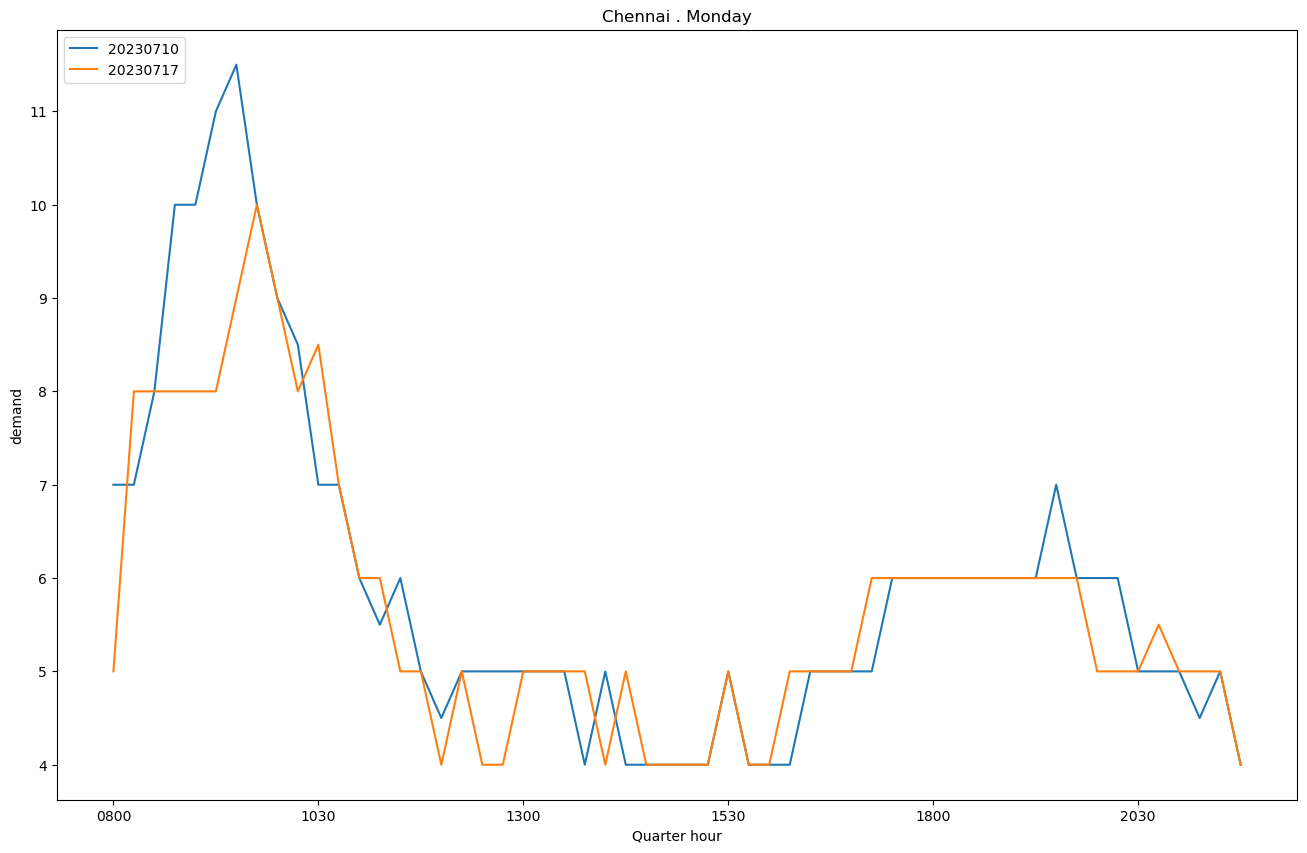

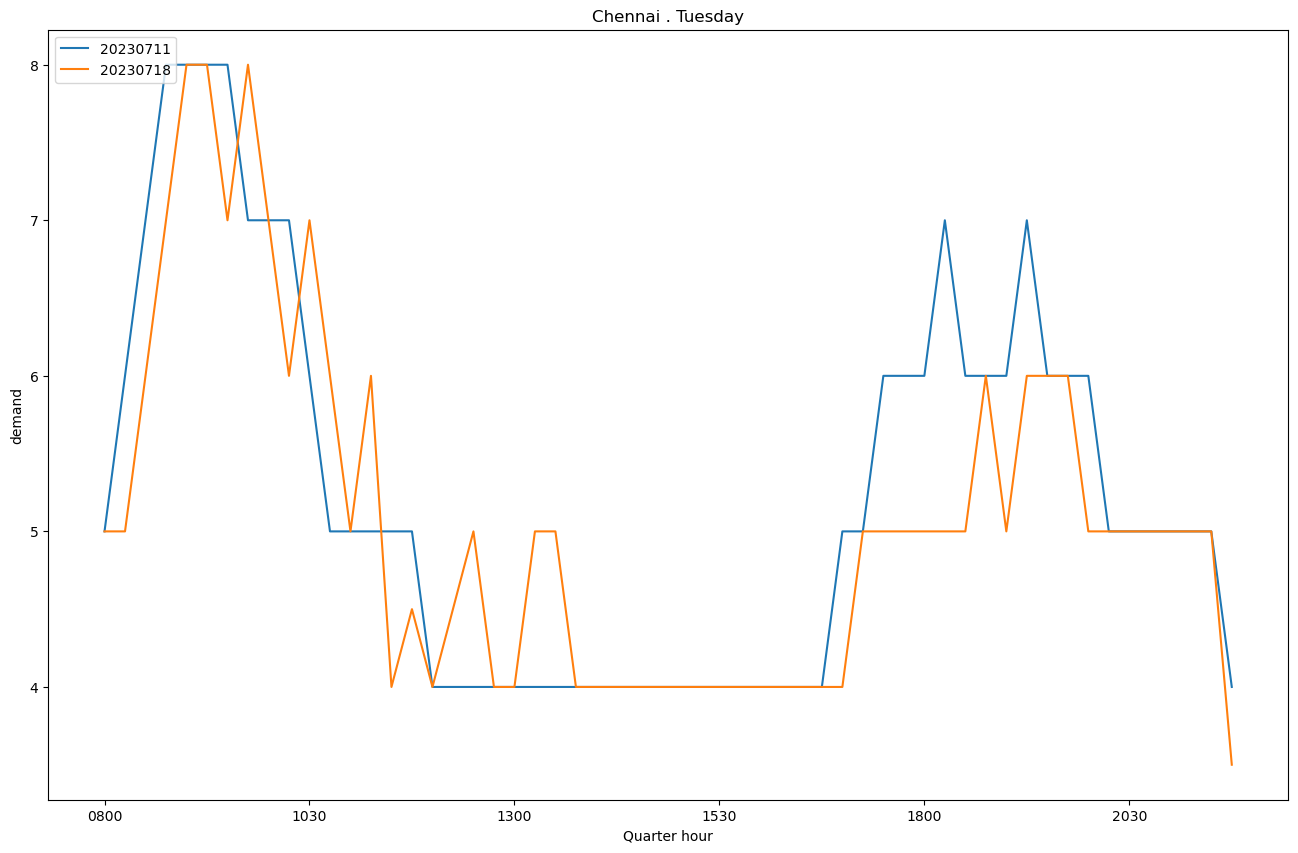

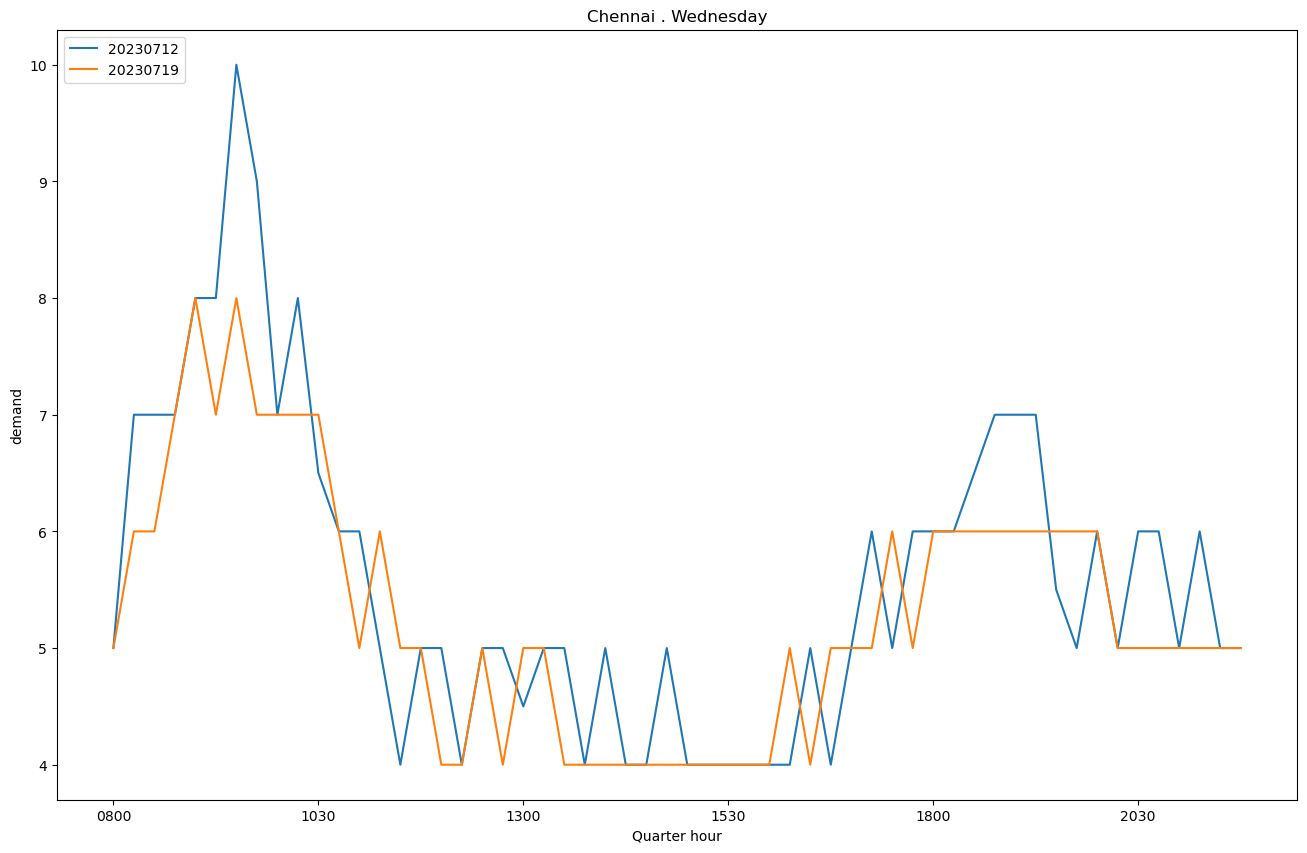

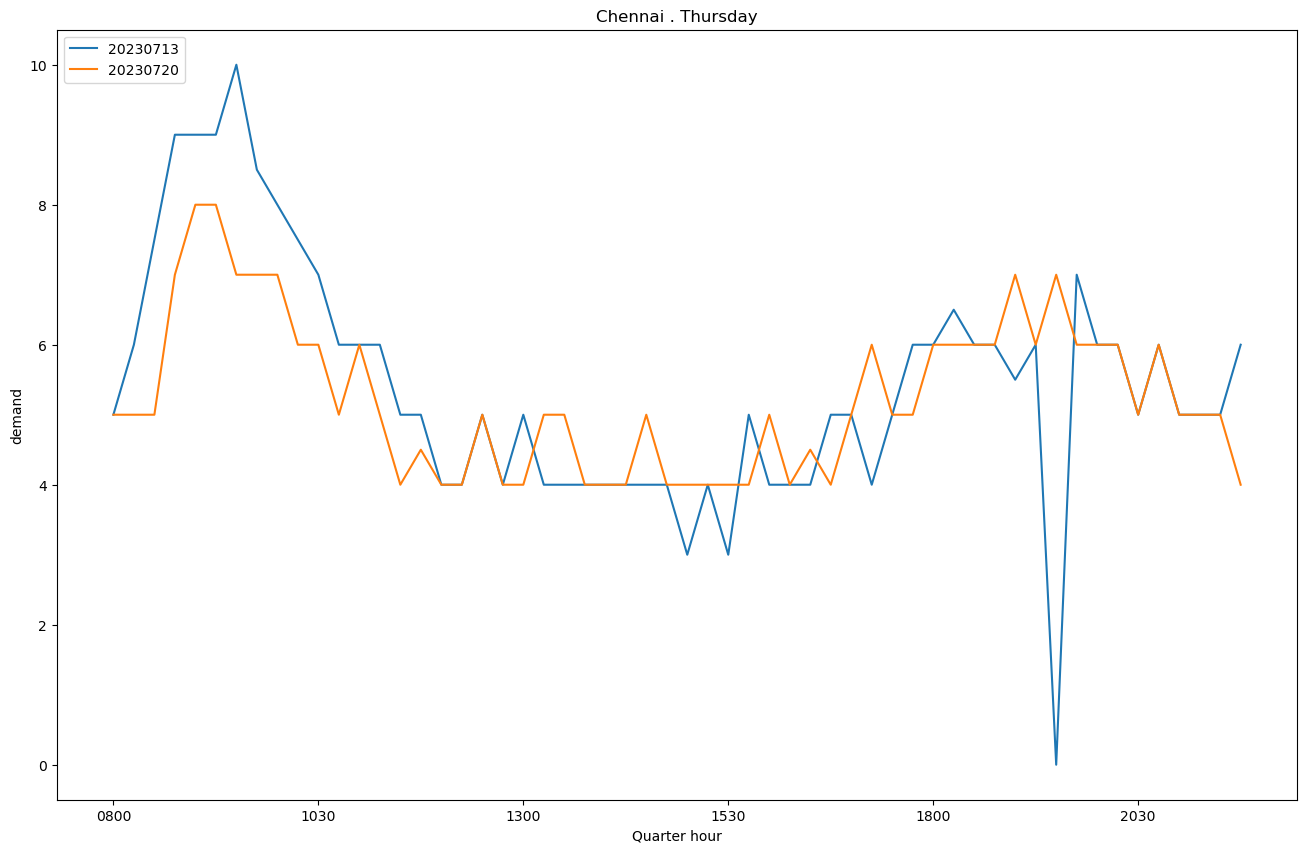

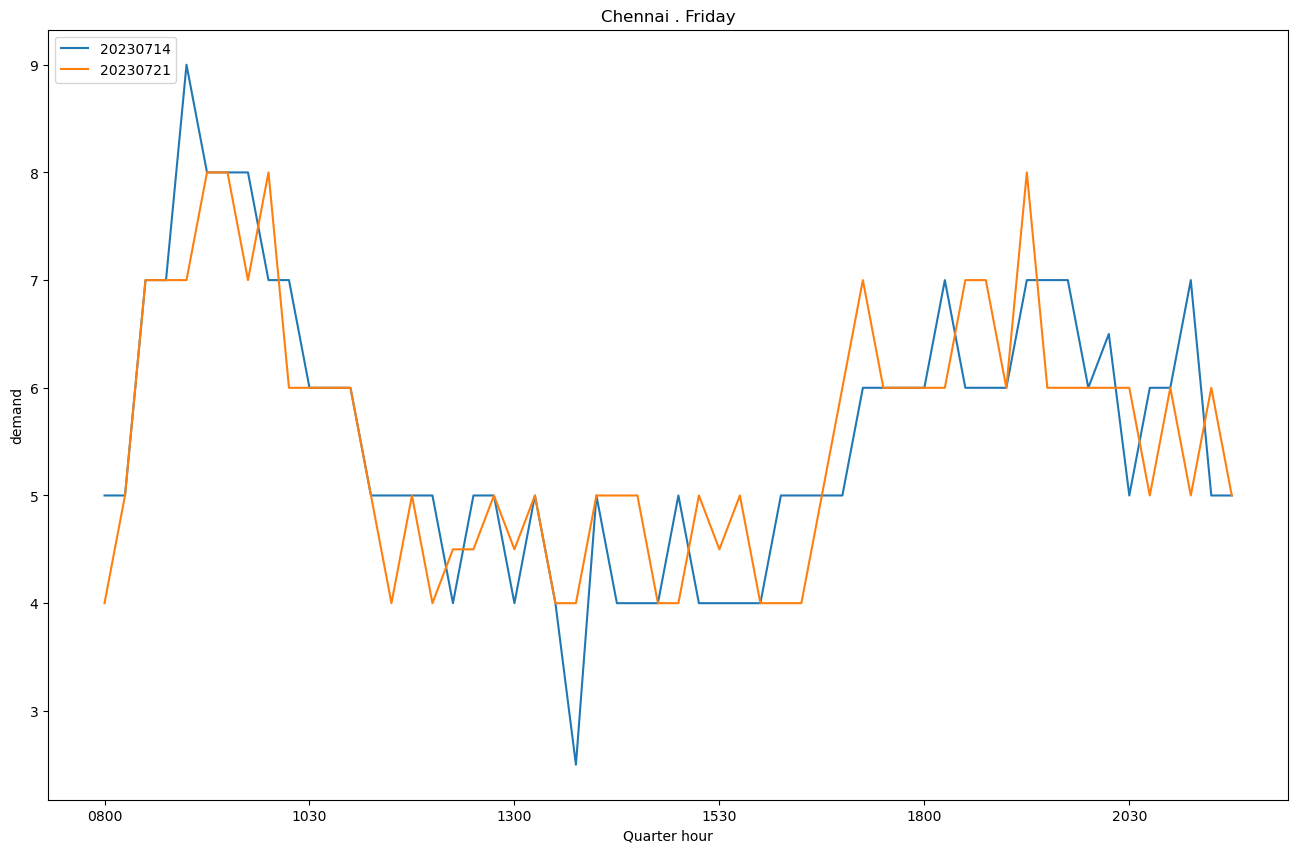

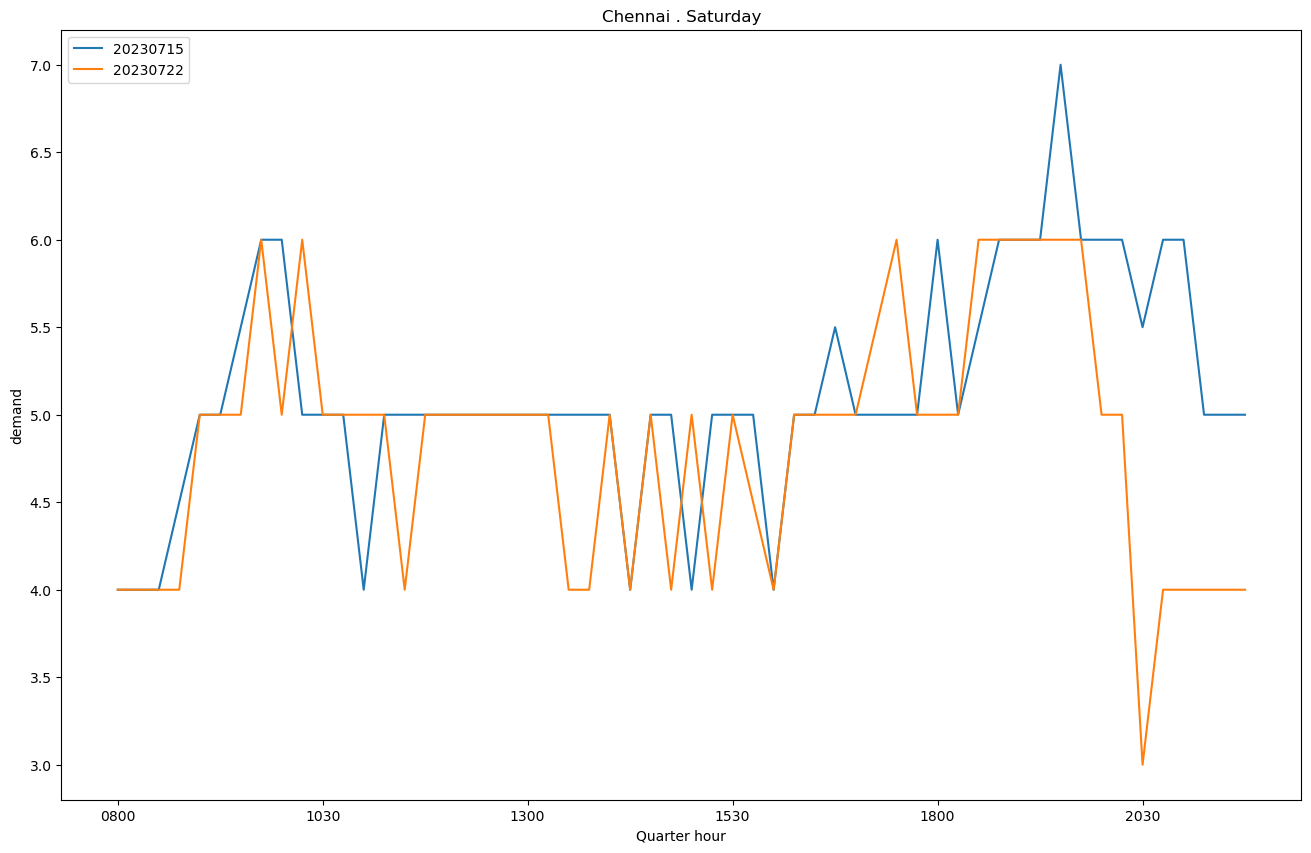

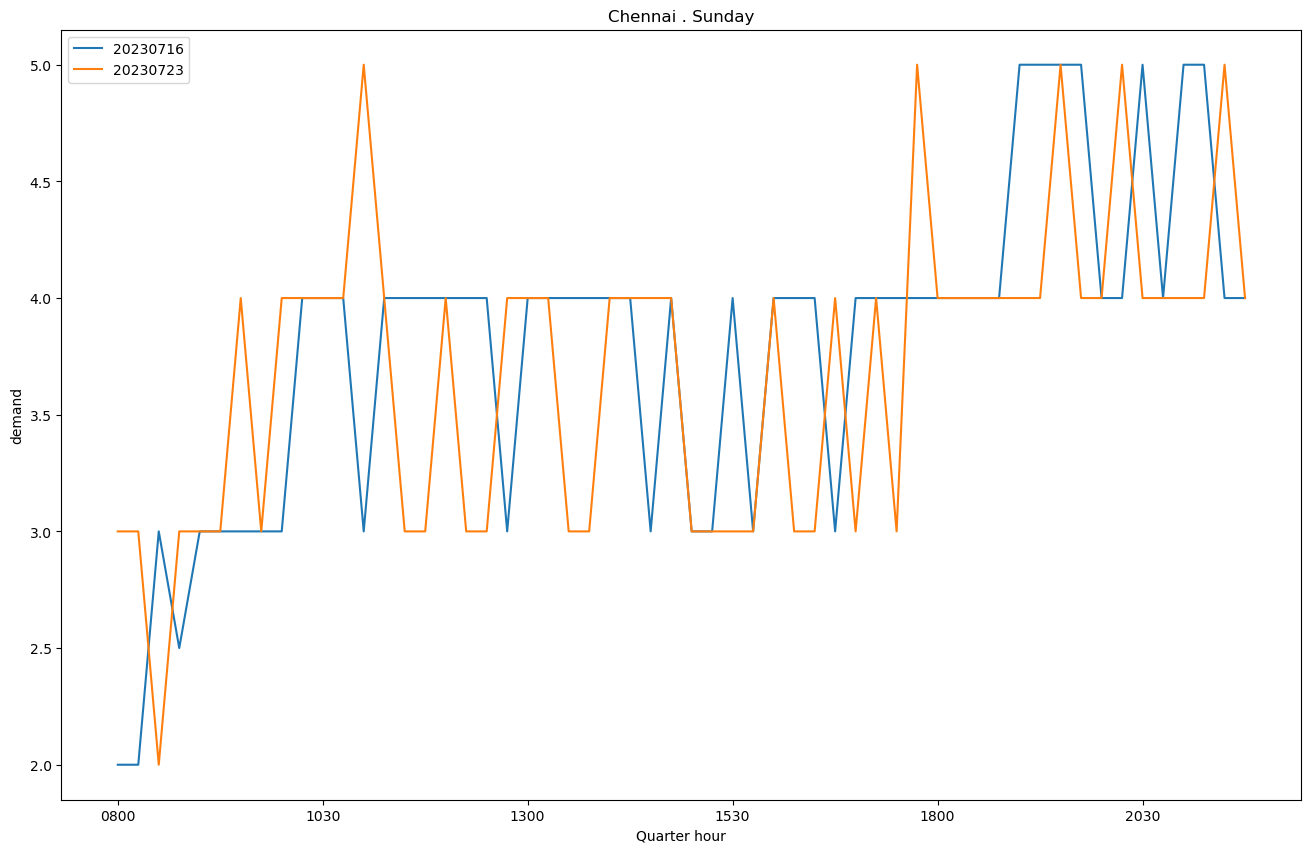

In [92]:
for each_week_period in demand_counts.week_period.unique().tolist():
    
    demand_each_wp = demand_counts[demand_counts['week_period'] == each_week_period]

    ax = demand_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='demand').plot(figsize=(16, 10))
    ax.set_title('{} . {}'.format(city, each_week_period))
    ax.set_xlabel('Quarter hour')
    ax.legend(loc='upper left')
    ax.set_ylabel('demand');

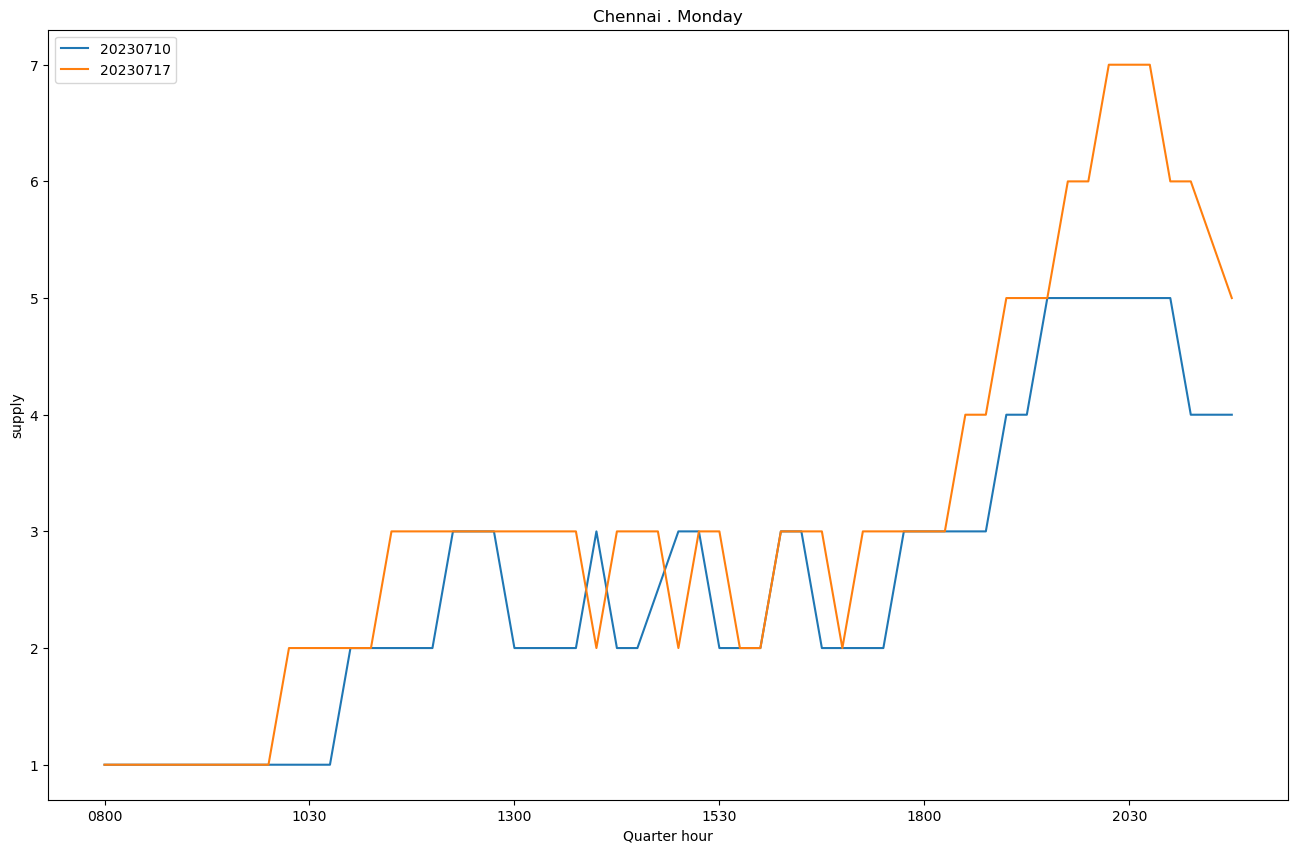

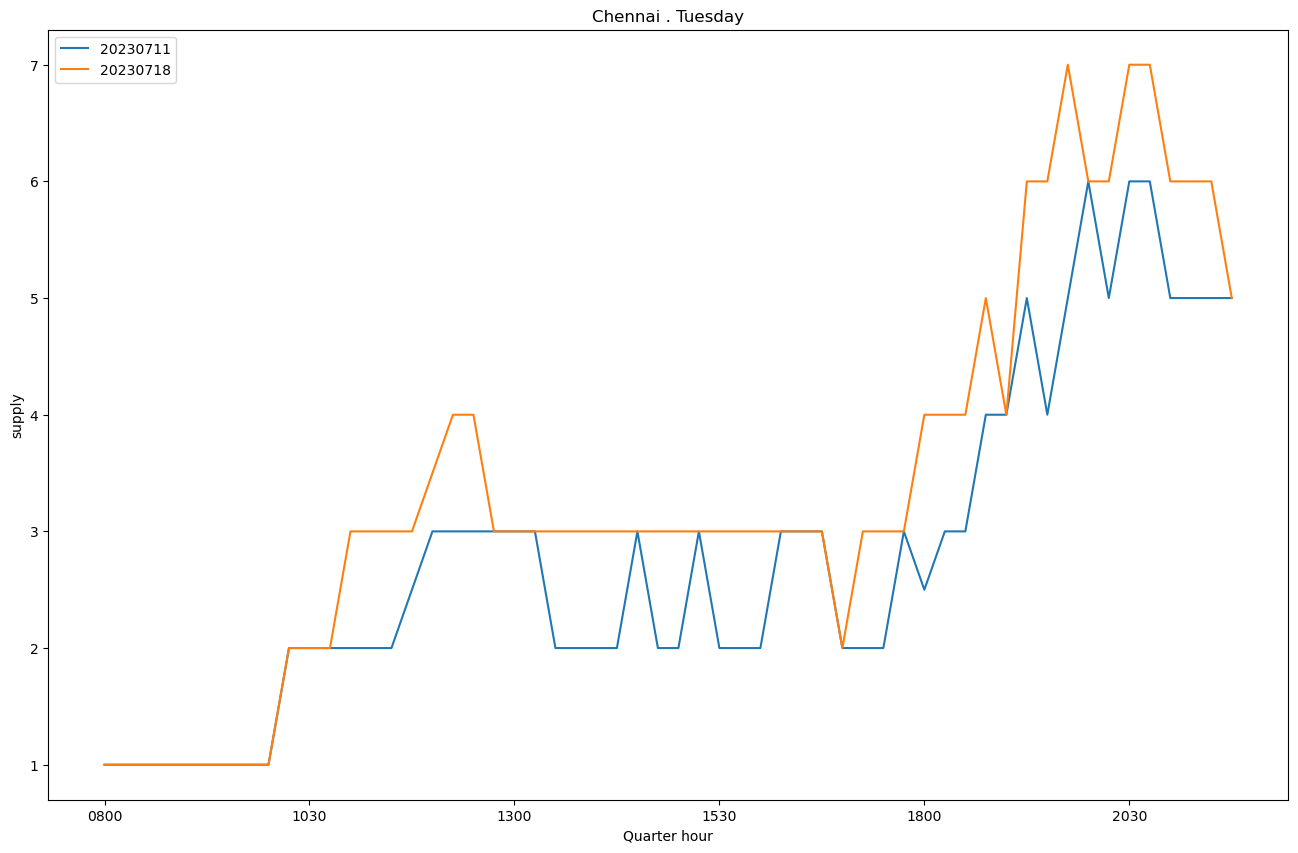

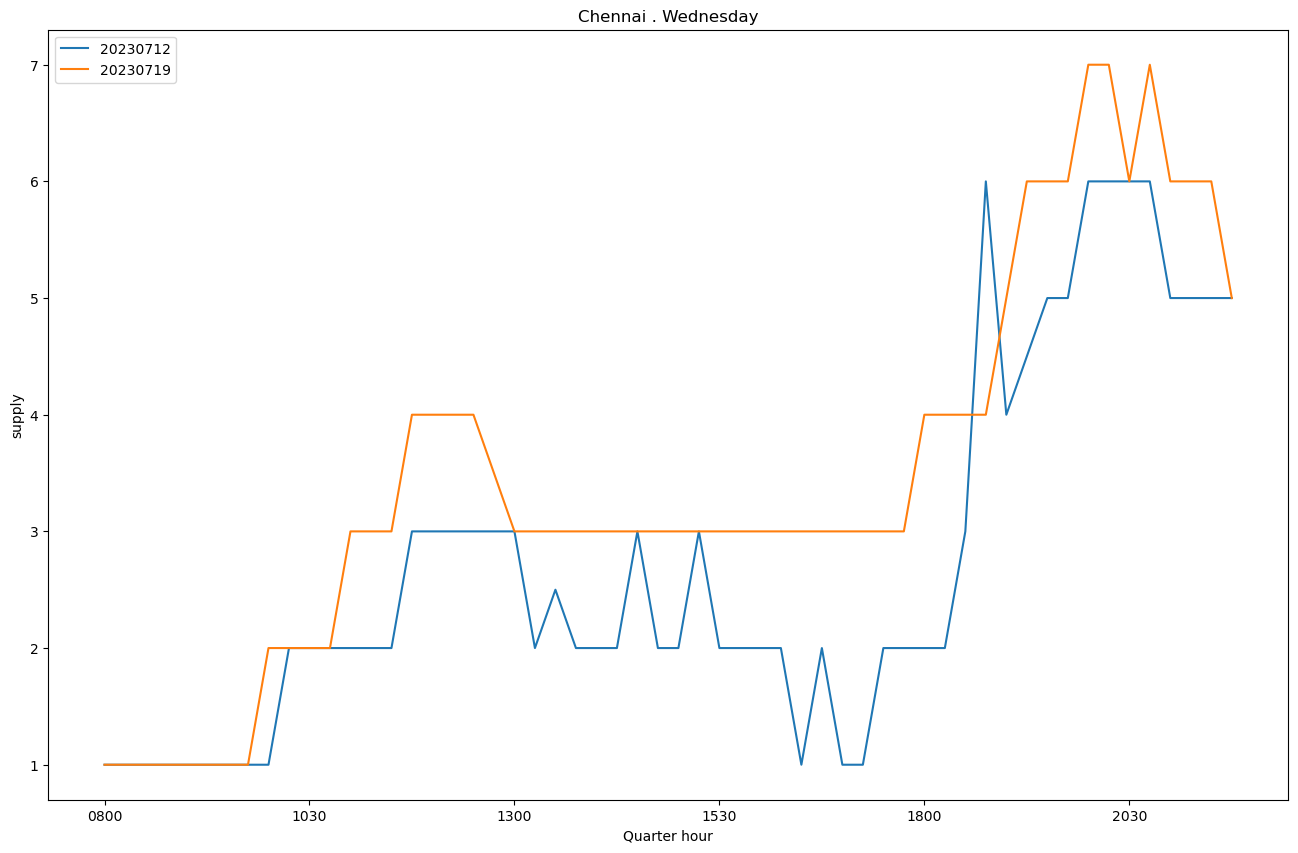

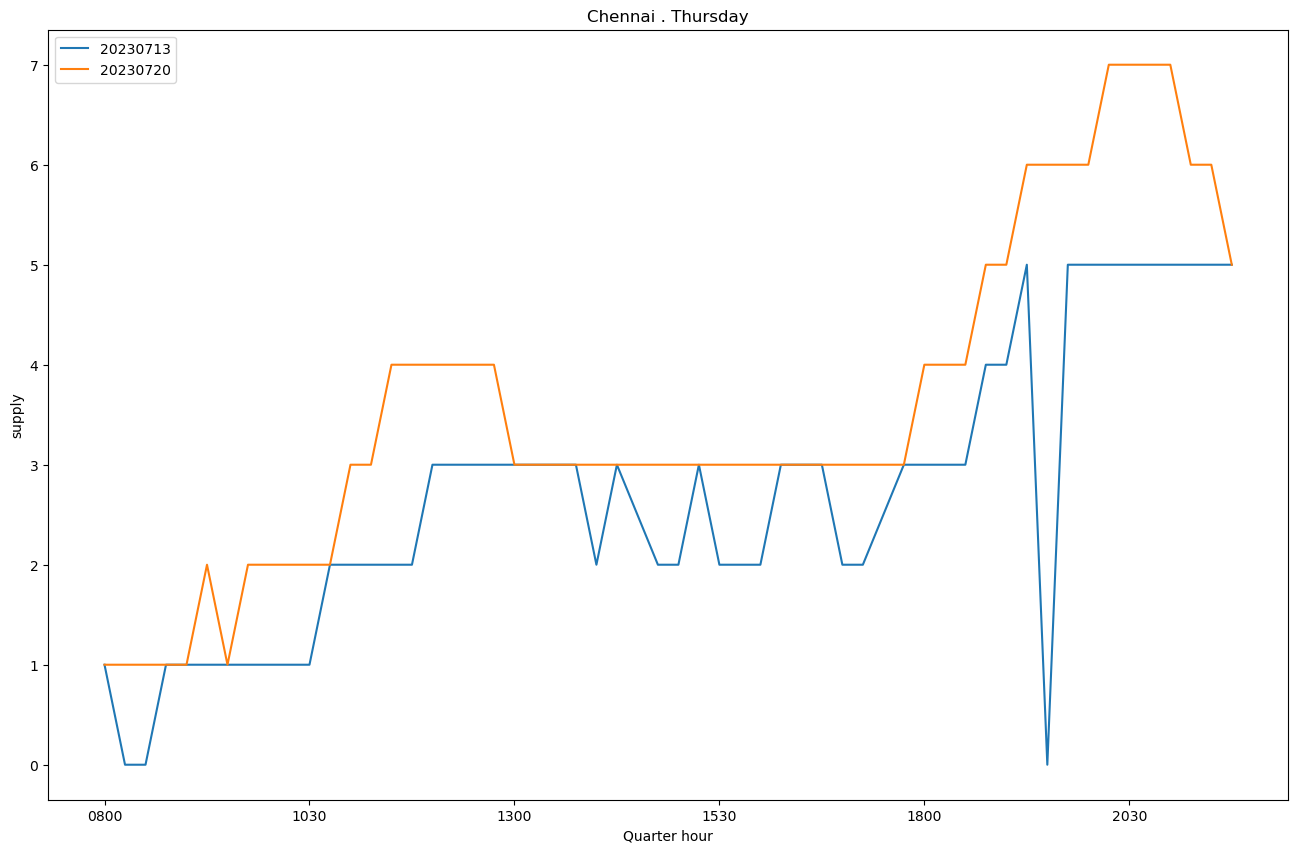

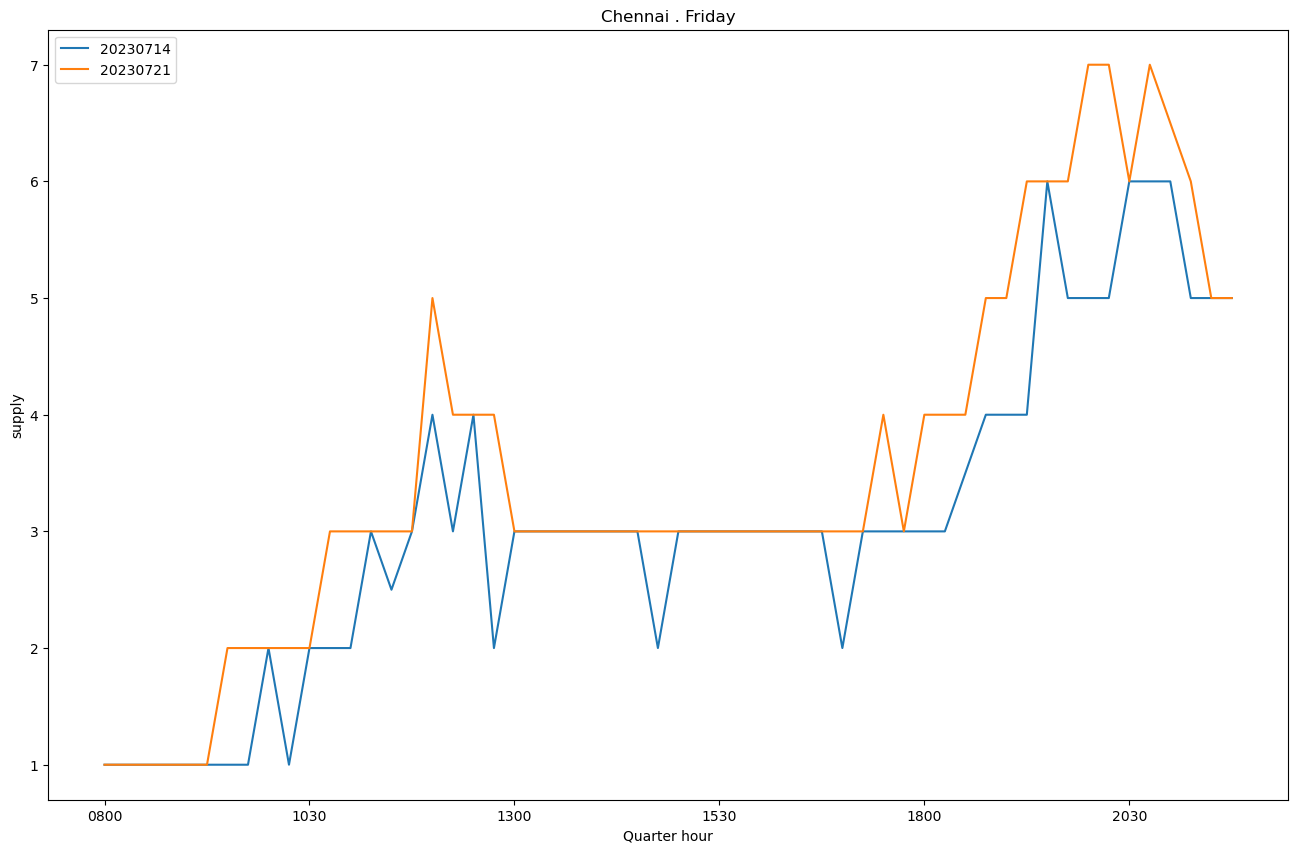

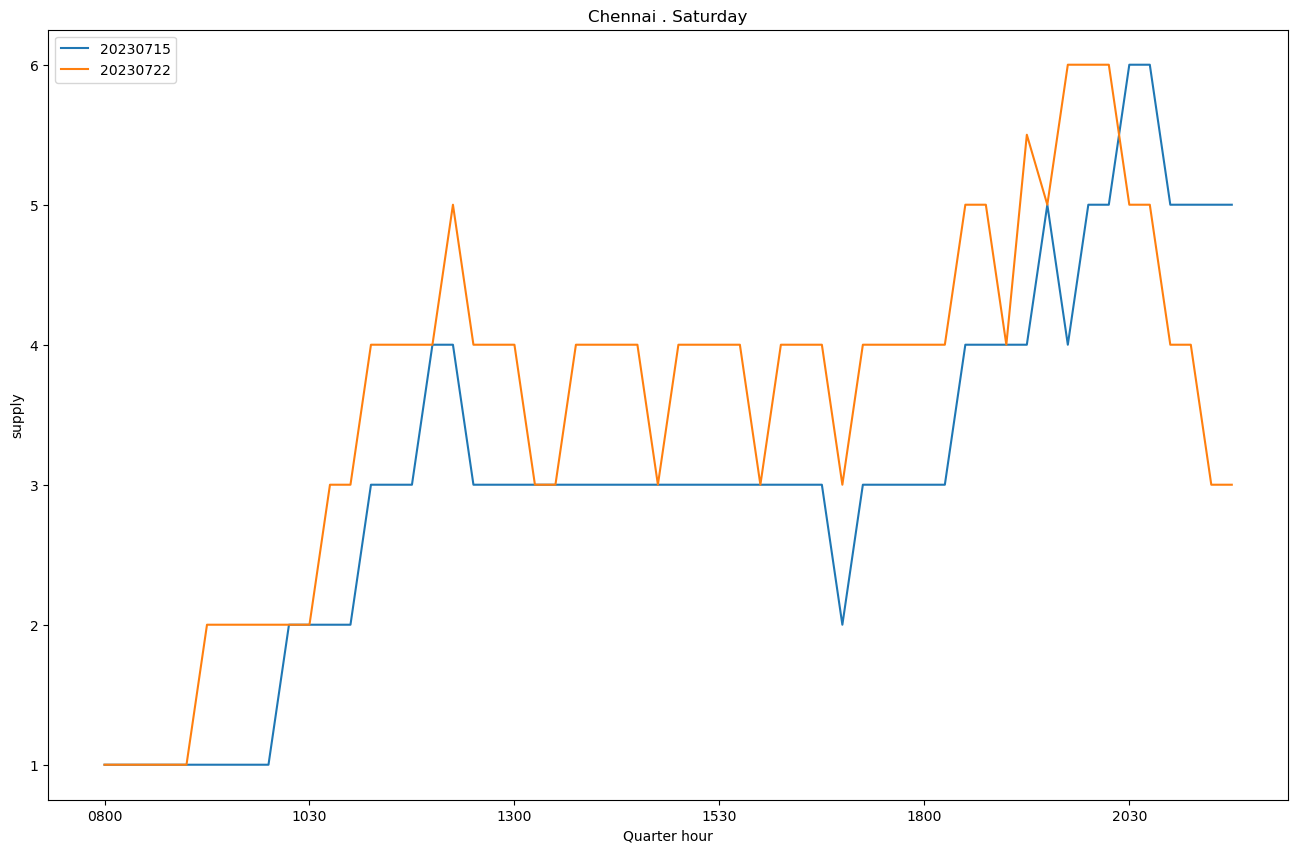

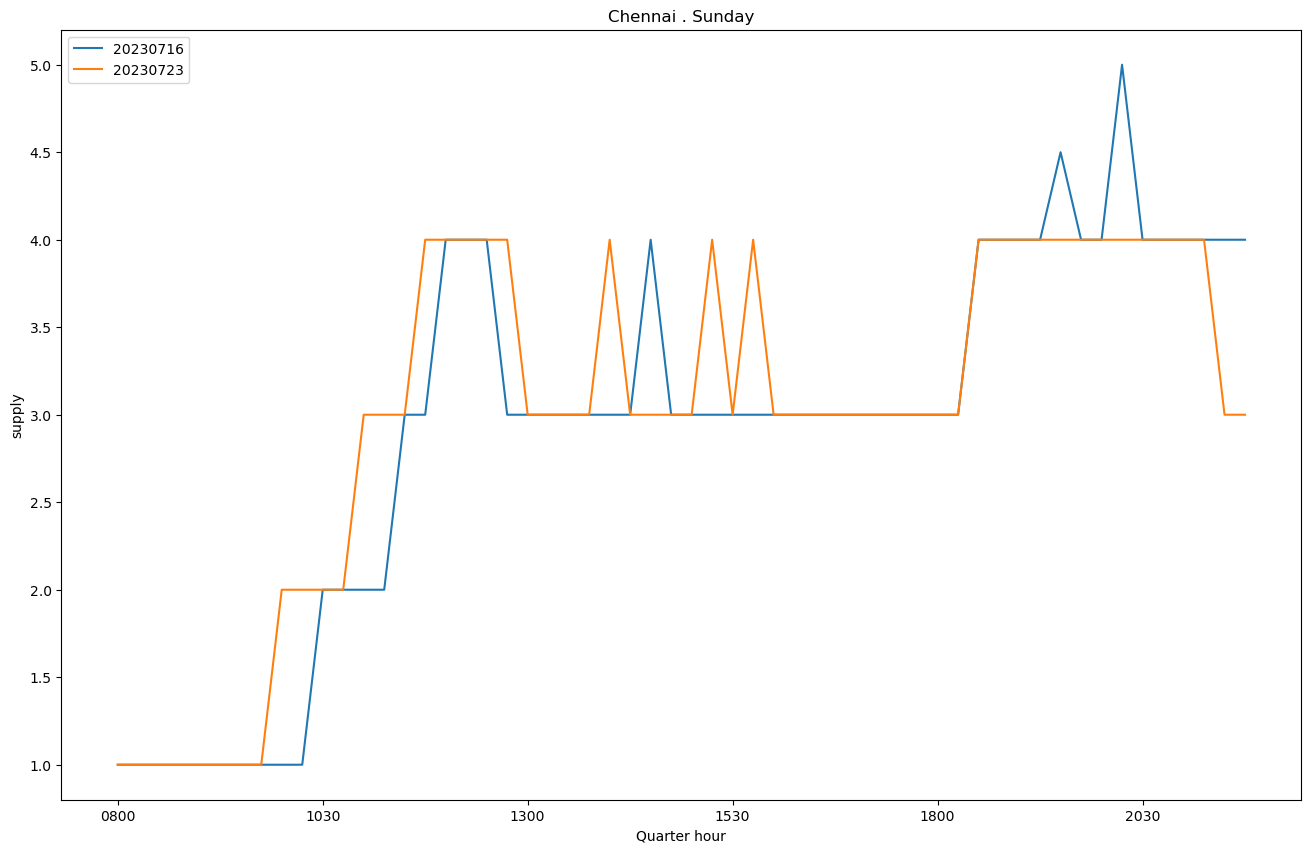

In [93]:
for each_week_period in demand_counts.week_period.unique().tolist():
    
    supply_each_wp = supply_counts[supply_counts['week_period'] == each_week_period]

    ax = supply_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='supply').plot(figsize=(16, 10))
    ax.set_title('{} . {}'.format(city, each_week_period))
    ax.set_xlabel('Quarter hour')
    ax.legend(loc='upper left')
    ax.set_ylabel('supply');

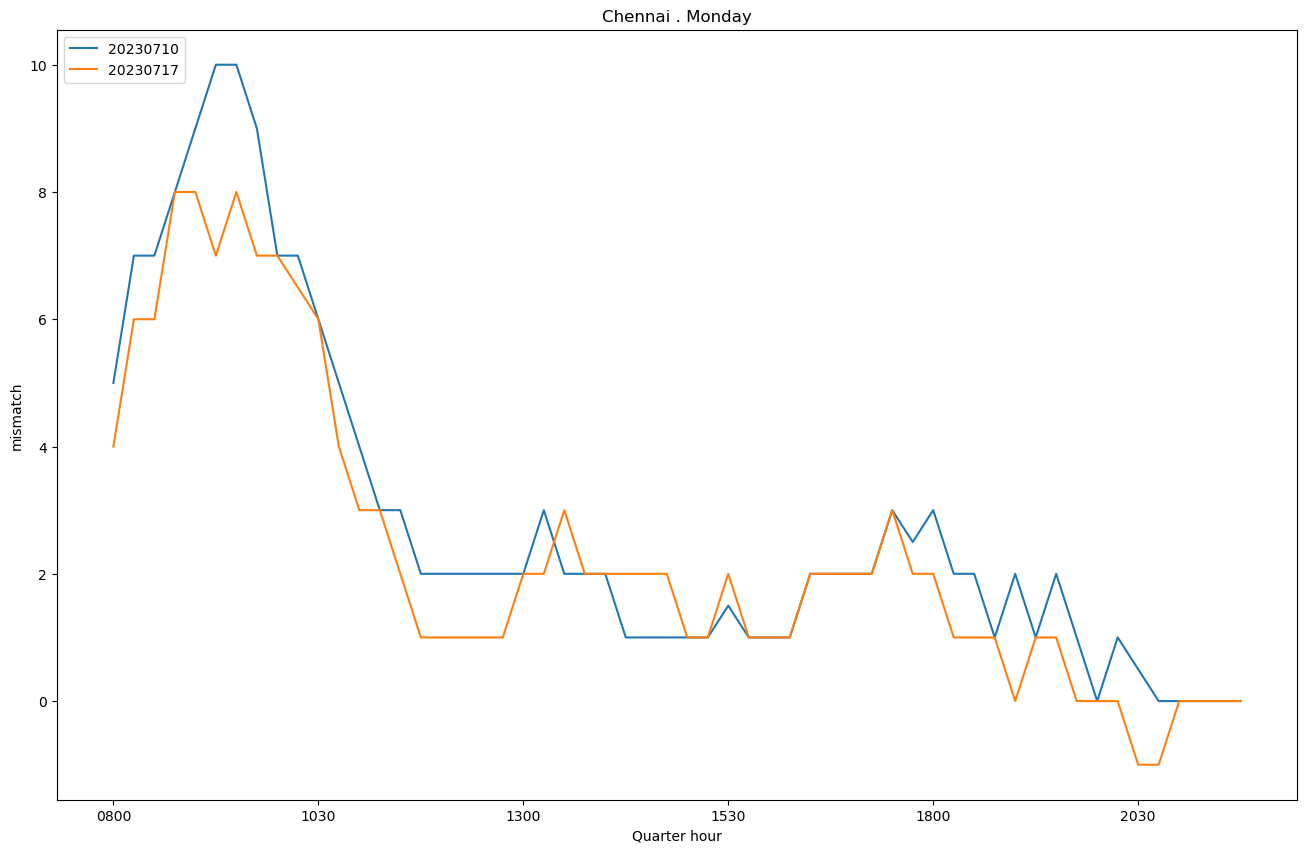

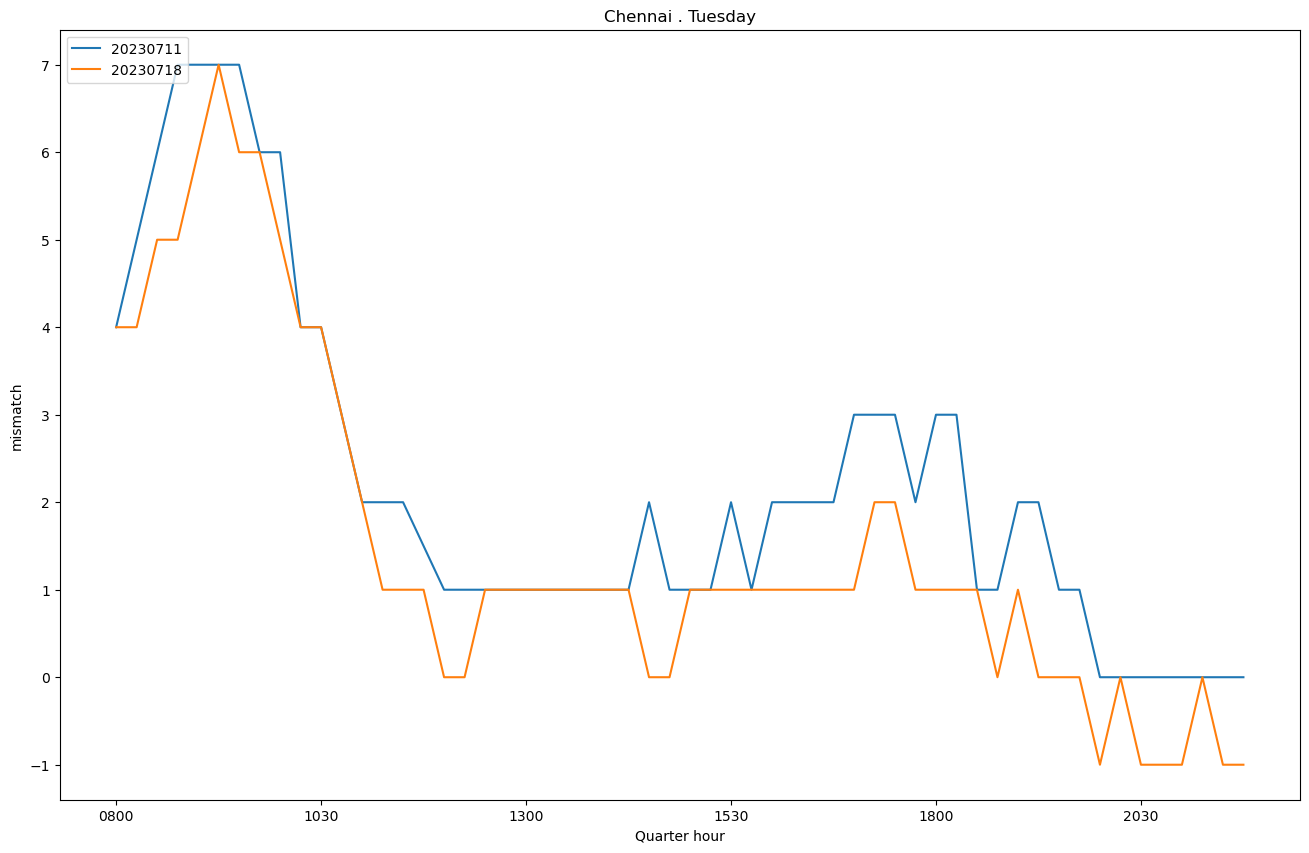

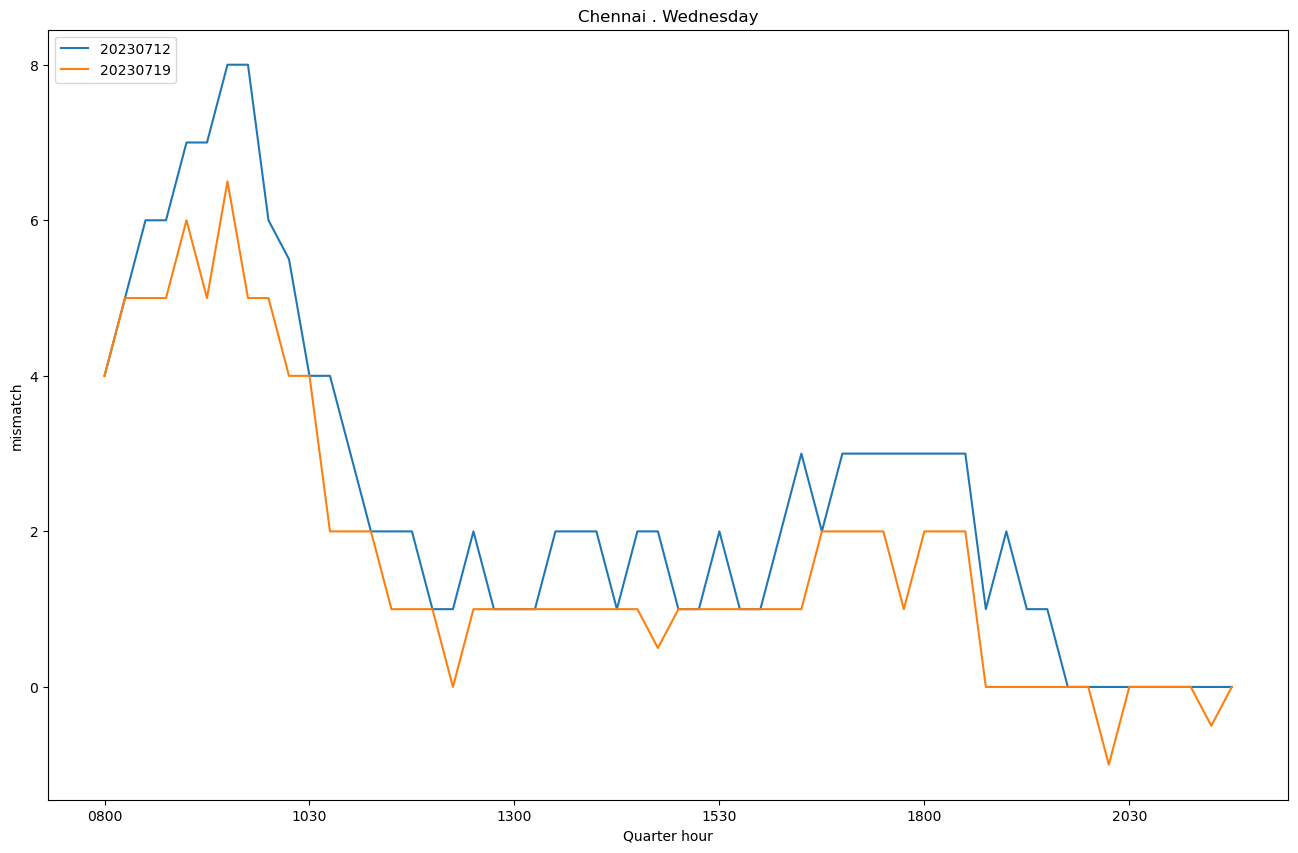

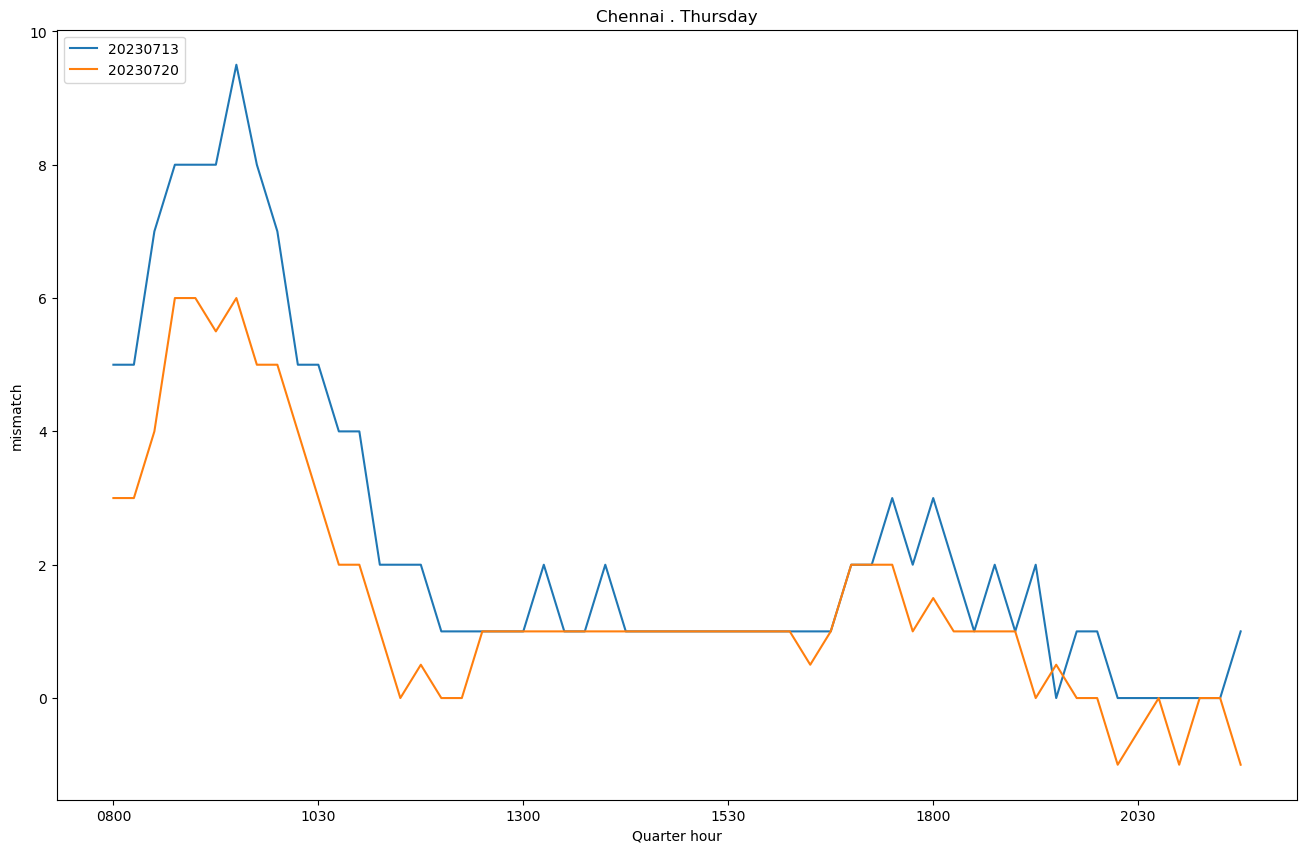

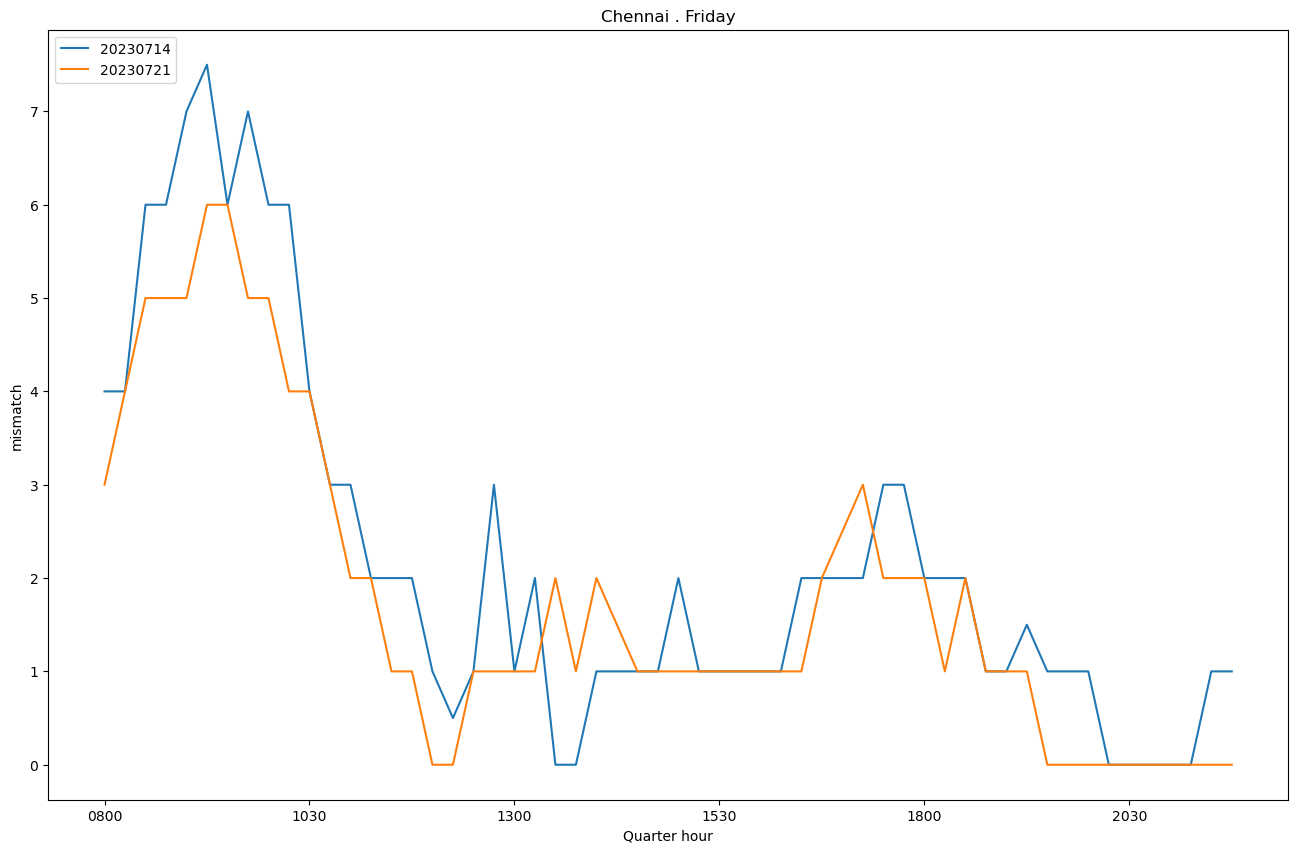

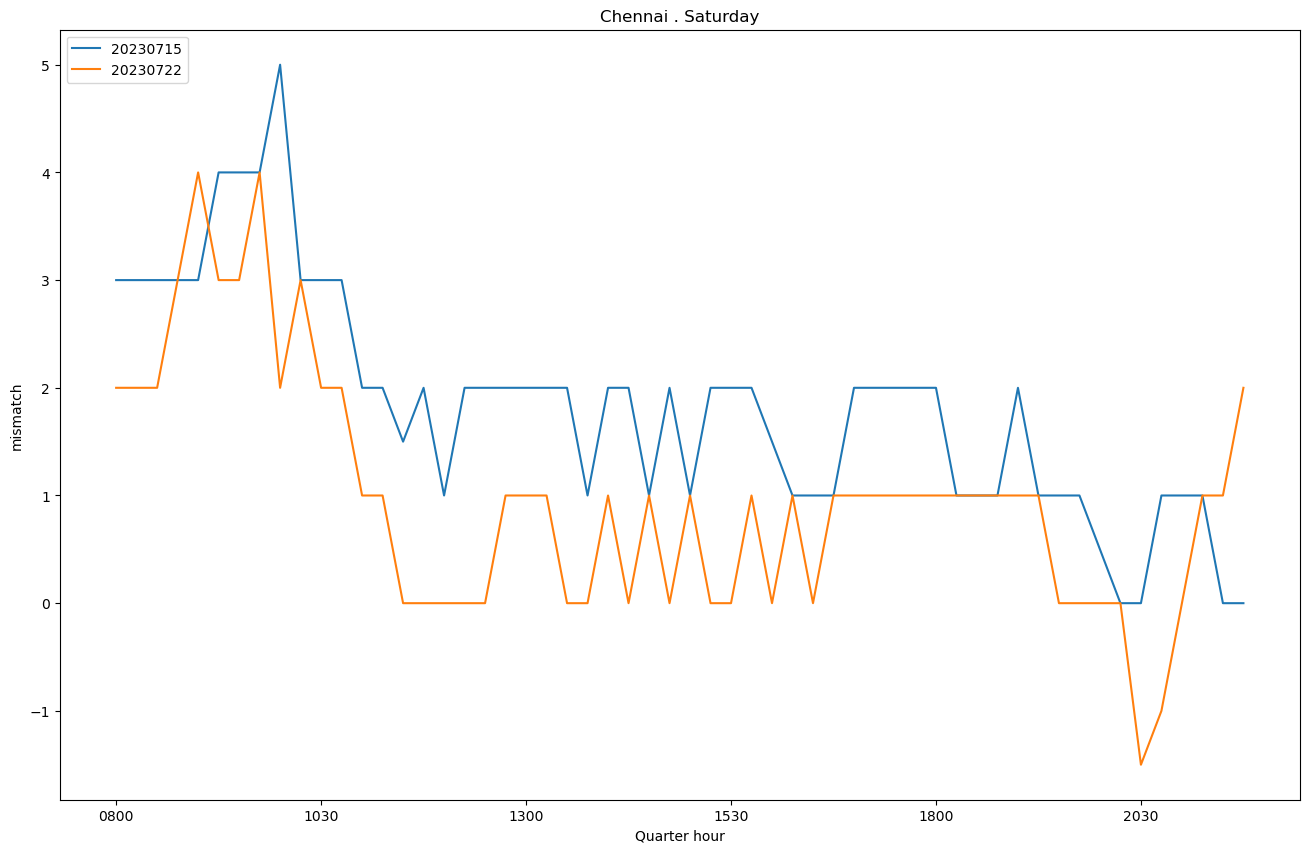

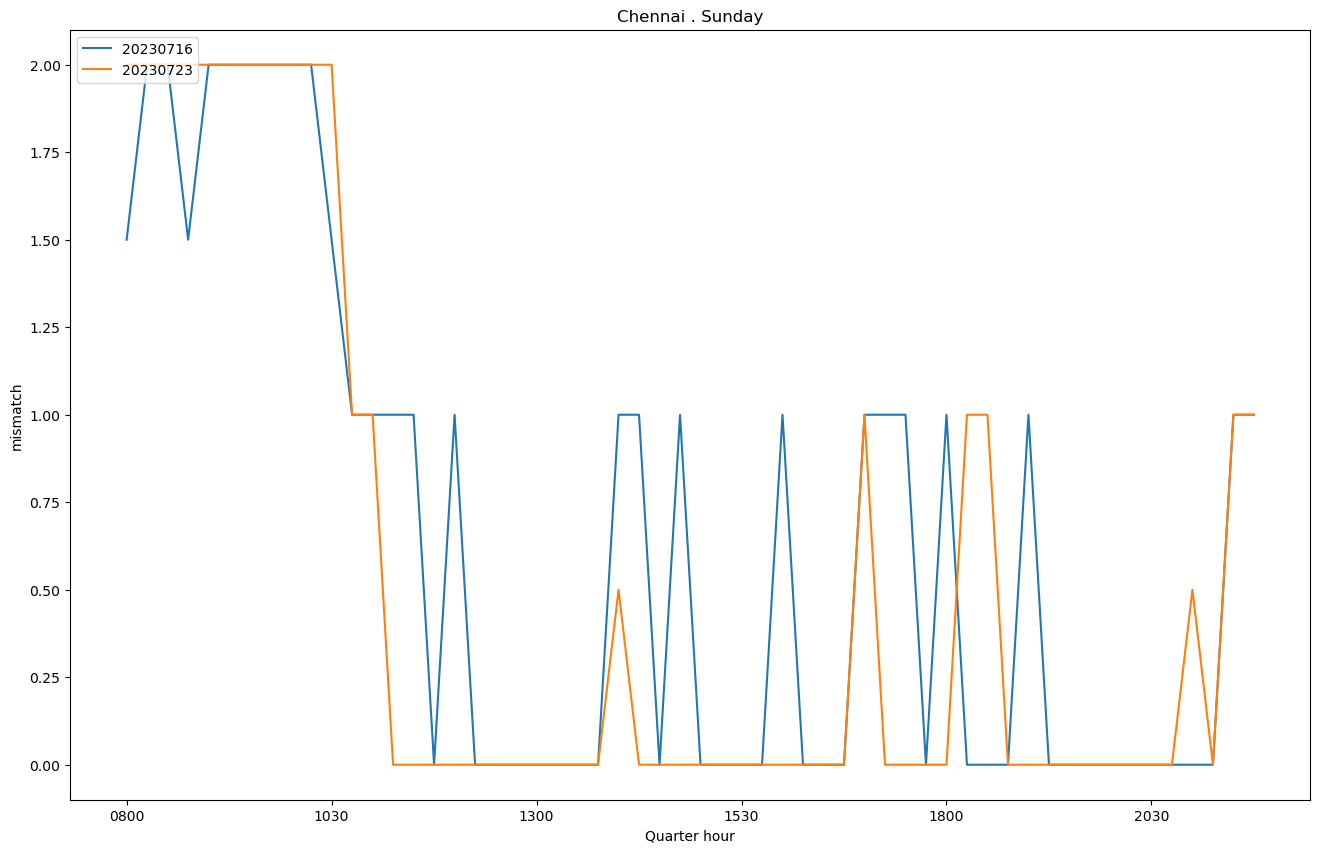

In [94]:
for each_week_period in demand_counts.week_period.unique().tolist():
    
    mismatch_each_wp = mismatch_counts[mismatch_counts['week_period'] == each_week_period]

    ax = mismatch_each_wp.pivot(index='quarter_hour', columns='yyyymmdd', values='mismatch').plot(figsize=(16, 10))
    ax.set_title('{} . {}'.format(city, each_week_period))
    ax.set_xlabel('Quarter hour')
    ax.legend(loc='upper left')
    ax.set_ylabel('mismatch');

### At city and time period level

In [95]:
# Demand view at city and time period level for Link orders.
deamnd_counts_tp = dcf_data \
    .groupby(['yyyymmdd', 'time_period', 'service_detail_id','week_period']) \
    .agg(demand=pd.NamedAgg('demand', 'median')) \
    .reset_index() \
    .pivot_table(index=['yyyymmdd', 'time_period'], columns='service_detail_id', values='demand') \
    .reset_index()

print(deamnd_counts_tp.shape)
deamnd_counts_tp.head()

(42, 3)


service_detail_id,yyyymmdd,time_period,5bed473f1278885df4ea9d57
0,20230710,afternoon,5.0
1,20230710,evening_peak,5.0
2,20230710,morning_peak,8.0
3,20230711,afternoon,4.0
4,20230711,evening_peak,6.0


In [96]:
# Supply view at city level and time_period for Link orders.
supply_counts_tp = dcf_data \
    .groupby(['yyyymmdd', 'time_period', 'service_detail_id','week_period']) \
    .agg(supply=pd.NamedAgg('supply', 'median')) \
    .reset_index() \
    .pivot_table(index=['yyyymmdd', 'time_period'], columns='service_detail_id', values='supply') \
    .reset_index()

print(supply_counts_tp.shape)
supply_counts_tp.head()

(42, 3)


service_detail_id,yyyymmdd,time_period,5bed473f1278885df4ea9d57
0,20230710,afternoon,2.0
1,20230710,evening_peak,4.0
2,20230710,morning_peak,1.0
3,20230711,afternoon,3.0
4,20230711,evening_peak,4.0


In [97]:
# Mismatch view at city and time_period level for Link orders.
mismatch_counts_tp = dcf_data \
    .groupby(['yyyymmdd', 'time_period', 'service_detail_id','week_period']) \
    .agg(mismatch=pd.NamedAgg('mismatch', 'median')) \
    .reset_index() \
    .pivot_table(index=['yyyymmdd', 'time_period'], columns='service_detail_id', values='mismatch') \
    .reset_index()

print(mismatch_counts_tp.shape)
mismatch_counts_tp.head()

(42, 3)


service_detail_id,yyyymmdd,time_period,5bed473f1278885df4ea9d57
0,20230710,afternoon,2.0
1,20230710,evening_peak,1.0
2,20230710,morning_peak,6.0
3,20230711,afternoon,1.0
4,20230711,evening_peak,1.0


### Check for cluster temporal combinations for which dcf_data has mismatch positive, 
* what is the supply
* what is the demand 

In [98]:
# clusters_post_idle_captain_threshold_filter = ['Gachibowli', 'Nanakramguda 2', 'Hitech City',
#        'Wipro Nanakramguda Circle', 'Wipro Gachibowli Campus',
#        'Manikonda', 'shilparamam', 'Kukatpally 3', 'Shamshabad',
#        'Banjara Hills', 'Bahadurguda', 'Quthbullapur', 'Saroor Nagar',
#        'Bodduppal', 'Hitech City 2', 'Mansoorabad', 'Miyapur 2',
#        'Hafeezpet', 'Hayath Nagar', 'Jeedimetla', 'Kukatpally',
#        'Kothaguda 2', 'BHEL']


clusters_post_idle_captain_threshold_filter = cluster_temporal_combinations_selected.pickup_cluster.unique().tolist()


dcf_data.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,...,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period,mismatch
1,5bed473f1278885df4ea9d57,2023-07-10,0800,Thoraipakkam,20,12,6.842931,10.0,2.0,morning_peak,...,Chennai,20230710,63,23,12,36.5,52.2,19.0,Monday,8.0
3,5bed473f1278885df4ea9d57,2023-07-10,0930,Madhavaram,2,2,2.777800,2.0,2.0,morning_peak,...,Chennai,20230710,18,3,2,16.7,66.7,11.1,Monday,0.0
5,5bed473f1278885df4ea9d57,2023-07-10,0930,Taramani,17,9,4.435067,9.0,1.0,morning_peak,...,Chennai,20230710,78,20,9,25.6,45.0,11.5,Monday,8.0
7,5bed473f1278885df4ea9d57,2023-07-10,0945,Kovilambakkam,15,4,3.572133,14.0,1.0,morning_peak,...,Chennai,20230710,89,20,4,22.5,20.0,4.5,Monday,13.0
9,5bed473f1278885df4ea9d57,2023-07-10,0945,Madhavaram,4,3,10.368333,1.0,1.0,morning_peak,...,Chennai,20230710,16,4,3,25.0,75.0,18.8,Monday,0.0


In [99]:
dcf_data_filtered_on_supply = dcf_data[dcf_data['pickup_cluster'].isin(clusters_post_idle_captain_threshold_filter)]

dcf_data_filtered_on_supply.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,...,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period,mismatch
7,5bed473f1278885df4ea9d57,2023-07-10,0945,Kovilambakkam,15,4,3.572133,14.0,1.0,morning_peak,...,Chennai,20230710,89,20,4,22.5,20.0,4.5,Monday,13.0
15,5bed473f1278885df4ea9d57,2023-07-10,1030,Thiruvanmiyur,12,9,3.247467,17.0,4.0,morning_peak,...,Chennai,20230710,85,12,9,14.1,75.0,10.6,Monday,13.0
17,5bed473f1278885df4ea9d57,2023-07-10,1045,Thiruvanmiyur,20,14,3.737710,10.0,5.0,morning_peak,...,Chennai,20230710,86,22,14,25.6,63.6,16.3,Monday,5.0
19,5bed473f1278885df4ea9d57,2023-07-10,1100,Thiruvanmiyur,26,16,3.567393,13.0,6.0,morning_peak,...,Chennai,20230710,65,31,16,47.7,51.6,24.6,Monday,7.0
21,5bed473f1278885df4ea9d57,2023-07-10,1115,Thiruvanmiyur,17,12,2.712867,21.0,6.0,morning_peak,...,Chennai,20230710,63,18,12,28.6,66.7,19.0,Monday,15.0


In [100]:
dcf_data_filtered_on_supply.quarter_hour.unique()

array(['0945', '1030', '1045', '1100', '1115', '1215', '1315', '1930',
       '1945', '2100', '1845', '0930', '1430', '1600', '1645', '1745',
       '1900', '2115', '2130', '2145', '0815', '0830', '0915', '1545',
       '1615', '1715', '1730', '1015', '1145', '1200', '1230', '2045',
       '1630', '1830', '0800', '0900', '1000', '1345', '1915', '2000',
       '2015', '0845', '1415', '1500', '2030', '1800', '1815', '1130',
       '1445', '1245', '1330', '1400', '1700', '1300', '1515', '1530'],
      dtype=object)

In [101]:
## morning peak vs evening peak vs afternoon peak of dcf_data post supply filter

cluster_name = clusters_post_idle_captain_threshold_filter[0]

dcf_data_filtered_on_supply_one_cluster = dcf_data_filtered_on_supply[
    dcf_data_filtered_on_supply['pickup_cluster'] == cluster_name]

dcf_data_filtered_on_supply_one_cluster.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,...,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period,mismatch
995,5bed473f1278885df4ea9d57,2023-07-10,1345,Kotturpuram,4,4,3.489917,6.0,7.0,afternoon,...,Chennai,20230710,26,5,4,19.2,80.0,15.4,Monday,-1.0
1001,5bed473f1278885df4ea9d57,2023-07-10,2015,Kotturpuram,5,3,4.374067,7.0,6.0,evening_peak,...,Chennai,20230710,22,6,3,27.3,50.0,13.6,Monday,1.0
1322,5bed473f1278885df4ea9d57,2023-07-17,2015,Kotturpuram,3,2,1.279600,4.0,10.0,evening_peak,...,Chennai,20230717,14,3,2,21.4,66.7,14.3,Monday,-6.0
1406,5bed473f1278885df4ea9d57,2023-07-19,1445,Kotturpuram,2,1,1.281600,6.0,2.0,afternoon,...,Chennai,20230719,26,2,1,7.7,50.0,3.8,Wednesday,4.0
1424,5bed473f1278885df4ea9d57,2023-07-19,2115,Kotturpuram,3,2,3.978875,2.0,4.0,evening_peak,...,Chennai,20230719,30,4,2,13.3,50.0,6.7,Wednesday,-2.0


In [102]:
dcf_data_filtered_on_supply_one_cluster['quarter_hour'] = dcf_data_filtered_on_supply_one_cluster[
    'quarter_hour'].astype('int')

dcf_data_filtered_on_supply_one_cluster = dcf_data_filtered_on_supply_one_cluster[
    (dcf_data_filtered_on_supply_one_cluster['quarter_hour'] >= 1100) & (
        dcf_data_filtered_on_supply_one_cluster['quarter_hour'] <= 2100)]

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/1904698678.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [103]:
dcf_data_stats =  pd.pivot_table( dcf_data_filtered_on_supply_one_cluster, 
values= ['supply'] , 
index=['pickup_cluster','week_period'],
columns=['quarter_hour'])

dcf_data_stats

supply                                          \
quarter_hour                 1100 1115  1130 1145  1200  1215  1230  1245   
pickup_cluster week_period                                                  
Kotturpuram    Friday         9.0  6.0   8.5  5.0   4.5   6.5   6.5   5.0   
               Monday         6.5  5.0   6.5  4.5   5.0   6.0   5.5   6.0   
               Saturday       7.5  8.5  10.5  6.0   7.5   7.5   7.5   6.0   
               Sunday         5.0  3.0   5.5  6.0  11.0  22.5  27.5  19.0   
               Thursday       7.0  8.0  11.0  7.5   6.5   8.0   6.0   7.0   
               Tuesday        4.0  6.5   5.0  4.5   5.5   5.0   6.0   7.0   
               Wednesday      6.5  6.0   7.5  4.5   6.5   7.5   9.0   8.0   

                                        ...                               \
quarter_hour                1300  1315  ...  1845  1900 1915  1930  1945   
pickup_cluster week_period              ...                                
Kotturpuram    Friday        7.5   4.5  ...   7.0   6.5  8.0   9.5  10.0   
               Monday        7.0   5.0  ...   5.0   7.0  8.0   5.0   6.5   
               Saturday      4.5   4.0  ...   6.0   6.5  7.5   7.0   7.5   
               Sunday       21.0  10.0  ...  14.5  15.5  5.0  11.5  23.0   
               Thursday      6.5   4.0  ...   5.5   7.0  8.5   5.0   7.0   
               Tuesday       7.0   3.5  ...   8.0  10.5  9.5   7.0  11.0   
               Wednesday     5.0   4.5  ...   7.5  10.0  6.5   7.0  10.0   

                                                          
quarter_hour                2000  2015  2030  2045  2100  
pickup_cluster week_period                                
Kotturpuram    Friday        6.5  10.0   9.0   7.0  10.0  
               Monday        6.0   8.0   7.5   9.0   9.0  
               Saturday      7.5  11.5   8.5   8.0  11.5  
               Sunday       28.5  26.0  16.0  15.5  18.5  
               Thursday      9.5  12.0   8.0  10.5   9.5  
               Tuesday      11.0  13.5   6.5   8.5   9.5  
               Wednesday     9.0   9.0   6.5  11.0   7.5  

[7 rows x 41 columns]

In [104]:
dcf_data_filtered_on_supply['quarter_hour'] = dcf_data_filtered_on_supply[
    'quarter_hour'].astype('int')

dcf_data_filtered_on_supply = dcf_data_filtered_on_supply[
    (dcf_data_filtered_on_supply['quarter_hour'] >= 1100) & (
        dcf_data_filtered_on_supply['quarter_hour'] <= 2100)]

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/2215548235.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
dcf_data_stats =  pd.pivot_table( dcf_data_filtered_on_supply, 
values= ['supply'] , 
index=['pickup_cluster','week_period'],
columns=['quarter_hour'])

dcf_data_stats

supply                                            \
quarter_hour                 1100  1115  1130  1145  1200  1215  1230  1245   
pickup_cluster week_period                                                    
Adambakkam     Friday         1.0   3.0   3.0   2.5   4.0   4.0   4.0   1.5   
               Monday         1.5   2.0   1.5   3.0   4.0   3.5   4.0   3.0   
               Saturday       3.0   3.0   3.5   4.0   5.0   3.5   5.0   4.5   
               Sunday         1.5   2.5   4.0   4.0   4.0   4.5   4.5   3.5   
               Thursday       1.0   1.0   2.5   3.5   4.0   4.0   4.0   3.0   
...                           ...   ...   ...   ...   ...   ...   ...   ...   
kilpauk        Saturday      14.5  18.5  21.5  22.5  24.5  19.0  21.0  17.5   
               Sunday        14.5  16.5  18.0  18.0  19.0  18.0  20.5  16.0   
               Thursday      13.0  16.5  19.0  19.5  22.0  18.5  20.0  15.0   
               Tuesday       14.0  16.0  16.5  19.0  25.0  19.0  20.0  14.0   
               Wednesday     13.0  17.0  17.0  16.5  22.0  16.5  18.5  15.0   

                                        ...                                \
quarter_hour                1300  1315  ...  1845  1900  1915  1930  1945   
pickup_cluster week_period              ...                                 
Adambakkam     Friday        4.0   4.0  ...   4.5   4.5   6.0   5.5   7.0   
               Monday        4.0   3.0  ...   4.5   4.5   5.0   6.5   7.0   
               Saturday      5.0   4.0  ...   6.5   5.0   5.0   5.0   6.0   
               Sunday        3.5   3.5  ...   3.5   4.0   5.5   4.0   5.0   
               Thursday      3.5   4.0  ...   5.5   5.0   6.5   4.0   7.5   
...                          ...   ...  ...   ...   ...   ...   ...   ...   
kilpauk        Saturday     16.0  17.0  ...  24.0  24.0  33.0  31.5  35.5   
               Sunday       16.5  15.0  ...  18.5  16.5  21.5  25.0  26.5   
               Thursday     15.0  12.5  ...  24.5  22.5  35.0  21.5  42.0   
               Tuesday      14.0  14.5  ...  25.0  24.5  36.5  42.0  39.0   
               Wednesday    13.5  15.0  ...  28.5  25.0  34.0  37.0  39.5   

                                                          
quarter_hour                2000  2015  2030  2045  2100  
pickup_cluster week_period                                
Adambakkam     Friday        8.0   7.5   9.0   8.0   6.5  
               Monday        8.0   6.0   9.0   7.5   5.5  
               Saturday      6.5   7.0   5.5   5.5   4.5  
               Sunday        4.5   5.0   5.5   4.5   3.5  
               Thursday      7.0   7.0   8.5   9.0   8.0  
...                          ...   ...   ...   ...   ...  
kilpauk        Saturday     34.5  37.5  31.0  28.5  25.5  
               Sunday       27.0  26.0  24.5  19.0  19.0  
               Thursday     42.0  46.0  35.5  37.0  32.0  
               Tuesday      37.5  41.0  38.5  40.0  30.5  
               Wednesday    39.5  40.0  36.5  35.5  31.5  

[231 rows x 41 columns]

In [106]:
dcf_data.head()

,service_detail_id,orderdate,quarter_hour,pickup_cluster,gross_orders,net_orders,mean_distance,demand,supply,time_period,...,city,yyyymmdd,fe_count,rr_count,net_count,FE2RR,G2N,FE2Net,week_period,mismatch
1,5bed473f1278885df4ea9d57,2023-07-10,0800,Thoraipakkam,20,12,6.842931,10.0,2.0,morning_peak,...,Chennai,20230710,63,23,12,36.5,52.2,19.0,Monday,8.0
3,5bed473f1278885df4ea9d57,2023-07-10,0930,Madhavaram,2,2,2.777800,2.0,2.0,morning_peak,...,Chennai,20230710,18,3,2,16.7,66.7,11.1,Monday,0.0
5,5bed473f1278885df4ea9d57,2023-07-10,0930,Taramani,17,9,4.435067,9.0,1.0,morning_peak,...,Chennai,20230710,78,20,9,25.6,45.0,11.5,Monday,8.0
7,5bed473f1278885df4ea9d57,2023-07-10,0945,Kovilambakkam,15,4,3.572133,14.0,1.0,morning_peak,...,Chennai,20230710,89,20,4,22.5,20.0,4.5,Monday,13.0
9,5bed473f1278885df4ea9d57,2023-07-10,0945,Madhavaram,4,3,10.368333,1.0,1.0,morning_peak,...,Chennai,20230710,16,4,3,25.0,75.0,18.8,Monday,0.0


In [107]:
dcf_data.demand.median()

5.0

In [108]:
dcf_data['hour'] = dcf_data['quarter_hour'].apply(lambda x: str(x[0:2]))
dcf_data['mismatch'] = dcf_data['demand'] - dcf_data['supply']

dcf_data_stats_hour_level = dcf_data.groupby([
    'city','pickup_cluster','service_detail_id','week_period','time_period','hour']).agg(
    demand = pd.NamedAgg('demand','sum'), 
    supply = pd.NamedAgg('supply','sum'),
    mismatch = pd.NamedAgg('mismatch','median'), 
    fe_count = pd.NamedAgg('fe_count','sum'), 
    rr_count = pd.NamedAgg('rr_count','sum'), 
    net_count = pd.NamedAgg('net_count','sum')
).reset_index().sort_values(['city','pickup_cluster','service_detail_id','week_period','hour','time_period'])

dcf_data_stats_hour_level['mismtach_pred'] = dcf_data_stats_hour_level['demand'] - dcf_data_stats_hour_level['supply']

dcf_data_stats_hour_level.head(20)

,city,pickup_cluster,service_detail_id,week_period,time_period,hour,demand,supply,mismatch,fe_count,rr_count,net_count,mismtach_pred
10,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,08,146.0,1.0,18.0,662,171,71,145.0
11,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,09,206.0,5.0,25.5,853,241,83,201.0
12,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,10,129.0,7.0,14.5,469,135,77,122.0
13,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,11,90.0,19.0,9.0,314,72,49,71.0
0,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,afternoon,12,75.0,27.0,7.5,285,72,55,48.0
1,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,afternoon,13,39.0,27.0,3.0,189,38,25,12.0
2,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,afternoon,14,60.0,24.0,4.5,279,82,42,36.0
3,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,afternoon,15,56.0,30.0,2.5,204,50,32,26.0
4,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,afternoon,16,45.0,29.0,2.0,247,48,40,16.0
5,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,evening_peak,17,63.0,26.0,4.0,274,73,61,37.0


In [109]:
dcf_data_stats_hour_level['excess_supply_ratio'] = dcf_data_stats_hour_level[
    'supply']/dcf_data_stats_hour_level['demand']

dcf_data_stats_hour_level.loc[(dcf_data_stats_hour_level['excess_supply_ratio'] > 1.0) , 'is_excess_supply'] = 'yes'
dcf_data_stats_hour_level.loc[(dcf_data_stats_hour_level['excess_supply_ratio'] <= 1.0) , 'is_excess_supply'] = 'no'
dcf_data_stats_hour_level.head()

,city,pickup_cluster,service_detail_id,week_period,time_period,hour,demand,supply,mismatch,fe_count,rr_count,net_count,mismtach_pred,excess_supply_ratio,is_excess_supply
10,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,08,146.0,1.0,18.0,662,171,71,145.0,0.006849,no
11,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,09,206.0,5.0,25.5,853,241,83,201.0,0.024272,no
12,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,10,129.0,7.0,14.5,469,135,77,122.0,0.054264,no
13,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,11,90.0,19.0,9.0,314,72,49,71.0,0.211111,no
0,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,afternoon,12,75.0,27.0,7.5,285,72,55,48.0,0.360000,no


In [110]:
## Validate and confirm that afternoon has excess, idle supply which needs fulfillment
dcf_data_stats_hour_level_pivot =  pd.pivot_table( dcf_data_stats_hour_level, 
                                           values= ['demand', 'supply', 'fe_count', 'rr_count','net_count'] , 
                                           index=['pickup_cluster','week_period'],
                                           columns=['time_period','hour']
                                          )
dcf_data_stats_hour_level_pivot

demand                          \
time_period                          afternoon                           
hour                                        12    13    14    15    16   
pickup_cluster           week_period                                     
Adambakkam               Friday           75.0  39.0  60.0  56.0  45.0   
                         Monday           79.0  62.0  49.0  47.0  58.0   
                         Saturday         82.0  66.0  56.0  41.0  62.0   
                         Sunday           59.0  38.0  49.0  59.0  53.0   
                         Thursday         56.0  56.0  57.0  24.0  56.0   
...                                        ...   ...   ...   ...   ...   
poonamallee Jaya college Saturday          0.0   0.0   NaN   2.0   0.0   
                         Sunday            0.0   0.0   NaN   0.0   0.0   
                         Thursday          0.0   0.0   NaN   0.0   NaN   
                         Tuesday           1.0   NaN   0.0   0.0   0.0   
                         Wednesday         0.0   0.0   0.0   1.0   NaN   

                                                                           \
time_period                          evening_peak                           
hour                                           17    18    19    20    21   
pickup_cluster           week_period                                        
Adambakkam               Friday              63.0  86.0  79.0  87.0  83.0   
                         Monday              65.0  72.0  72.0  58.0  43.0   
                         Saturday            75.0  87.0  74.0  65.0  44.0   
                         Sunday              58.0  61.0  66.0  60.0  56.0   
                         Thursday            68.0  93.0  60.0  69.0  63.0   
...                                           ...   ...   ...   ...   ...   
poonamallee Jaya college Saturday             0.0   0.0   0.0   0.0   NaN   
                         Sunday               0.0   NaN   NaN   0.0   NaN   
                         Thursday             0.0   0.0   0.0   0.0   0.0   
                         Tuesday              0.0   2.0   1.0   0.0   0.0   
                         Wednesday            0.0   0.0   0.0   NaN   0.0   

                                      ...    supply                           \
time_period                           ... afternoon evening_peak               
hour                                  ...        16           17    18    19   
pickup_cluster           week_period  ...                                      
Adambakkam               Friday       ...      29.0         26.0  33.0  46.0   
                         Monday       ...      30.0         28.0  29.0  46.0   
                         Saturday     ...      38.0         33.0  39.0  42.0   
                         Sunday       ...      28.0         31.0  23.0  37.0   
                         Thursday     ...      35.0         28.0  34.0  46.0   
...                                   ...       ...          ...   ...   ...   
poonamallee Jaya college Saturday     ...       0.0          0.0   0.0   2.0   
                         Sunday       ...       4.0          0.0   NaN   NaN   
                         Thursday     ...       NaN          0.0   0.0   0.0   
                         Tuesday      ...       0.0          0.0   1.0   4.0   
                         Wednesday    ...       NaN          0.0   0.0   0.0   

                                                                                
time_period                                      morning_peak                   
hour                                    20    21           08   09    10    11  
pickup_cluster           week_period                                            
Adambakkam               Friday       65.0  48.0          1.0  5.0   7.0  19.0  
                         Monday       61.0  41.0          2.0  2.0   5.0  16.0  
                         Saturday     49.0  31.0          2.0  7.0  13.0  27.0  
     

In [111]:
dcf_data_stats_hour_level.groupby(
    ['pickup_cluster','week_period','time_period','hour']).is_excess_supply.value_counts()

pickup_cluster            week_period  time_period   hour  is_excess_supply
Adambakkam                Friday       afternoon     12    no                  1
                                                     13    no                  1
                                                     14    no                  1
                                                     15    no                  1
                                                     16    no                  1
                                                                              ..
poonamallee Jaya college  Tuesday      afternoon     12    no                  1
                                       evening_peak  18    no                  1
                                                     19    yes                 1
                                       morning_peak  11    yes                 1
                          Wednesday    afternoon     15    no                  1
Name: is_excess_supply, Length: 1

In [112]:
check_for_excess_idle_captains = dcf_data_stats_hour_level[dcf_data_stats_hour_level['pickup_cluster'].isin(
    clusters_post_idle_captain_threshold_filter)]

In [113]:
check_for_excess_idle_captains = check_for_excess_idle_captains.dropna()

In [114]:
check_for_excess_idle_captains.head()

,city,pickup_cluster,service_detail_id,week_period,time_period,hour,demand,supply,mismatch,fe_count,rr_count,net_count,mismtach_pred,excess_supply_ratio,is_excess_supply
10,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,08,146.0,1.0,18.0,662,171,71,145.0,0.006849,no
11,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,09,206.0,5.0,25.5,853,241,83,201.0,0.024272,no
12,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,10,129.0,7.0,14.5,469,135,77,122.0,0.054264,no
13,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,11,90.0,19.0,9.0,314,72,49,71.0,0.211111,no
0,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,afternoon,12,75.0,27.0,7.5,285,72,55,48.0,0.360000,no


In [115]:
dcf_data_stats_tp_level = dcf_data_stats_hour_level.groupby([
    'city','pickup_cluster','service_detail_id','week_period','time_period']).agg(
    demand = pd.NamedAgg('demand','median'), 
    supply = pd.NamedAgg('supply','median'),
    mismatch_qr_level = pd.NamedAgg('mismatch','median'), 
    fe_count = pd.NamedAgg('fe_count','sum'), 
    rr_count = pd.NamedAgg('rr_count','sum'), 
    net_count = pd.NamedAgg('net_count','sum'),
    fe_count_med = pd.NamedAgg('fe_count','median'), 
    rr_count_med = pd.NamedAgg('rr_count','median'), 
    net_count_med = pd.NamedAgg('net_count','median')
).reset_index().sort_values(['city','pickup_cluster','service_detail_id','week_period','time_period'])

dcf_data_stats_tp_level['mismtach_pred_tp'] = dcf_data_stats_tp_level['demand'] - dcf_data_stats_tp_level['supply']

dcf_data_stats_tp_level.head(20)

,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp
0,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,afternoon,56.0,27.0,3.00,1204,290,194,247.0,50.0,40.0,29.0
1,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,evening_peak,83.0,46.0,4.00,1632,397,304,339.0,80.0,61.0,37.0
2,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,137.5,6.0,16.25,2298,619,280,565.5,153.0,74.0,131.5
3,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Monday,afternoon,58.0,29.0,2.50,1239,290,201,247.0,56.0,35.0,29.0
4,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Monday,evening_peak,65.0,41.0,3.50,1283,327,247,277.0,71.0,50.0,24.0
5,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Monday,morning_peak,145.0,3.5,17.00,3025,709,245,767.0,192.5,60.5,141.5
6,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Saturday,afternoon,62.0,34.0,3.00,1791,333,239,364.0,59.0,42.0,28.0
7,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Saturday,evening_peak,74.0,39.0,4.50,2364,342,247,519.0,72.0,50.0,35.0
8,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Saturday,morning_peak,83.0,10.0,8.00,1492,333,234,376.0,85.5,63.0,73.0
9,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Sunday,afternoon,53.0,30.0,2.50,1663,267,197,354.0,54.0,40.0,23.0


In [116]:
dcf_data_stats_tp_level['excess_supply_ratio'] = dcf_data_stats_tp_level[
    'supply']/dcf_data_stats_tp_level['demand']

dcf_data_stats_tp_level.loc[(dcf_data_stats_tp_level['excess_supply_ratio'] > 1.0) , 'is_excess_supply'] = 'yes'
dcf_data_stats_tp_level.loc[(dcf_data_stats_tp_level['excess_supply_ratio'] <= 1.0) , 'is_excess_supply'] = 'no'

dcf_data_stats_tp_level = dcf_data_stats_tp_level.dropna()
dcf_data_stats_tp_level.head()

,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply
0,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,afternoon,56.0,27.0,3.00,1204,290,194,247.0,50.0,40.0,29.0,0.482143,no
1,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,evening_peak,83.0,46.0,4.00,1632,397,304,339.0,80.0,61.0,37.0,0.554217,no
2,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,137.5,6.0,16.25,2298,619,280,565.5,153.0,74.0,131.5,0.043636,no
3,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Monday,afternoon,58.0,29.0,2.50,1239,290,201,247.0,56.0,35.0,29.0,0.500000,no
4,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Monday,evening_peak,65.0,41.0,3.50,1283,327,247,277.0,71.0,50.0,24.0,0.630769,no


In [117]:
dcf_data_stats_tp_level.groupby(
    ['pickup_cluster','week_period','time_period']).is_excess_supply.value_counts()

pickup_cluster            week_period  time_period   is_excess_supply
Adambakkam                Friday       afternoon     no                  1
                                       evening_peak  no                  1
                                       morning_peak  no                  1
                          Monday       afternoon     no                  1
                                       evening_peak  no                  1
                                                                        ..
old Washermanpet          Wednesday    evening_peak  yes                 1
                                       morning_peak  yes                 1
poonamallee Jaya college  Monday       afternoon     no                  1
                          Saturday     morning_peak  no                  1
                          Sunday       evening_peak  yes                 1
Name: is_excess_supply, Length: 4086, dtype: int64

In [118]:
dcf_data_stats_tp_level.groupby(
    ['pickup_cluster','time_period']).is_excess_supply.value_counts()

pickup_cluster            time_period   is_excess_supply
Adambakkam                afternoon     no                  7
                          evening_peak  no                  6
                                        yes                 1
                          morning_peak  no                  7
Adhanur                   afternoon     yes                 3
                                                           ..
old Washermanpet          morning_peak  no                  4
                                        yes                 3
poonamallee Jaya college  afternoon     no                  1
                          evening_peak  yes                 1
                          morning_peak  no                  1
Name: is_excess_supply, Length: 882, dtype: int64

In [119]:
## Validate and confirm that afternoon has excess, idle supply which needs fulfillment
dcf_data_stats_tp_level_pivot =  pd.pivot_table( dcf_data_stats_hour_level, 
                                           values= ['demand', 'supply'] , 
                                           index=['pickup_cluster','week_period'],
                                           columns=['time_period']
                                          )
dcf_data_stats_tp_level_pivot

demand                            \
time_period                          afternoon evening_peak morning_peak   
pickup_cluster           week_period                                       
Adambakkam               Friday          55.00         79.6   142.750000   
                         Monday          59.00         62.0   146.250000   
                         Saturday        61.40         69.0    80.500000   
                         Sunday          51.60         60.2    47.000000   
                         Thursday        49.80         70.6   133.750000   
...                                        ...          ...          ...   
poonamallee Jaya college Saturday         0.50          0.0     0.666667   
                         Sunday           0.00          0.0          NaN   
                         Thursday         0.00          0.0     0.000000   
                         Tuesday          0.25          0.6     0.333333   
                         Wednesday        0.25          0.0     0.000000   

                                        supply                            
time_period                          afternoon evening_peak morning_peak  
pickup_cluster           week_period                                      
Adambakkam               Friday          27.40         43.6     8.000000  
                         Monday          28.40         41.0     6.250000  
                         Saturday        33.60         38.8    12.250000  
                         Sunday          30.40         32.6     9.000000  
                         Thursday        30.00         44.6     6.500000  
...                                        ...          ...          ...  
poonamallee Jaya college Saturday         0.25          0.5     1.000000  
                         Sunday           1.00          0.5          NaN  
                         Thursday         0.00          0.0     0.000000  
                         Tuesday          0.00          1.0     1.333333  
                         Wednesday        0.25          0.0     0.000000  

[1530 rows x 6 columns]

In [120]:
dcf_data_stats_tp_level_flattened = dcf_data_stats_tp_level_pivot.reset_index()

dcf_data_stats_tp_level_flattened.head()

pickup_cluster week_period    demand                            \
time_period                            afternoon evening_peak morning_peak   
0               Adambakkam      Friday      55.0         79.6       142.75   
1               Adambakkam      Monday      59.0         62.0       146.25   
2               Adambakkam    Saturday      61.4         69.0        80.50   
3               Adambakkam      Sunday      51.6         60.2        47.00   
4               Adambakkam    Thursday      49.8         70.6       133.75   

               supply                            
time_period afternoon evening_peak morning_peak  
0                27.4         43.6         8.00  
1                28.4         41.0         6.25  
2                33.6         38.8        12.25  
3                30.4         32.6         9.00  
4                30.0         44.6         6.50

In [121]:
dcf_data_stats_tp_level_flattened.columns

MultiIndex([('pickup_cluster',             ''),
            (   'week_period',             ''),
            (        'demand',    'afternoon'),
            (        'demand', 'evening_peak'),
            (        'demand', 'morning_peak'),
            (        'supply',    'afternoon'),
            (        'supply', 'evening_peak'),
            (        'supply', 'morning_peak')],
           names=[None, 'time_period'])

In [122]:
## flatten the column names

dcf_data_stats_tp_level_flattened.columns = ['_'.join(col) for col in dcf_data_stats_tp_level_flattened.columns.values]

In [123]:
dcf_data_stats_tp_level_flattened.head()

,pickup_cluster_,week_period_,demand_afternoon,demand_evening_peak,demand_morning_peak,supply_afternoon,supply_evening_peak,supply_morning_peak
0,Adambakkam,Friday,55.0,79.6,142.75,27.4,43.6,8.00
1,Adambakkam,Monday,59.0,62.0,146.25,28.4,41.0,6.25
2,Adambakkam,Saturday,61.4,69.0,80.50,33.6,38.8,12.25
3,Adambakkam,Sunday,51.6,60.2,47.00,30.4,32.6,9.00
4,Adambakkam,Thursday,49.8,70.6,133.75,30.0,44.6,6.50


In [124]:
dcf_data_stats_tp_level_flattened = dcf_data_stats_tp_level_flattened.dropna()

In [125]:
dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] = dcf_data_stats_tp_level_flattened[
    'supply_afternoon']/dcf_data_stats_tp_level_flattened['demand_afternoon']
dcf_data_stats_tp_level_flattened['excess_supply_ratio_ep'] = dcf_data_stats_tp_level_flattened[
    'supply_evening_peak']/dcf_data_stats_tp_level_flattened['demand_evening_peak']
dcf_data_stats_tp_level_flattened['excess_supply_ratio_mp'] = dcf_data_stats_tp_level_flattened[
    'supply_morning_peak']/dcf_data_stats_tp_level_flattened['demand_morning_peak']

dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) , 'is_excess_supply_after'] = 'yes'
dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] <= 1.0) , 'is_excess_supply_after'] = 'no'


dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_ep'] > 1.0) , 'is_excess_supply_ep'] = 'yes'
dcf_data_stats_tp_level_flattened.loc[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_ep'] <= 1.0) , 'is_excess_supply_ep'] = 'no'

In [126]:
dcf_data_stats_tp_level_flattened.head()

,pickup_cluster_,week_period_,demand_afternoon,demand_evening_peak,demand_morning_peak,supply_afternoon,supply_evening_peak,supply_morning_peak,excess_supply_ratio_afternoon,excess_supply_ratio_ep,excess_supply_ratio_mp,is_excess_supply_after,is_excess_supply_ep
0,Adambakkam,Friday,55.0,79.6,142.75,27.4,43.6,8.00,0.498182,0.547739,0.056042,no,no
1,Adambakkam,Monday,59.0,62.0,146.25,28.4,41.0,6.25,0.481356,0.661290,0.042735,no,no
2,Adambakkam,Saturday,61.4,69.0,80.50,33.6,38.8,12.25,0.547231,0.562319,0.152174,no,no
3,Adambakkam,Sunday,51.6,60.2,47.00,30.4,32.6,9.00,0.589147,0.541528,0.191489,no,no
4,Adambakkam,Thursday,49.8,70.6,133.75,30.0,44.6,6.50,0.602410,0.631728,0.048598,no,no


In [127]:
dcf_data_stats_tp_level_flattened['is_excess_supply_after'].value_counts()

no     956
yes    483
Name: is_excess_supply_after, dtype: int64

In [128]:
dcf_data_stats_tp_level_flattened['is_excess_supply_ep'].value_counts()

no     840
yes    598
Name: is_excess_supply_ep, dtype: int64

In [130]:
## How many clusters have excess supply afternoon and not in evening peak?

total_cluster_wp_combinations = dcf_data_stats_tp_level_flattened[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) & (dcf_data_stats_tp_level_flattened[
        'excess_supply_ratio_ep'] < 1.0)].nunique()

total_uniq_cluster_wp_combinations = dcf_data_stats_tp_level_flattened[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) & (dcf_data_stats_tp_level_flattened[
        'excess_supply_ratio_ep'] < 1.0)].pickup_cluster_.unique()

excess_supply_afternoon_dat = dcf_data_stats_tp_level_flattened[
    (dcf_data_stats_tp_level_flattened['excess_supply_ratio_afternoon'] > 1.0) & (dcf_data_stats_tp_level_flattened[
        'excess_supply_ratio_ep'] < 1.0)]


print("Total cluster week period Combinations", str(dcf_data_stats_tp_level_flattened.shape[0]))
print("Total cluster week period Combinations", str(dcf_data_stats_tp_level_flattened.pickup_cluster_.nunique()))

print("--------------------------------------------------------------------")

print("Clusters having excess supply in afternoon but not evening peak")

print("--------------------------------------------------------------------")

print("Total cluster week period Combinations")
print("-------------------------------------------")
print(total_cluster_wp_combinations)
print("")
print("Total unique clusters Combinations",len(total_uniq_cluster_wp_combinations))
print("")
print("List of unique clusters week period combinations")
print("")
print(total_uniq_cluster_wp_combinations)


Total cluster week period Combinations 1505
Total cluster week period Combinations 217
--------------------------------------------------------------------
Clusters having excess supply in afternoon but not evening peak
--------------------------------------------------------------------
Total cluster week period Combinations
-------------------------------------------
pickup_cluster_                  49
week_period_                      7
demand_afternoon                 49
demand_evening_peak              56
demand_morning_peak              53
supply_afternoon                 57
supply_evening_peak              48
supply_morning_peak              45
excess_supply_ratio_afternoon    60
excess_supply_ratio_ep           60
excess_supply_ratio_mp           61
is_excess_supply_after            1
is_excess_supply_ep               1
dtype: int64

Total unique clusters Combinations 49

List of unique clusters week period combinations

['Ambattur OT' 'Anna University' 'Annanur 2' 'Ayapakkam' 

In [131]:

dcf_data_stats_tp_level_flattened[dcf_data_stats_tp_level_flattened['pickup_cluster_'] == total_uniq_cluster_wp_combinations[0]]

,pickup_cluster_,week_period_,demand_afternoon,demand_evening_peak,demand_morning_peak,supply_afternoon,supply_evening_peak,supply_morning_peak,excess_supply_ratio_afternoon,excess_supply_ratio_ep,excess_supply_ratio_mp,is_excess_supply_after,is_excess_supply_ep
77,Ambattur OT,Friday,36.0,65.6,51.50,27.2,46.8,68.75,0.755556,0.713415,1.334951,no,no
78,Ambattur OT,Monday,38.0,59.4,67.75,36.4,38.2,23.00,0.957895,0.643098,0.339483,no,no
79,Ambattur OT,Saturday,45.6,53.2,49.75,29.0,39.2,23.50,0.635965,0.736842,0.472362,no,no
80,Ambattur OT,Sunday,19.8,22.8,22.00,18.0,22.0,12.25,0.909091,0.964912,0.556818,no,no
81,Ambattur OT,Thursday,39.6,56.6,56.25,27.8,43.0,25.75,0.702020,0.759717,0.457778,no,no
82,Ambattur OT,Tuesday,31.0,59.8,56.00,49.4,48.8,32.00,1.593548,0.816054,0.571429,yes,no
83,Ambattur OT,Wednesday,40.0,58.4,59.00,26.8,46.8,34.00,0.670000,0.801370,0.576271,no,no


In [132]:
dcf_data_stats_tp_level.head()

,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply
0,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,afternoon,56.0,27.0,3.00,1204,290,194,247.0,50.0,40.0,29.0,0.482143,no
1,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,evening_peak,83.0,46.0,4.00,1632,397,304,339.0,80.0,61.0,37.0,0.554217,no
2,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,137.5,6.0,16.25,2298,619,280,565.5,153.0,74.0,131.5,0.043636,no
3,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Monday,afternoon,58.0,29.0,2.50,1239,290,201,247.0,56.0,35.0,29.0,0.500000,no
4,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Monday,evening_peak,65.0,41.0,3.50,1283,327,247,277.0,71.0,50.0,24.0,0.630769,no


In [133]:
dcf_data_stats_tp_level.to_csv(
    '/Users/rapido/local-datasets/non-peak-demand/processed/chennai/dcf_data_stats_tp_level/dcf_data_stats_tp_level_{}_{}_{}_{}.csv'.format(
    city, 
    service, 
    start_date, 
    end_date))

In [134]:
dcf_data_stats_tp_level['unique_name'] = dcf_data_stats_tp_level[
    'pickup_cluster'] + '_' + dcf_data_stats_tp_level['week_period']

excess_supply_afternoon_dat['unique_name'] = excess_supply_afternoon_dat[
    'pickup_cluster_'] + '_' + excess_supply_afternoon_dat['week_period_']

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/4234026693.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [135]:
funnel_coverage_calc_data = dcf_data_stats_tp_level[dcf_data_stats_tp_level['unique_name'].isin(
    excess_supply_afternoon_dat['unique_name'].unique().tolist())]

funnel_coverage_calc_data.head()


,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name
243,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Tuesday,afternoon,30.0,51.0,-2.0,715,165,121,141.0,32.0,23.0,-21.0,1.700000,yes,Ambattur OT_Tuesday
244,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Tuesday,evening_peak,62.0,49.0,2.0,1000,307,226,204.0,67.0,50.0,13.0,0.790323,no,Ambattur OT_Tuesday
245,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Tuesday,morning_peak,55.5,35.5,3.0,771,238,169,203.0,63.5,44.5,20.0,0.639640,no,Ambattur OT_Tuesday
306,Chennai,Anna University,5bed473f1278885df4ea9d57,Tuesday,afternoon,19.0,28.0,0.0,633,109,70,118.0,24.0,14.0,-9.0,1.473684,yes,Anna University_Tuesday
307,Chennai,Anna University,5bed473f1278885df4ea9d57,Tuesday,evening_peak,22.0,4.0,3.0,534,125,70,115.0,19.0,9.0,18.0,0.181818,no,Anna University_Tuesday


In [136]:
funnel_coverage_calc_data['fe2rr'] = 100*funnel_coverage_calc_data['rr_count']/funnel_coverage_calc_data['fe_count']
funnel_coverage_calc_data['g2n'] = 100*funnel_coverage_calc_data['net_count']/funnel_coverage_calc_data['rr_count']
funnel_coverage_calc_data['fe2rr_med'] = 100*funnel_coverage_calc_data['rr_count_med']/funnel_coverage_calc_data[
    'fe_count_med']
funnel_coverage_calc_data['g2n_med'] = 100*funnel_coverage_calc_data['net_count_med']/funnel_coverage_calc_data[
    'rr_count_med']

## equating net count = supply (idealistic scenario)
funnel_coverage_calc_data['full_utiliz_g2n_med'] = 100*funnel_coverage_calc_data[
    'supply']/funnel_coverage_calc_data[
    'rr_count_med']

funnel_coverage_calc_data.loc[funnel_coverage_calc_data['full_utiliz_g2n_med'] > 100.0, 'full_utiliz_g2n_med'] = 100.0


/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/59351786.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/59351786.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/59351786.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [137]:
funnel_coverage_calc_data.head()

,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,...,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name,fe2rr,g2n,fe2rr_med,g2n_med,full_utiliz_g2n_med
243,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Tuesday,afternoon,30.0,51.0,-2.0,715,165,...,23.0,-21.0,1.700000,yes,Ambattur OT_Tuesday,23.076923,73.333333,22.695035,71.875000,100.000000
244,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Tuesday,evening_peak,62.0,49.0,2.0,1000,307,...,50.0,13.0,0.790323,no,Ambattur OT_Tuesday,30.700000,73.615635,32.843137,74.626866,73.134328
245,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Tuesday,morning_peak,55.5,35.5,3.0,771,238,...,44.5,20.0,0.639640,no,Ambattur OT_Tuesday,30.869001,71.008403,31.280788,70.078740,55.905512
306,Chennai,Anna University,5bed473f1278885df4ea9d57,Tuesday,afternoon,19.0,28.0,0.0,633,109,...,14.0,-9.0,1.473684,yes,Anna University_Tuesday,17.219589,64.220183,20.338983,58.333333,100.000000
307,Chennai,Anna University,5bed473f1278885df4ea9d57,Tuesday,evening_peak,22.0,4.0,3.0,534,125,...,9.0,18.0,0.181818,no,Anna University_Tuesday,23.408240,56.000000,16.521739,47.368421,21.052632


In [138]:
funnel_coverage_calc_data.is_excess_supply.value_counts()

no     109
yes     76
Name: is_excess_supply, dtype: int64

In [139]:
excess_supply_all_sessions = funnel_coverage_calc_data[funnel_coverage_calc_data['is_excess_supply'] == 'yes']

fe_countribution = 100*excess_supply_all_sessions['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*excess_supply_all_sessions['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*excess_supply_all_sessions['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()

print("Total combinations cluster, week period and time period having excess supply", excess_supply_all_sessions.shape[0])
print("")

print("% contribution by these clusters for all sessions")
print("-------------------------------------------------")

print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply 76

% contribution by these clusters for all sessions
-------------------------------------------------
FE Contribution % 0.8247748926151276
RR Contribution % 0.7115677003855252
Net Contribution % 0.6961531973311461


## Actual session wise fe contribution

In [140]:
excess_supply_all_sessions = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_all_sessions.shape[0]

1201

### All sessions

In [141]:
funnel_coverage_calc_data_all_sessions = excess_supply_all_sessions[
    excess_supply_all_sessions['time_period'] != 'rest']

fe_countribution = 100*funnel_coverage_calc_data_all_sessions['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_all_sessions['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_all_sessions['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()

print("Total combinations cluster, week period and time period having excess supply during all sessions", 
      funnel_coverage_calc_data_all_sessions.shape[0])
print("")

print("% contribution by these clusters during evening peak")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during all sessions 1201

% contribution by these clusters during evening peak
-------------------------------------------------
FE Contribution % 13.328171545751442
RR Contribution % 12.115273967462455
Net Contribution % 12.207330622596839


### Evening peak

In [142]:
excess_supply_ep = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['time_period'] == 'evening_peak') & (
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_ep.shape[0]

546

In [143]:
funnel_coverage_calc_data_ep = excess_supply_ep[excess_supply_ep['time_period'] == 'evening_peak']

fe_countribution = 100*funnel_coverage_calc_data_ep['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_ep['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_ep['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()

print("Total combinations cluster, week period and time period having excess supply during evening peak", 
      funnel_coverage_calc_data_ep.shape[0])
print("")

print("% contribution by these clusters during evening peak")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during evening peak 546

% contribution by these clusters during evening peak
-------------------------------------------------
FE Contribution % 7.520042363226694
RR Contribution % 6.900816913074778
Net Contribution % 7.374104904338924


### Afternoon

In [144]:
excess_supply_after = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['time_period'] == 'afternoon') & (
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_after.shape[0]

437

In [145]:
funnel_coverage_calc_data_after = excess_supply_after[excess_supply_after['time_period'] == 'afternoon']

fe_countribution = 100*funnel_coverage_calc_data_after['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_after['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_after['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()


print("Total combinations cluster, week period and time period having excess supply during afternoon", 
      funnel_coverage_calc_data_after.shape[0])
print("")

print("% contribution by these clusters during afternoon")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during afternoon 437

% contribution by these clusters during afternoon
-------------------------------------------------
FE Contribution % 4.7449978480831065
RR Contribution % 4.121626191621105
Net Contribution % 3.7618740147403567


In [146]:
excess_supply_after.pickup_cluster.unique()

array(['Adhanur', 'Air Force Station', 'Ambattur', 'Ambattur OT',
       'Anna University', 'Annanur', 'Annanur 2', 'Arasankalani', 'Avadi',
       'Avadi Lake', 'Ayapakkam', 'Ayapakkam 2', 'Balaji Nagar',
       'Basin Bridge', 'Beasant Avenue', 'Beasant Nagar',
       'Bharath Institute', 'Bollineni Hillside', 'CHN GUDUVANCHERY',
       'CHN KANDIGAI', 'CHN KELAMBAKKAM', 'CHN MAMBAKKAM',
       'CHN SRM UNIVERSITY', 'CHN VANDALUR', 'Chembarambakkam',
       'Chennai International Airport', 'Chennai One IT park',
       'Chitlapakkam', 'Chromepet', 'ECR Akkarai', 'East Tambaram',
       'Egattur', 'Ekkatuthangal', 'Ennore', 'Gerugambakkam',
       'Guindy National Park', 'Kamarajapuram Ambattur', 'Kanathur',
       'Kannadapalayam', 'Kattupakkam', 'Kattupakkam 2', 'Kayarambedu',
       'Kolappancheri', 'Kondithope', 'Korattur', 'Kottivakkam',
       'Kotturpuram', 'Kovalam Beach', 'Kovilambakkam', 'Kundrathur',
       'Madambakkam', 'Madambakkam Park', 'Madhanandapuram', 'Madhavaram',

In [147]:
excess_supply_all_sessions[excess_supply_all_sessions['pickup_cluster'] == total_uniq_cluster_wp_combinations[0]]

,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name
230,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Friday,morning_peak,52.5,73.0,-1.75,739,219,150,195.5,54.0,37.0,-20.5,1.390476,yes,Ambattur OT_Friday
238,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Sunday,evening_peak,21.0,25.0,0.50,871,139,98,172.0,28.0,20.0,-4.0,1.190476,yes,Ambattur OT_Sunday
243,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Tuesday,afternoon,30.0,51.0,-2.00,715,165,121,141.0,32.0,23.0,-21.0,1.700000,yes,Ambattur OT_Tuesday


### Morning peak

In [148]:
excess_supply_mp = dcf_data_stats_tp_level[(dcf_data_stats_tp_level['time_period'] == 'morning_peak') & (
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes')]

excess_supply_mp.shape[0]

218

In [149]:
funnel_coverage_calc_data_mp = excess_supply_mp[excess_supply_mp['time_period'] == 'morning_peak']

fe_countribution = 100*funnel_coverage_calc_data_mp['fe_count'].sum()/dcf_data_stats_tp_level[
    'fe_count'].sum()
rr_countribution = 100*funnel_coverage_calc_data_mp['rr_count'].sum()/dcf_data_stats_tp_level[
    'rr_count'].sum()
net_countribution = 100*funnel_coverage_calc_data_mp['net_count'].sum()/dcf_data_stats_tp_level[
    'net_count'].sum()


print("Total combinations cluster, week period and time period having excess supply during morning peak", 
      funnel_coverage_calc_data_mp.shape[0])
print("")

print("% contribution by these clusters during morning peak")
print("-------------------------------------------------")
print("FE Contribution %",fe_countribution)
print("RR Contribution %",rr_countribution)
print("Net Contribution %",net_countribution)


Total combinations cluster, week period and time period having excess supply during morning peak 218

% contribution by these clusters during morning peak
-------------------------------------------------
FE Contribution % 1.0631313344416409
RR Contribution % 1.0928308627665715
Net Contribution % 1.0713517035175588


----

## Final segments where we need to perform the experiment

In [151]:
cluster_temporal_stats_with_idle_captain_threshold.head()

,time_period,pickup_cluster,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9,idle_captain_threshold
0,afternoon,Adambakkam,Friday,1204,290,194,24.066390,66.666667,68.109966,75.055004,...,high,low,high-low,high,low,high-low,high,low,high-low,102.150943
1,afternoon,Adambakkam,Saturday,1791,333,239,18.582589,71.556886,68.109966,75.055004,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,102.150943
2,afternoon,Adambakkam,Sunday,1663,267,197,16.045673,73.507463,68.109966,75.055004,...,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium,102.150943
3,afternoon,Adambakkam,Thursday,1124,270,198,24.000000,73.062731,68.109966,75.055004,...,medium,medium,medium-medium,medium,medium,medium-medium,medium,medium,medium-medium,102.150943
4,afternoon,Adambakkam,Tuesday,1074,250,190,23.255814,75.697211,68.109966,75.055004,...,medium,high,medium-high,medium,high,medium-high,medium,high,medium-high,102.150943


In [152]:
cluster_temporal_stats_lh = cluster_temporal_stats_with_idle_captain_threshold[
    cluster_temporal_stats_with_idle_captain_threshold['cf_category_0.25_0.75'] == 'low-high']

cluster_temporal_stats_lh.head()

,time_period,pickup_cluster,week_period,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,lower_g2n_threshold_0.1,higher_g2n_threshold_0.9,...,conversion_category_0.15_0.85,fulfil_category_0.15_0.85,cf_category_0.15_0.85,conversion_category_0.12_0.87,fulfil_category_0.12_0.87,cf_category_0.12_0.87,conversion_category_0.1_0.9,fulfil_category_0.1_0.9,cf_category_0.1_0.9,idle_captain_threshold
24,afternoon,Air Force Station,Sunday,1637,224,170,13.675214,75.555556,67.142064,72.983416,...,low,high,low-high,low,high,low-high,low,high,low-high,102.150943
52,afternoon,Alwarpet,Sunday,1366,273,212,19.970739,77.372263,67.846148,78.382121,...,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium,102.150943
60,afternoon,Alwarthirunagar,Sunday,859,124,76,14.418605,60.800000,38.169526,62.931613,...,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium,102.150943
65,afternoon,Ambattur,Saturday,1637,301,224,18.376068,74.172185,66.576732,73.013356,...,medium,high,medium-high,medium,high,medium-high,medium,high,medium-high,102.150943
80,afternoon,Ambattur OT,Sunday,742,115,84,15.477793,72.413793,64.115442,72.604902,...,low,medium,low-medium,low,medium,low-medium,low,medium,low-medium,102.150943


In [153]:
cluster_temporal_stats_lh_filtered = cluster_temporal_stats_lh[['pickup_cluster','week_period','time_period',
                           'cf_category_0.25_0.75','idle_captain_threshold','total_fe_count',
                           'total_rr_count','total_net_orders','fe_rr_ratio','g2n_ratio']]

cluster_temporal_stats_lh_filtered.head()

,pickup_cluster,week_period,time_period,cf_category_0.25_0.75,idle_captain_threshold,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio
24,Air Force Station,Sunday,afternoon,low-high,102.150943,1637,224,170,13.675214,75.555556
52,Alwarpet,Sunday,afternoon,low-high,102.150943,1366,273,212,19.970739,77.372263
60,Alwarthirunagar,Sunday,afternoon,low-high,102.150943,859,124,76,14.418605,60.800000
65,Ambattur,Saturday,afternoon,low-high,102.150943,1637,301,224,18.376068,74.172185
80,Ambattur OT,Sunday,afternoon,low-high,102.150943,742,115,84,15.477793,72.413793


In [154]:
dcf_data_stats_tp_level.head()

,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name
0,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,afternoon,56.0,27.0,3.00,1204,290,194,247.0,50.0,40.0,29.0,0.482143,no,Adambakkam_Friday
1,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,evening_peak,83.0,46.0,4.00,1632,397,304,339.0,80.0,61.0,37.0,0.554217,no,Adambakkam_Friday
2,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Friday,morning_peak,137.5,6.0,16.25,2298,619,280,565.5,153.0,74.0,131.5,0.043636,no,Adambakkam_Friday
3,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Monday,afternoon,58.0,29.0,2.50,1239,290,201,247.0,56.0,35.0,29.0,0.500000,no,Adambakkam_Monday
4,Chennai,Adambakkam,5bed473f1278885df4ea9d57,Monday,evening_peak,65.0,41.0,3.50,1283,327,247,277.0,71.0,50.0,24.0,0.630769,no,Adambakkam_Monday


In [155]:
dcf_data_stats_tp_level[dcf_data_stats_tp_level['pickup_cluster'] == total_uniq_cluster_wp_combinations[0]]

,city,pickup_cluster,service_detail_id,week_period,time_period,demand,supply,mismatch_qr_level,fe_count,rr_count,net_count,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name
228,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Friday,afternoon,35.0,27.0,1.00,785,210,140,154.0,44.0,28.0,8.0,0.771429,no,Ambattur OT_Friday
229,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Friday,evening_peak,69.0,42.0,1.50,1391,340,247,310.0,68.0,49.0,27.0,0.608696,no,Ambattur OT_Friday
230,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Friday,morning_peak,52.5,73.0,-1.75,739,219,150,195.5,54.0,37.0,-20.5,1.390476,yes,Ambattur OT_Friday
231,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Monday,afternoon,38.0,36.0,0.00,774,188,130,159.0,34.0,23.0,2.0,0.947368,no,Ambattur OT_Monday
232,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Monday,evening_peak,57.0,38.0,2.50,982,314,231,214.0,64.0,46.0,19.0,0.666667,no,Ambattur OT_Monday
233,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Monday,morning_peak,65.0,24.5,6.00,1019,288,171,255.5,70.0,43.5,40.5,0.376923,no,Ambattur OT_Monday
234,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Saturday,afternoon,44.0,29.0,2.00,1025,235,145,202.0,49.0,27.0,15.0,0.659091,no,Ambattur OT_Saturday
235,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Saturday,evening_peak,44.0,40.0,2.00,1584,282,216,296.0,59.0,47.0,4.0,0.909091,no,Ambattur OT_Saturday
236,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Saturday,morning_peak,52.0,24.5,2.75,754,206,154,189.5,50.0,38.5,27.5,0.471154,no,Ambattur OT_Saturday
237,Chennai,Ambattur OT,5bed473f1278885df4ea9d57,Sunday,afternoon,18.0,17.0,0.00,742,115,84,142.0,22.0,17.0,1.0,0.944444,no,Ambattur OT_Sunday


In [156]:
dcf_data_stats_tp_level_excess_supply_filter = dcf_data_stats_tp_level[
    dcf_data_stats_tp_level['is_excess_supply'] == 'yes']

lh_cluster_temporal_with_excess_supply = pd.merge(
    cluster_temporal_stats_lh_filtered, dcf_data_stats_tp_level_excess_supply_filter, on = [
    'pickup_cluster','week_period','time_period'], how = 'inner').drop(
    columns = ['fe_count','rr_count','net_count'])



lh_cluster_temporal_with_excess_supply.head()

,pickup_cluster,week_period,time_period,cf_category_0.25_0.75,idle_captain_threshold,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,...,demand,supply,mismatch_qr_level,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name
0,Air Force Station,Sunday,afternoon,low-high,102.150943,1637,224,170,13.675214,75.555556,...,40.0,88.0,-5.5,340.0,46.0,32.0,-48.0,2.200000,yes,Air Force Station_Sunday
1,Ambattur,Saturday,afternoon,low-high,102.150943,1637,301,224,18.376068,74.172185,...,57.0,70.0,-2.0,342.0,61.0,44.0,-13.0,1.228070,yes,Ambattur_Saturday
2,Annanur,Sunday,afternoon,low-high,102.150943,989,107,76,10.808081,70.370370,...,16.0,45.0,-4.5,173.0,20.0,15.0,-29.0,2.812500,yes,Annanur_Sunday
3,Annanur,Saturday,afternoon,low-high,102.150943,684,120,67,17.518248,55.371901,...,23.0,44.0,-2.5,136.0,22.0,14.0,-21.0,1.913043,yes,Annanur_Saturday
4,Avadi,Sunday,afternoon,low-high,102.150943,267,26,15,9.701493,55.555556,...,2.0,13.0,-2.5,46.0,5.0,3.0,-11.0,6.500000,yes,Avadi_Sunday


In [157]:
lh_cluster_temporal_with_excess_supply.shape[0], lh_cluster_temporal_with_excess_supply.pickup_cluster.nunique()

(110, 71)

In [158]:
# PATH_TO_ROOT_DIR = '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/'
PATH_TO_ROOT_DIR = '/Users/rapido/local-datasets/non-peak-demand/'

In [159]:
lh_cluster_temporal_with_excess_supply.to_csv(
    PATH_TO_ROOT_DIR + 'processed/chennai/lh_segments_with_excess_supply/recommended_lh_segments_with_excess_supply_Chennai_Link_20230710_20230723.csv')

## Question arises:
### Why we should focus on afternoon on creating demand
#### <font color = 'green'> > Need to validate if afternoon has more stability in terms of excess supply than evening peak, we should first focus on afternoon then evening peak. </font>

## Coefficient of Variation
* Why it is needed? -> to get to know the relative dispersion and which time period (sample mean to chose) using G2N as the estimate

In [160]:
lh_cluster_temporal_after = lh_cluster_temporal_with_excess_supply[
    lh_cluster_temporal_with_excess_supply['time_period'] == 'afternoon']

lh_cluster_temporal_ep = lh_cluster_temporal_with_excess_supply[
    lh_cluster_temporal_with_excess_supply['time_period'] == 'evening_peak']

std_error_fe2rr_after = lh_cluster_temporal_after['fe_rr_ratio'].std()/np.sqrt(lh_cluster_temporal_after.shape[0])
std_error_g2n_after = lh_cluster_temporal_after['g2n_ratio'].std()/np.sqrt(lh_cluster_temporal_after.shape[0])

cv_fe2rr_after = 100*std_error_fe2rr_after/lh_cluster_temporal_after['fe_rr_ratio'].mean()
cv_g2n_after = 100*std_error_g2n_after/lh_cluster_temporal_after['g2n_ratio'].mean()

std_error_fe2rr_ep = lh_cluster_temporal_ep['fe_rr_ratio'].std()/np.sqrt(lh_cluster_temporal_ep.shape[0])
std_error_g2n_ep = lh_cluster_temporal_ep['g2n_ratio'].std()/np.sqrt(lh_cluster_temporal_ep.shape[0])

cv_fe2rr_ep = 100*std_error_fe2rr_ep/lh_cluster_temporal_ep['fe_rr_ratio'].mean()
cv_g2n_ep = 100*std_error_g2n_ep/lh_cluster_temporal_ep['g2n_ratio'].mean()

print('| Descriptive Statistics of FE2RR, G2N during afternoon')
print("------------------------------------------------------")
print(lh_cluster_temporal_after[['fe_rr_ratio','g2n_ratio']].describe())
print("")
#print("FE2RR estimate CV % afternoon ",cv_fe2rr_after)
print("G2N estimate CV % afternoon ",cv_g2n_after)
print("")
print('| Descriptive Statistics of FE2RR, G2N during evening_peak')
print("---------------------------------------------------------")
print(lh_cluster_temporal_ep[['fe_rr_ratio','g2n_ratio']].describe())
print("")
#print("FE2RR estimate CV % evening peak ",cv_fe2rr_ep)
print("G2N estimate CV % evening peak ",cv_g2n_ep)

| Descriptive Statistics of FE2RR, G2N during afternoon
------------------------------------------------------
       fe_rr_ratio  g2n_ratio
count    55.000000  55.000000
mean     16.871644  63.712007
std       4.495671  10.543018
min       9.701493  37.037037
25%      13.744103  57.142857
50%      15.975104  65.662651
75%      19.568215  72.120285
max      29.729730  78.508772

G2N estimate CV % afternoon  2.231322454304188

| Descriptive Statistics of FE2RR, G2N during evening_peak
---------------------------------------------------------
       fe_rr_ratio  g2n_ratio
count    20.000000  20.000000
mean     17.713601  61.867922
std       4.569422   8.290402
min       9.917355  42.857143
25%      14.547047  57.834101
50%      17.198190  61.851257
75%      20.718954  69.897260
max      28.358209  72.413793

G2N estimate CV % evening peak  2.996367420133593


## Conclusion
> Since the fulfilment G2N CV % for afternoon is less than the G2N CV % of evening peak(more precise in terms of variability), we should focus on generating demand during the afternoon. 

## Calculating the price descrease
Question: 
    How much % of uplift should be there if we reduce the rate card amount by x %

In [218]:
price_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Chennai'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service}')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster AS pickup_cluster,
        quarter_hour,
        order_id,
        order_status,
        rate_card_amount,
        sub_total as subtotal,
        distance_final_distance,
        amount, 
        discount,
        surge,
        rate_card_amount_with_surge
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex cls
        ON 
            ols.pickup_location_hex_8 = cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service}')
        AND city_name = '{city}'

    -- GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.quarter_hour,
        fe_count,
        rr_tbl.order_id,
        rr_tbl.order_status,
        rr_tbl.rate_card_amount,
        rr_tbl.subtotal,
        rr_tbl.distance_final_distance,
        rr_tbl.amount, 
        rr_tbl.discount,
        rr_tbl.surge,
        rr_tbl.rate_card_amount_with_surge
        -- COALESCE(rr_tbl.rr_count,0) AS rr_count,
        -- COALESCE(rr_tbl.net_count,0) AS net_count
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
),
    
order_stat AS (
    SELECT
        city,
        yyyymmdd,
        orderdate,
        pickup_cluster,
        quarter_hour, 
        AVG(rate_card_amount) as mean_rate_card_amount,
        AVG(subtotal) as mean_subtotal,
        AVG(distance_final_distance) as mean_distance_final_distance,
        AVG(amount) as mean_final_amount,
        AVG(surge) as mean_surge,
        AVG(rate_card_amount_with_surge) as mean_rate_card_amount_with_surge,
        SUM(fe_count) AS fe_count,
        COALESCE(COUNT(distinct order_id),0) AS rr_count
        -- SUM(COALESCE(COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END),0)) AS net_count,
        -- 100.0*SUM(COALESCE(COUNT(distinct order_id),0))/SUM(fe_count) AS FE2RR,
        -- 100.0*SUM(COALESCE(COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END),0))/SUM(COALESCE(COUNT(distinct order_id),0)) AS G2N,
        -- 100.0*SUM(COALESCE(COUNT(DISTINCT CASE WHEN order_status = 'dropped' THEN order_id END),0))/SUM(fe_count) AS FE2Net
        -- ROUND(SUM(CAST(rr_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE_RR_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(rr_count,0)),4) as G2N_nullif,
        -- ROUND(SUM(CAST(net_count AS DOUBLE))/SUM(NULLIF(fe_count,0)),4) as FE2Net_nullif
        
    FROM 
        fe_merged 
    where 
        fe_count > 0 
    GROUP BY 
        1,2,3,4,5
    HAVING COUNT(distinct order_id) > 0 
)

SELECT * FROM order_stat ORDER BY 1,2,3,4,5
 
'''.format(
    start_date = start_date,
    end_date = end_date, 
    service = service,
    city = city)

In [219]:
print(price_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Chennai'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '20230710' AND '20230723'
        and 
            fe.city = 'Chennai'
        and 
            service_name IN ('Link')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        o

In [220]:
price_data = pd.read_sql(price_query, conn)

price_data.head()

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/1028575757.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,mean_rate_card_amount,mean_subtotal,mean_distance_final_distance,mean_final_amount,mean_surge,mean_rate_card_amount_with_surge,fe_count,rr_count
0,Chennai,20230710,2023-07-10,,0000,31.25,32.0,1.578,32.0,0.0,31.25,5,1
1,Chennai,20230710,2023-07-10,,0100,46.13,59.0,3.060,47.0,12.0,46.13,2,1
2,Chennai,20230710,2023-07-10,,0130,109.55,123.0,8.600,99.0,12.0,109.55,1,1
3,Chennai,20230710,2023-07-10,,0345,39.54,53.0,2.510,41.0,12.0,39.54,1,1
4,Chennai,20230710,2023-07-10,,0430,31.25,42.0,1.202,32.0,5.0,31.25,8,2


In [221]:
# PATH_TO_ROOT_DIR = '/Users/pallavichandra/commit_repo/latest_demand_repo/dse-demand-analysis/experiments/price_sensitivity/'

PATH_TO_ROOT_DIR = '/Users/rapido/local-datasets/non-peak-demand/'

In [223]:
price_data.to_csv(PATH_TO_ROOT_DIR +
    'processed/chennai/price_decrease_using_rate_card/price_data_{}_{}_{}_{}.csv'.format(
        city, 
        service, 
        start_date, 
        end_date))

In [168]:
price_decrease_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service}')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster AS pickup_cluster,
        quarter_hour,
        order_id,
        order_status,
        rate_card_amount,
        sub_total as subtotal,
        distance_final_distance,
        amount, 
        discount,
        surge,
        rate_card_amount_with_surge
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex cls
        ON 
            ols.pickup_location_hex_8 = cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service}')
        AND city_name = '{city}'

    -- GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.quarter_hour,
        fe_count,
        rr_tbl.order_id,
        rr_tbl.order_status,
        rr_tbl.rate_card_amount,
        rr_tbl.subtotal,
        rr_tbl.distance_final_distance,
        rr_tbl.amount, 
        rr_tbl.discount,
        rr_tbl.surge,
        rr_tbl.rate_card_amount_with_surge
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
),
    
order_stat AS (
    SELECT
        city,
        yyyymmdd,
        orderdate,
        pickup_cluster,
        quarter_hour, 
        AVG(rate_card_amount) as mean_rate_card_amount,
        AVG(subtotal) as mean_subtotal,
        AVG(distance_final_distance) as mean_distance_final_distance,
        AVG(amount) as mean_final_amount,
        AVG(surge) as mean_surge,
        AVG(discount) as mean_discount,
        AVG(rate_card_amount_with_surge) as mean_rate_card_amount_with_surge
        
    FROM 
        fe_merged 
    where 
        fe_count > 0 
    GROUP BY 
        1,2,3,4,5
    HAVING COUNT(distinct order_id) > 0 
)

SELECT * FROM order_stat ORDER BY 1,2,3,4,5
 
'''.format(
    city = city, 
    service=service, 
    start_date = start_date, 
    end_date = end_date)

print(price_decrease_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Chennai'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        cluster as pickup_cluster,
        quarter_hour,
        count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex cls
        on 
            fe.pickup_location_hex_8 = cls.hex_id
    where
        yyyymmdd BETWEEN '20230710' AND '20230723'
        and 
            fe.city = 'Chennai'
        and 
            service_name IN ('Link')
        and 
            api_context = '/fare/estimate' 
    group by
        1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        o

In [169]:
price_decrease_dat = pd.read_sql(price_decrease_query, conn)

price_decrease_dat.head()

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/66784790.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,mean_rate_card_amount,mean_subtotal,mean_distance_final_distance,mean_final_amount,mean_surge,mean_discount,mean_rate_card_amount_with_surge
0,Chennai,20230710,2023-07-10,,0000,31.25,32.0,1.578,32.0,0.0,0.0,31.25
1,Chennai,20230710,2023-07-10,,0100,46.13,59.0,3.060,47.0,12.0,12.0,46.13
2,Chennai,20230710,2023-07-10,,0130,109.55,123.0,8.600,99.0,12.0,24.0,109.55
3,Chennai,20230710,2023-07-10,,0345,39.54,53.0,2.510,41.0,12.0,12.0,39.54
4,Chennai,20230710,2023-07-10,,0430,31.25,42.0,1.202,32.0,5.0,10.0,31.25


In [170]:
price_decrease_dat.to_csv(PATH_TO_ROOT_DIR +
    'processed/chennai/price_decrease_using_rate_card/price_data_{}_{}_{}_{}.csv'.format(
        city, 
        service, 
        start_date, 
        end_date))

In [171]:
price_decrease_dat['discount_factor'] = round(100 * price_decrease_dat['mean_discount'] / price_decrease_dat['mean_subtotal'],
                                                  2)

### Query to fetch the raw fare estimates data

In [172]:
fare_estimates_raw_query = '''with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = '{city}'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        pic_cls.cluster as pickup_cluster,
        drp_cls.cluster as drop_cluster,
        quarter_hour,
        fare_estimate_id,
        user_id as user_id,
        dynamic_surge,
        dynamic_fare,
        dynamic_surge_value,
        dynamic_fare_value
        -- count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex pic_cls
        on 
            fe.pickup_location_hex_8 = pic_cls.hex_id
    left join 
            datasets.city_cluster_hex drp_cls
            ON fe.drop_location_hex_8 = drp_cls.hex_id
    where
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        and 
            fe.city = '{city}'
        and 
            service_name IN ('{service}')
        and 
            api_context = '/fare/estimate' 
    -- group by 1,2,3,4,5
),

rr_tbl as (
    SELECT   
        city_name as city,
        ols.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        pic_cls.cluster AS pickup_cluster,
        drp_cls.cluster AS drop_cluster,
        quarter_hour,
        order_id,
        estimate_id as fare_estimate_id,
        order_status,
        rate_card_amount,
        sub_total as subtotal,
        distance_final_distance,
        amount, 
        discount,
        surge,
        rate_card_amount_with_surge,
        1 as gross_converted
    FROM 
        orders.order_logs_snapshot ols
    LEFT JOIN 
        datasets.city_cluster_hex pic_cls
        ON 
            ols.pickup_location_hex_8 = pic_cls.hex_id
    LEFT JOIN 
        datasets.city_cluster_hex drp_cls
        ON 
            ols.drop_location_hex_8 = drp_cls.hex_id
    WHERE
        yyyymmdd BETWEEN '{start_date}' AND '{end_date}'
        AND service_obj_service_name IN ('{service}')
        AND city_name = '{city}'

    -- GROUP BY 1,2,3,4,5
),

fe_merged AS (
    SELECT
        fe_tbl.city,
        fe_tbl.yyyymmdd,
        fe_tbl.orderdate,
        fe_tbl.pickup_cluster,
        fe_tbl.drop_cluster,
        fe_tbl.quarter_hour,
        fe_tbl.fare_estimate_id,
        fe_tbl.user_id,
        fe_tbl.dynamic_surge,
        fe_tbl.dynamic_fare,
        fe_tbl.dynamic_surge_value,
        fe_tbl.dynamic_fare_value,
        rr_tbl.order_id,
        rr_tbl.order_status,
        rr_tbl.rate_card_amount,
        rr_tbl.subtotal,
        rr_tbl.distance_final_distance,
        rr_tbl.amount, 
        rr_tbl.discount,
        rr_tbl.surge,
        rr_tbl.rate_card_amount_with_surge,
        COALESCE(rr_tbl.gross_converted, 0) as gross_converted
    FROM
        fe_tbl
    LEFT JOIN
        rr_tbl
        ON fe_tbl.city = rr_tbl.city
        AND fe_tbl.orderdate = rr_tbl.orderdate
        AND fe_tbl.pickup_cluster = rr_tbl.pickup_cluster
        AND fe_tbl.quarter_hour = rr_tbl.quarter_hour
        AND fe_tbl.fare_estimate_id = rr_tbl.fare_estimate_id
)

SELECT * FROM fe_merged ORDER BY 1,2,3,4,5
 
'''.format(
    city = city, 
    service=service, 
    start_date = start_date, 
    end_date = end_date)

print(fare_estimates_raw_query)

with cluster_hex_map as (  
    select
        cluster,
        hex_id,
        executiondate
    from 
            datasets.city_cluster_hex
        where
            city = 'Chennai'
            and 
                resolution = 8
            
    ),

fe_tbl as (
    select 
        fe.city,
        fe.yyyymmdd,
        date_format(from_unixtime(epoch / 1000, 'Asia/Kolkata'), '%Y-%m-%d') AS orderdate,
        pic_cls.cluster as pickup_cluster,
        drp_cls.cluster as drop_cluster,
        quarter_hour,
        fare_estimate_id,
        user_id as user_id,
        dynamic_surge,
        dynamic_fare,
        dynamic_surge_value,
        dynamic_fare_value
        -- count(distinct fare_estimate_id) AS fe_count
    from 
        hive.pricing.fare_estimates_enriched fe
    left join 
        datasets.city_cluster_hex pic_cls
        on 
            fe.pickup_location_hex_8 = pic_cls.hex_id
    left join 
            datasets.city_cluster_hex drp_cls
            ON fe.drop_location_he

In [173]:
fare_estimates_raw = pd.read_sql(fare_estimates_raw_query, conn)

fare_estimates_raw.head()

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/704957839.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,city,yyyymmdd,orderdate,pickup_cluster,drop_cluster,quarter_hour,fare_estimate_id,user_id,dynamic_surge,dynamic_fare,...,order_id,order_status,rate_card_amount,subtotal,distance_final_distance,amount,discount,surge,rate_card_amount_with_surge,gross_converted
0,Chennai,20230710,2023-07-10,,,2245,64ac3f1278ae64875227ec22,64ac3e17c96b2ea5fd533425,0.0,0.0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Chennai,20230710,2023-07-10,,,1845,64ac057986cf83eb85a90c3e,64ac0451e0eb3d1dd6ef806d,0.0,0.0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Chennai,20230710,2023-07-10,,,1115,64ab9b13b54a0aa088a420c7,645f13a4d6795c379ed18489,0.0,0.0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Chennai,20230710,2023-07-10,,,1515,64abd5fb76627a5b5666ba03,64aa89fb7d5399f9e5d918f2,0.0,0.0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Chennai,20230710,2023-07-10,,,1545,64abdcb625f096d054b3fa6a,648f4cbac189b990e029701d,0.0,0.0,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [174]:
fare_estimates_raw['discount_factor'] = round(100 * fare_estimates_raw['discount'] / fare_estimates_raw['subtotal'],
                                                  2)

In [175]:
cleaned_fe = fare_estimates_raw.dropna(subset=['user_id'])

cleaned_fe = cleaned_fe[cleaned_fe['dynamic_fare'].notnull()].copy()
cleaned_fe.loc[:, 'dynamic_fare'] = cleaned_fe['dynamic_fare'].replace(-999, 0).astype(int)
cleaned_fe = cleaned_fe[cleaned_fe['dynamic_surge'].notnull()].copy()
cleaned_fe.loc[:, 'dynamic_surge'] = cleaned_fe['dynamic_surge'].replace(-999, 0).astype(int)


surge_threshold_quantile = cleaned_fe['dynamic_surge_value'].quantile(0.999)
dynamic_fare_threshold_quantile = cleaned_fe['dynamic_fare_value'].quantile(0.999)

cleaned_fe_wo_outliers = cleaned_fe[cleaned_fe['dynamic_surge_value'] <= surge_threshold_quantile]
cleaned_fe_wo_outliers = cleaned_fe_wo_outliers[
    cleaned_fe_wo_outliers['dynamic_fare_value'] <= dynamic_fare_threshold_quantile]

customer_wise_stats = cleaned_fe_wo_outliers.groupby('user_id').agg(
    ride_count=pd.NamedAgg('subtotal', 'count'),
    total_surge_amount=pd.NamedAgg('surge', 'sum')
).reset_index().sort_values('ride_count', ascending=False)

customer_ride_count_threshold = customer_wise_stats['ride_count'].quantile(0.999)
valid_customers = customer_wise_stats[customer_wise_stats['ride_count'] <= customer_ride_count_threshold]

cleaned_fe_wo_outliers_all = cleaned_fe_wo_outliers[
    cleaned_fe_wo_outliers['user_id'].isin(valid_customers['user_id'])].copy()

cleaned_fe_wo_outliers_all.to_csv(
    PATH_TO_ROOT_DIR + '''processed/chennai/price_decrease_using_rate_card/cleaned_fare_estimates_wo_outliers_{}_{}_{}_{}_cleaned.csv'''.format(
        city,
        service,
        start_date,
        end_date), index=False)

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/66930769.py:4: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/66930769.py:6: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [179]:
fare_estimates_raw.to_csv(PATH_TO_ROOT_DIR +
    'processed/chennai/price_decrease_using_rate_card/fare_estimates_raw_{}_{}_{}_{}.csv'.format(
        city , 
        service, 
        start_date, 
        end_date), index = False)

In [181]:
fare_estimates_raw = pd.read_csv(PATH_TO_ROOT_DIR +
    'processed/chennai/price_decrease_using_rate_card/fare_estimates_raw_{}_{}_{}_{}.csv'.format(
        city , 
        service, 
        start_date, 
        end_date))
fare_estimates_raw

,city,yyyymmdd,orderdate,pickup_cluster,drop_cluster,quarter_hour,fare_estimate_id,user_id,dynamic_surge,dynamic_fare,...,order_status,rate_card_amount,subtotal,distance_final_distance,amount,discount,surge,rate_card_amount_with_surge,gross_converted,discount_factor
0,Chennai,20230710,2023-07-10,NaN,NaN,2245,64ac3f1278ae64875227ec22,64ac3e17c96b2ea5fd533425,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,Chennai,20230710,2023-07-10,NaN,NaN,1845,64ac057986cf83eb85a90c3e,64ac0451e0eb3d1dd6ef806d,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,Chennai,20230710,2023-07-10,NaN,NaN,1115,64ab9b13b54a0aa088a420c7,645f13a4d6795c379ed18489,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,Chennai,20230710,2023-07-10,NaN,NaN,1515,64abd5fb76627a5b5666ba03,64aa89fb7d5399f9e5d918f2,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,Chennai,20230710,2023-07-10,NaN,NaN,1545,64abdcb625f096d054b3fa6a,648f4cbac189b990e029701d,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5788232,Chennai,20230723,2023-07-23,NaN,anakaputhur,415,64bc5c900ddf37259c93916a,642eb4607f62a47245c69dc1,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
5788233,Chennai,20230723,2023-07-23,NaN,anakaputhur,415,64bc5d8d67e9c8a5dd1c9536,642eb4607f62a47245c69dc1,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
5788234,Chennai,20230723,2023-07-23,NaN,kilpauk,1130,64bcc3cbda040c7dc226ed97,61eb85536916b833b5a7fe2c,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
5788235,Chennai,20230723,2023-07-23,NaN,poonamallee Jaya college,1100,64bcbce7f02b893292977d21,615873467fefc51d7187481a,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [ ]:
# def get_cluster_hex_mapping(city):
#     print('Downloading Cluster Hex Mapping')

#     cluster_hex_query = """

#         SELECT
#             cluster,
#             hex_id,
#             executiondate
#         FROM 
#             datasets.city_cluster_hex
#         WHERE
#             city = '{city}'
#             AND resolution = 8

#         """.format(
#         city=city)

#     cluster_hex_mapping = pd.read_sql(cluster_hex_query, conn)
#     max_date = cluster_hex_mapping['executiondate'].max()
#     cluster_hex_mapping = cluster_hex_mapping[cluster_hex_mapping['executiondate'] == max_date]
#     cluster_hex_mapping = cluster_hex_mapping[['cluster', 'hex_id']]

#     return cluster_hex_mapping

### Pre-processing of data before fitting to model

In [182]:
# cleaned_fe_wo_outliers_all.groupby([])

In [183]:
fare_estimates_with_cluster = cleaned_fe_wo_outliers_all.copy()

In [184]:
cleaned_fe_wo_outliers_all.gross_converted.value_counts()

0    408896
1     40208
Name: gross_converted, dtype: int64

In [185]:
cleaned_fe_wo_outliers_all.isna().sum()

city                                0
yyyymmdd                            0
orderdate                           0
pickup_cluster                      0
drop_cluster                       42
quarter_hour                        0
fare_estimate_id                    0
user_id                             0
dynamic_surge                       0
dynamic_fare                        0
dynamic_surge_value                 0
dynamic_fare_value                  0
order_id                       408896
order_status                   408896
rate_card_amount               408896
subtotal                       408896
distance_final_distance        408896
amount                         408896
discount                       408896
surge                          408896
rate_card_amount_with_surge    408896
gross_converted                     0
discount_factor                408896
dtype: int64

In [186]:
fare_estimates_with_cluster['quarter_hour'] = fare_estimates_with_cluster['quarter_hour'].apply(str).apply(
    lambda x: x.zfill(4))

fare_estimates_with_cluster['day_name'] = fare_estimates_with_cluster['orderdate'].apply(
    lambda x: datetime.strptime(str(x), '%Y-%m-%d').strftime('%A'))

fare_estimates_with_cluster['time_period'] = fare_estimates_with_cluster['quarter_hour'].apply(
    lambda x: get_period(x[0:2]))

fare_estimates_with_cluster['week_period'] = fare_estimates_with_cluster['yyyymmdd'].map(
    lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%A'))

fare_estimates_with_cluster['route'] = (
        fare_estimates_with_cluster['pickup_cluster'] + '-' + fare_estimates_with_cluster['drop_cluster'])

fare_estimates_with_cluster = fare_estimates_with_cluster.dropna().reset_index(drop=True)

fare_estimates_with_cluster = fare_estimates_with_cluster[
    ['fare_estimate_id', 'user_id', 'yyyymmdd','orderdate',
     'quarter_hour', 'week_period', 'time_period',
     'pickup_cluster', 'drop_cluster', 'route', 'rate_card_amount','rate_card_amount_with_surge',
     'subtotal', 'amount', 'discount', 'discount_factor',
     'surge','gross_converted']]

### Filter the fe level surge and discount for the LH groups forming non-peak demand

In [187]:
lh_cluster_temporal_with_excess_supply = pd.read_csv(
    PATH_TO_ROOT_DIR + 'processed/chennai/lh_segments_with_excess_supply/recommended_lh_segments_with_excess_supply_Chennai_Link_20230710_20230723.csv', index_col = 0)

In [188]:
lh_cluster_temporal_with_excess_supply.head()

,pickup_cluster,week_period,time_period,cf_category_0.25_0.75,idle_captain_threshold,total_fe_count,total_rr_count,total_net_orders,fe_rr_ratio,g2n_ratio,...,demand,supply,mismatch_qr_level,fe_count_med,rr_count_med,net_count_med,mismtach_pred_tp,excess_supply_ratio,is_excess_supply,unique_name
0,Air Force Station,Sunday,afternoon,low-high,102.150943,1637,224,170,13.675214,75.555556,...,40.0,88.0,-5.5,340.0,46.0,32.0,-48.0,2.200000,yes,Air Force Station_Sunday
1,Ambattur,Saturday,afternoon,low-high,102.150943,1637,301,224,18.376068,74.172185,...,57.0,70.0,-2.0,342.0,61.0,44.0,-13.0,1.228070,yes,Ambattur_Saturday
2,Annanur,Sunday,afternoon,low-high,102.150943,989,107,76,10.808081,70.370370,...,16.0,45.0,-4.5,173.0,20.0,15.0,-29.0,2.812500,yes,Annanur_Sunday
3,Annanur,Saturday,afternoon,low-high,102.150943,684,120,67,17.518248,55.371901,...,23.0,44.0,-2.5,136.0,22.0,14.0,-21.0,1.913043,yes,Annanur_Saturday
4,Avadi,Sunday,afternoon,low-high,102.150943,267,26,15,9.701493,55.555556,...,2.0,13.0,-2.5,46.0,5.0,3.0,-11.0,6.500000,yes,Avadi_Sunday


In [189]:
fare_estimates_with_cluster.shape

(40206, 18)

In [190]:
lh_cluster_temporal_with_excess_supply['cluster_week_time'] = lh_cluster_temporal_with_excess_supply[
    'pickup_cluster'] + '-' + lh_cluster_temporal_with_excess_supply[
    'week_period'] + '-' + lh_cluster_temporal_with_excess_supply['time_period']

fare_estimates_with_cluster['cluster_week_time'] = fare_estimates_with_cluster[
    'pickup_cluster'] + '-' + fare_estimates_with_cluster['week_period'] + '-' + fare_estimates_with_cluster[
    'time_period']

fare_estimates_filtered_lh = fare_estimates_with_cluster[
    fare_estimates_with_cluster['cluster_week_time'].isin(
        lh_cluster_temporal_with_excess_supply['cluster_week_time'].unique().tolist())]

In [191]:
fare_estimates_filtered_lh.shape, fare_estimates_with_cluster.shape, lh_cluster_temporal_with_excess_supply.shape

((562, 19), (40206, 19), (110, 23))

In [192]:
fare_estimates_filtered_lh.head()

,fare_estimate_id,user_id,yyyymmdd,orderdate,quarter_hour,week_period,time_period,pickup_cluster,drop_cluster,route,rate_card_amount,rate_card_amount_with_surge,subtotal,amount,discount,discount_factor,surge,gross_converted,cluster_week_time
1910,64b77e96397c075ea547f97c,6177ace04c6ba16641df5981,20230719,2023-07-19,1130,Wednesday,morning_peak,Avadi Lake,Avadi Lake,Avadi Lake-Avadi Lake,25.00,30.00,41.0,31.0,10.0,24.39,5.00,1,Avadi Lake-Wednesday-morning_peak
1913,64b75b939497216b7da9986f,6039a65635f8d4c886d4a603,20230719,2023-07-19,0900,Wednesday,morning_peak,Avadi Lake,Kamarajapuram Ambattur,Avadi Lake-Kamarajapuram Ambattur,85.56,102.67,116.0,119.0,12.0,10.34,17.11,1,Avadi Lake-Wednesday-morning_peak
1921,64b77ca0a8f1b4a6f0694efc,63cf8966fc2b4155dfc814e2,20230719,2023-07-19,1130,Wednesday,morning_peak,Avadi Lake,New Vellanur,Avadi Lake-New Vellanur,94.04,112.85,126.0,104.0,22.0,17.46,18.81,1,Avadi Lake-Wednesday-morning_peak
1922,64b768e2bfe16e470a91cb6b,648dbf1338d482703a3db00b,20230719,2023-07-19,1000,Wednesday,morning_peak,Avadi Lake,New Vellanur,Avadi Lake-New Vellanur,64.58,77.50,90.0,78.0,12.0,13.33,12.92,1,Avadi Lake-Wednesday-morning_peak
2701,64b74d3abfe16eb72e90c62a,62c26eda522aa0c769db8a00,20230719,2023-07-19,0800,Wednesday,morning_peak,ECR Akkarai,Teynampet,ECR Akkarai-Teynampet,224.97,269.96,283.0,271.0,12.0,4.24,44.99,1,ECR Akkarai-Wednesday-morning_peak


### Calculate price variation with rate card as fixed price

In [193]:
shortlisted_routes_fare_estimates = fare_estimates_filtered_lh.copy()

## so the logic here is amount = subtotal - discount, if we wish to know how much price we are varying and 
#how much customer is willing to pay we will do (subtotal - discount) - (subtotal - surge - rate_card_amount)

## subtotal - discount - subtotal + surge + rate_card_amount = rate_card_amount_with_surge - discount = price diff customer is paying

price_diff_wrt_rate_card = shortlisted_routes_fare_estimates['amount'] - (
    shortlisted_routes_fare_estimates['subtotal'] - shortlisted_routes_fare_estimates[
        'rate_card_amount_with_surge'])

print("Price difference wr.t. rate card amount after discount from subtotal ", price_diff_wrt_rate_card)

shortlisted_routes_fare_estimates['price_variation'] = round(
    100 * price_diff_wrt_rate_card / shortlisted_routes_fare_estimates['subtotal'], 2)

shortlisted_routes_fare_estimates.head(20)

Price difference wr.t. rate card amount after discount from subtotal  1910      20.00
1913     105.67
1921      90.85
1922      65.50
2701     257.96
          ...  
39758     20.00
39759     30.22
39760     20.00
39761     20.00
39762     52.13
Length: 562, dtype: float64


,fare_estimate_id,user_id,yyyymmdd,orderdate,quarter_hour,week_period,time_period,pickup_cluster,drop_cluster,route,rate_card_amount,rate_card_amount_with_surge,subtotal,amount,discount,discount_factor,surge,gross_converted,cluster_week_time,price_variation
1910,64b77e96397c075ea547f97c,6177ace04c6ba16641df5981,20230719,2023-07-19,1130,Wednesday,morning_peak,Avadi Lake,Avadi Lake,Avadi Lake-Avadi Lake,25.00,30.00,41.0,31.0,10.0,24.39,5.00,1,Avadi Lake-Wednesday-morning_peak,48.78
1913,64b75b939497216b7da9986f,6039a65635f8d4c886d4a603,20230719,2023-07-19,0900,Wednesday,morning_peak,Avadi Lake,Kamarajapuram Ambattur,Avadi Lake-Kamarajapuram Ambattur,85.56,102.67,116.0,119.0,12.0,10.34,17.11,1,Avadi Lake-Wednesday-morning_peak,91.09
1921,64b77ca0a8f1b4a6f0694efc,63cf8966fc2b4155dfc814e2,20230719,2023-07-19,1130,Wednesday,morning_peak,Avadi Lake,New Vellanur,Avadi Lake-New Vellanur,94.04,112.85,126.0,104.0,22.0,17.46,18.81,1,Avadi Lake-Wednesday-morning_peak,72.10
1922,64b768e2bfe16e470a91cb6b,648dbf1338d482703a3db00b,20230719,2023-07-19,1000,Wednesday,morning_peak,Avadi Lake,New Vellanur,Avadi Lake-New Vellanur,64.58,77.50,90.0,78.0,12.0,13.33,12.92,1,Avadi Lake-Wednesday-morning_peak,72.78
2701,64b74d3abfe16eb72e90c62a,62c26eda522aa0c769db8a00,20230719,2023-07-19,0800,Wednesday,morning_peak,ECR Akkarai,Teynampet,ECR Akkarai-Teynampet,224.97,269.96,283.0,271.0,12.0,4.24,44.99,1,ECR Akkarai-Wednesday-morning_peak,91.15
19177,64ba2439387288050ae5ebe7,63db68ebbcb96dfea58fd811,20230721,2023-07-21,1145,Friday,morning_peak,Nandhivaram Lake,SRM Dental College,Nandhivaram Lake-SRM Dental College,51.76,62.11,75.0,63.0,12.0,16.00,22.35,1,Nandhivaram Lake-Friday-morning_peak,66.81
19178,64ba1cd2390c706517aa9437,630cd63c8b4ae7deff1ca625,20230721,2023-07-21,1115,Friday,morning_peak,Nandhivaram Lake,SRM Dental College,Nandhivaram Lake-SRM Dental College,42.67,51.20,64.0,52.0,12.0,18.75,8.53,1,Nandhivaram Lake-Friday-morning_peak,61.25
20158,64ba911ad8243917ce5e2a4e,5fbb1baa90d77943ddbd7f4b,20230721,2023-07-21,1930,Friday,evening_peak,Padur,Egattur,Padur-Egattur,80.74,96.89,110.0,98.0,12.0,10.91,28.15,1,Padur-Friday-evening_peak,77.17
20160,64baa4c8266e294c9d7c066b,6486f908a5165d1790f704c5,20230721,2023-07-21,2100,Friday,evening_peak,Padur,Padur,Padur-Padur,26.53,31.84,43.0,33.0,10.0,23.26,5.31,1,Padur-Friday-evening_peak,50.79
20479,64b9f8fde6dc41380cd1f03c,6241ecdb5a102b391eb6d6d2,20230721,2023-07-21,0845,Friday,morning_peak,Perungalathur,Mannivakkam,Perungalathur-Mannivakkam,56.60,67.92,81.0,69.0,12.0,14.81,23.32,1,Perungalathur-Friday-morning_peak,69.04


In [194]:
shortlisted_routes_fare_estimates.gross_converted.value_counts()

1    562
Name: gross_converted, dtype: int64

## Get the fe data 
for fe2rr, g2n and fe2net

In [224]:
price_data.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,mean_rate_card_amount,mean_subtotal,mean_distance_final_distance,mean_final_amount,mean_surge,mean_rate_card_amount_with_surge,fe_count,rr_count
0,Chennai,20230710,2023-07-10,,0000,31.25,32.0,1.578,32.0,0.0,31.25,5,1
1,Chennai,20230710,2023-07-10,,0100,46.13,59.0,3.060,47.0,12.0,46.13,2,1
2,Chennai,20230710,2023-07-10,,0130,109.55,123.0,8.600,99.0,12.0,109.55,1,1
3,Chennai,20230710,2023-07-10,,0345,39.54,53.0,2.510,41.0,12.0,39.54,1,1
4,Chennai,20230710,2023-07-10,,0430,31.25,42.0,1.202,32.0,5.0,31.25,8,2


In [225]:
price_data['quarter_hour'] = price_data['quarter_hour'].apply(str).apply(
    lambda x: x.zfill(4))

price_data['day_name'] = price_data['orderdate'].apply(
    lambda x: datetime.strptime(str(x), '%Y-%m-%d').strftime('%A'))

price_data['time_period'] = price_data['quarter_hour'].apply(
    lambda x: get_period(x[0:2]))

price_data['week_period'] = price_data['yyyymmdd'].map(
    lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%A'))

price_data['cluster_week_time'] = price_data[
    'pickup_cluster'] + '-' + price_data['week_period'] + '-' + price_data[
    'time_period']

fe2rr_lh = price_data[
    price_data['cluster_week_time'].isin(
        lh_cluster_temporal_with_excess_supply['cluster_week_time'].unique().tolist())]

fe2rr_lh.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,mean_rate_card_amount,mean_subtotal,mean_distance_final_distance,mean_final_amount,mean_surge,mean_rate_card_amount_with_surge,fe_count,rr_count,day_name,time_period,week_period,cluster_week_time
2482,Chennai,20230710,2023-07-10,CHN MAMBAKKAM,1200,70.660000,84.000000,6.779000,72.000000,0.000000,70.660000,9,1,Monday,afternoon,Monday,CHN MAMBAKKAM-Monday-afternoon
2483,Chennai,20230710,2023-07-10,CHN MAMBAKKAM,1230,82.933333,96.333333,7.826667,80.333333,12.000000,82.933333,36,3,Monday,afternoon,Monday,CHN MAMBAKKAM-Monday-afternoon
2484,Chennai,20230710,2023-07-10,CHN MAMBAKKAM,1245,100.550000,114.000000,9.550000,102.000000,12.000000,100.550000,2,1,Monday,afternoon,Monday,CHN MAMBAKKAM-Monday-afternoon
2485,Chennai,20230710,2023-07-10,CHN MAMBAKKAM,1300,38.350000,50.000000,3.102000,39.333333,2.666667,38.350000,18,3,Monday,afternoon,Monday,CHN MAMBAKKAM-Monday-afternoon
2486,Chennai,20230710,2023-07-10,CHN MAMBAKKAM,1315,28.740000,39.000000,2.100000,22.000000,0.000000,28.740000,7,1,Monday,afternoon,Monday,CHN MAMBAKKAM-Monday-afternoon


In [226]:
fe2rr_lh.pickup_cluster.unique()

array(['CHN MAMBAKKAM', 'Kovilambakkam', 'Manali', 'Mudichur',
       'Sholinganallur ELCOT', 'Thirumudivakkam', 'Avadi Lake',
       'CHN VANDALUR', 'ECR Akkarai', 'Mannivakkam', 'Thirusulam',
       'Tiruvottiyur', 'Madambakkam', 'Muttukadu', 'Panaiyur 2',
       'Ayapakkam', 'Nandhivaram Lake', 'Padur', 'Paruthipattu',
       'Perungalathur', 'Sithalapakkam', 'Thiruvotriyur Theradi Metro',
       'Ambattur', 'Annanur', 'Arasankalani', 'Avadi', 'CHN KANDIGAI',
       'CHN SRM UNIVERSITY', 'Egattur', 'Kanathur', 'Kolappancheri',
       'Kottivakkam', 'Kundrathur', 'Panaiyur', 'Perumbakkam', 'Puzhal',
       'Santoshpuram', 'Semmancheri', 'Thiruneermalai', 'Tondiarpet',
       'Vengaivasal 2', 'anakaputhur', 'old Washermanpet',
       'Air Force Station', 'Ayapakkam 2', 'Bollineni Hillside',
       'Chembarambakkam', 'Chennai International Airport', 'Chromepet',
       'Kamarajapuram Ambattur', 'Kannadapalayam', 'Kattupakkam',
       'Kattupakkam 2', 'Kondithope', 'Korattur', 'Kotturpu

In [197]:
fe2rr_lh.shape, price_data.shape, lh_cluster_temporal_with_excess_supply.shape

((2940, 15), (188682, 15), (110, 23))

In [227]:
fe_rr_avg = fe2rr_lh.groupby(['pickup_cluster', 'week_period','time_period']).agg(
    total_num_fe=pd.NamedAgg('fe_count', 'sum'),
    gross_converted=pd.NamedAgg('rr_count', 'sum')).reset_index()

fe_rr_avg['fe_rr_ratio'] = (100 * fe_rr_avg['gross_converted']) / fe_rr_avg['total_num_fe']

In [228]:
fe_rr_avg.head()

,pickup_cluster,week_period,time_period,total_num_fe,gross_converted,fe_rr_ratio
0,Air Force Station,Sunday,afternoon,9845,224,2.275267
1,Ambattur,Saturday,afternoon,12784,301,2.354506
2,Ambattur,Sunday,morning_peak,5196,169,3.252502
3,Annanur,Saturday,afternoon,2220,120,5.405405
4,Annanur,Saturday,morning_peak,2757,122,4.425100


In [243]:
# pv_data.price_variation_bucket.unique()

In [231]:
fe2rr_lh.head()

,city,yyyymmdd,orderdate,pickup_cluster,quarter_hour,mean_rate_card_amount,mean_subtotal,mean_distance_final_distance,mean_final_amount,mean_surge,mean_rate_card_amount_with_surge,fe_count,rr_count,day_name,time_period,week_period,cluster_week_time
2482,Chennai,20230710,2023-07-10,CHN MAMBAKKAM,1200,70.660000,84.000000,6.779000,72.000000,0.000000,70.660000,9,1,Monday,afternoon,Monday,CHN MAMBAKKAM-Monday-afternoon
2483,Chennai,20230710,2023-07-10,CHN MAMBAKKAM,1230,82.933333,96.333333,7.826667,80.333333,12.000000,82.933333,36,3,Monday,afternoon,Monday,CHN MAMBAKKAM-Monday-afternoon
2484,Chennai,20230710,2023-07-10,CHN MAMBAKKAM,1245,100.550000,114.000000,9.550000,102.000000,12.000000,100.550000,2,1,Monday,afternoon,Monday,CHN MAMBAKKAM-Monday-afternoon
2485,Chennai,20230710,2023-07-10,CHN MAMBAKKAM,1300,38.350000,50.000000,3.102000,39.333333,2.666667,38.350000,18,3,Monday,afternoon,Monday,CHN MAMBAKKAM-Monday-afternoon
2486,Chennai,20230710,2023-07-10,CHN MAMBAKKAM,1315,28.740000,39.000000,2.100000,22.000000,0.000000,28.740000,7,1,Monday,afternoon,Monday,CHN MAMBAKKAM-Monday-afternoon


In [233]:
merged_fe2rr_rc_data = pd.merge(shortlisted_routes_fare_estimates, fe2rr_lh, on = ['yyyymmdd','orderdate','pickup_cluster',
                                                            'quarter_hour', 'time_period', 
                                                            'week_period','cluster_week_time'], how = 'left')

merged_fe2rr_rc_data.head()

,fare_estimate_id,user_id,yyyymmdd,orderdate,quarter_hour,week_period,time_period,pickup_cluster,drop_cluster,route,...,city,mean_rate_card_amount,mean_subtotal,mean_distance_final_distance,mean_final_amount,mean_surge,mean_rate_card_amount_with_surge,fe_count,rr_count,day_name
0,64b77e96397c075ea547f97c,6177ace04c6ba16641df5981,20230719,2023-07-19,1130,Wednesday,morning_peak,Avadi Lake,Avadi Lake,Avadi Lake-Avadi Lake,...,Chennai,71.485000,97.250000,6.41925,80.750000,13.285,84.770000,60,4,Wednesday
1,64b75b939497216b7da9986f,6039a65635f8d4c886d4a603,20230719,2023-07-19,0900,Wednesday,morning_peak,Avadi Lake,Kamarajapuram Ambattur,Avadi Lake-Kamarajapuram Ambattur,...,Chennai,55.280000,75.000000,4.03100,72.500000,12.555,63.835000,40,2,Wednesday
2,64b77ca0a8f1b4a6f0694efc,63cf8966fc2b4155dfc814e2,20230719,2023-07-19,1130,Wednesday,morning_peak,Avadi Lake,New Vellanur,Avadi Lake-New Vellanur,...,Chennai,71.485000,97.250000,6.41925,80.750000,13.285,84.770000,60,4,Wednesday
3,64b768e2bfe16e470a91cb6b,648dbf1338d482703a3db00b,20230719,2023-07-19,1000,Wednesday,morning_peak,Avadi Lake,New Vellanur,Avadi Lake-New Vellanur,...,Chennai,38.406667,55.333333,3.07600,50.333333,6.110,44.516667,63,3,Wednesday
4,64b74d3abfe16eb72e90c62a,62c26eda522aa0c769db8a00,20230719,2023-07-19,0800,Wednesday,morning_peak,ECR Akkarai,Teynampet,ECR Akkarai-Teynampet,...,Chennai,224.970000,283.000000,18.48900,271.000000,44.990,269.960000,5,1,Wednesday


In [204]:
merged_fe2rr_rc_data.shape, shortlisted_routes_fare_estimates.shape, fe2rr_lh.shape

((562, 28), (562, 20), (2940, 15))

In [240]:
required_fe_rr_uplift = 4

                   pickup_cluster week_period   time_period  \
0               Air Force Station      Sunday     afternoon   
1                        Ambattur    Saturday     afternoon   
2                        Ambattur      Sunday  morning_peak   
3                         Annanur      Sunday     afternoon   
4                    Arasankalani    Saturday  evening_peak   
5                           Avadi    Saturday  evening_peak   
6                           Avadi    Saturday  morning_peak   
7                           Avadi      Sunday     afternoon   
8                      Avadi Lake   Wednesday  morning_peak   
9                     Ayapakkam 2      Sunday     afternoon   
10                Chembarambakkam      Sunday     afternoon   
11  Chennai International Airport      Sunday     afternoon   
12                      Chromepet      Sunday     afternoon   
13                    ECR Akkarai    Saturday     afternoon   
14                    ECR Akkarai   Wednesday  morning_

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/1168276597.py:72: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



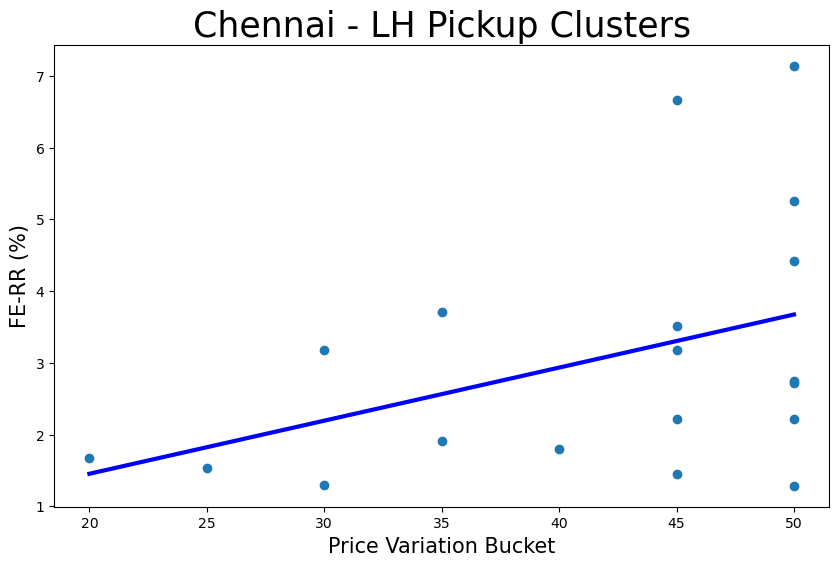

In [241]:
max_price_variation = shortlisted_routes_fare_estimates['price_variation'].astype(int).max()
max_price_variation = max_price_variation + (5 - max_price_variation % 5)
min_price_variation = shortlisted_routes_fare_estimates['price_variation'].astype(int).min()
min_price_variation = min_price_variation - (5 - abs(min_price_variation) % 5)

bin_price_variation = list(range(min_price_variation, max_price_variation + 1, 5))
bin_price_variation_label = list(range(min_price_variation, max_price_variation, 5))
shortlisted_routes_fare_estimates['price_variation_bucket'] = pd.cut(shortlisted_routes_fare_estimates[
                                                                         'price_variation'],
                                                                     bins=bin_price_variation,
                                                                     include_lowest=True,
                                                                     labels=bin_price_variation_label).astype(int)

rate_card_avg = shortlisted_routes_fare_estimates.groupby(['pickup_cluster', 'week_period','time_period']).agg(
    mean_rate_card_avg=pd.NamedAgg('price_variation', 'mean')).reset_index()

print(rate_card_avg)

#avg_ferr_calc = shortlisted_routes_fare_estimates[shortlisted_routes_fare_estimates['price_variation'] == 0]


#all_categories = shortlisted_routes_fare_estimates[['week_period','time_period']].unique()


rc_price_decrease = pd.DataFrame(columns=[
    'rc_price_decrease_pct', 'fe_rr_uplift'])

category_data = merged_fe2rr_rc_data.copy()

print(category_data)

pv_data = category_data.groupby(['week_period', 'time_period', 'price_variation_bucket']).agg(
    total_num_fe=pd.NamedAgg('fe_count', 'sum'),
    gross_converted=pd.NamedAgg('rr_count', 'sum')
).reset_index().sort_values(['total_num_fe'])

pv_data['fe_rr_ratio'] = (
        (100 * pv_data['gross_converted']) / pv_data['total_num_fe']
)

pv_data = pv_data[(pv_data['fe_rr_ratio'] != 0) & (
        pv_data['fe_rr_ratio'] != 100) & (
    pv_data['price_variation_bucket'] >= -50) & (pv_data['price_variation_bucket'] <= 50)].reset_index(drop=True)

print('Input data to the model...')

print(pv_data.shape)

pv_data = pv_data.sort_values(['price_variation_bucket']).reset_index(drop=True)
rate_card_mean = rate_card_avg['mean_rate_card_avg']
fe_rr_mean = fe_rr_avg['fe_rr_ratio']

X = pv_data['price_variation_bucket'].values
Y = pv_data['fe_rr_ratio'].values
m = len(X)
X = X.reshape((m, 1))

reg = LinearRegression()
reg = reg.fit(X, Y)
Y_pred = reg.predict(X)

X1 = [[0], [-2], [-4], [-6], [-8], [-10], [-12], [-13], [-14], [-16], [-18]]
Y1_pred = reg.predict(X1)
Y1_recommend = Y1_pred - Y1_pred[0]

get_index = list(Y1_recommend <= (required_fe_rr_uplift + 1))
max_index = 0
for idx, val in enumerate(get_index):
    if val == True:
        max_index = idx

rc_price_decrease = rc_price_decrease.append({
    'discount_percent': abs(X1[max_index][0]),
    'fe_rr_uplift': round(Y1_recommend[max_index], 2)},
    ignore_index=True)

mse_model = mse(Y, Y_pred)
rmse = np.sqrt(mse_model)
r2_score = reg.score(X, Y)

print(
    '--------------------------------------------------------------------------------------------------------')
plt.rcParams['figure.figsize'] = [10, 6]
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='blue', linewidth=3)
plt.title(city + ' - LH Pickup Clusters', fontsize=25)
plt.xlabel('Price Variation Bucket', fontsize=15)
plt.ylabel('FE-RR (%)', fontsize=15)
print('RMSE: ' + str(rmse))
print('R2_Score: ' + str(r2_score))
print('')
print('Avg FE-RR (%): ' + str(fe_rr_mean))
print('')
print('Rate Card Price Decrease Discount(%): ' + str(X1))
print('')
print('FE-RR(%): ' + str(Y1_pred))
print('')
print('Delta FE-RR(%): ' + str(Y1_recommend))
print(
    '--------------------------------------------------------------------------------------------------------')

plt.show()

In [236]:
pv_data['fe_rr_ratio'].describe()

count    19.000000
mean      3.049915
std       1.741940
min       1.285714
25%       1.735020
50%       2.722513
75%       3.606238
max       7.142857
Name: fe_rr_ratio, dtype: float64

In [237]:
pv_data = category_data.groupby(['week_period', 'time_period', 'price_variation_bucket']).agg(
    total_num_fe=pd.NamedAgg('fare_estimate_id', 'count'),
    gross_converted=pd.NamedAgg('gross_converted', 'count')
).reset_index().sort_values(['total_num_fe'])

shortlisted_routes_fare_estimates.head()

,fare_estimate_id,user_id,yyyymmdd,orderdate,quarter_hour,week_period,time_period,pickup_cluster,drop_cluster,route,...,rate_card_amount_with_surge,subtotal,amount,discount,discount_factor,surge,gross_converted,cluster_week_time,price_variation,price_variation_bucket
1910,64b77e96397c075ea547f97c,6177ace04c6ba16641df5981,20230719,2023-07-19,1130,Wednesday,morning_peak,Avadi Lake,Avadi Lake,Avadi Lake-Avadi Lake,...,30.00,41.0,31.0,10.0,24.39,5.00,1,Avadi Lake-Wednesday-morning_peak,48.78,45
1913,64b75b939497216b7da9986f,6039a65635f8d4c886d4a603,20230719,2023-07-19,0900,Wednesday,morning_peak,Avadi Lake,Kamarajapuram Ambattur,Avadi Lake-Kamarajapuram Ambattur,...,102.67,116.0,119.0,12.0,10.34,17.11,1,Avadi Lake-Wednesday-morning_peak,91.09,90
1921,64b77ca0a8f1b4a6f0694efc,63cf8966fc2b4155dfc814e2,20230719,2023-07-19,1130,Wednesday,morning_peak,Avadi Lake,New Vellanur,Avadi Lake-New Vellanur,...,112.85,126.0,104.0,22.0,17.46,18.81,1,Avadi Lake-Wednesday-morning_peak,72.10,70
1922,64b768e2bfe16e470a91cb6b,648dbf1338d482703a3db00b,20230719,2023-07-19,1000,Wednesday,morning_peak,Avadi Lake,New Vellanur,Avadi Lake-New Vellanur,...,77.50,90.0,78.0,12.0,13.33,12.92,1,Avadi Lake-Wednesday-morning_peak,72.78,70
2701,64b74d3abfe16eb72e90c62a,62c26eda522aa0c769db8a00,20230719,2023-07-19,0800,Wednesday,morning_peak,ECR Akkarai,Teynampet,ECR Akkarai-Teynampet,...,269.96,283.0,271.0,12.0,4.24,44.99,1,ECR Akkarai-Wednesday-morning_peak,91.15,90


In [242]:
shortlisted_routes_fare_estimates.pickup_cluster.nunique()

41

In [214]:
shortlisted_routes_fare_estimates.pickup_cluster.unique()

array(['Avadi Lake', 'ECR Akkarai', 'Nandhivaram Lake', 'Padur',
       'Perungalathur', 'Sithalapakkam', 'Ambattur', 'Arasankalani',
       'Avadi', 'Egattur', 'Kolappancheri', 'Kottivakkam', 'Kundrathur',
       'Panaiyur', 'Perumbakkam', 'Santoshpuram', 'Thiruneermalai',
       'Tondiarpet', 'old Washermanpet', 'Air Force Station', 'Annanur',
       'Ayapakkam 2', 'Chembarambakkam', 'Chennai International Airport',
       'Chromepet', 'Kattupakkam', 'Kattupakkam 2', 'Kondithope',
       'Korattur', 'Kotturpuram', 'Kovilambakkam', 'Pallavaram', 'Pammal',
       'RA Puram', 'Semmancheri', 'Surapet', 'Thirusulam',
       'Thiruvotriyur Theradi Metro', 'Tiruvottiyur', 'Vandalur Zoo',
       'West Tambaram'], dtype=object)

Surge percentage for shotlisted pickup cluster

In [244]:
print(city)
print(service)
print(start_date)
print(end_date)

Chennai
Link
20230710
20230723


In [312]:
surge_raw_query = """
  WITH city_cluster_hex AS (
    
        SELECT
            cch.hex_id AS hex_id,
            cch.cluster AS cluster
        FROM
            datasets.city_cluster_hex cch
        WHERE
            cch.resolution = 8
            AND cch.city = '{city}'
            AND cch.cluster IN  ('Avadi Lake', 'ECR Akkarai', 'Nandhivaram Lake', 'Padur',
                               'Perungalathur', 'Sithalapakkam', 'Ambattur', 'Arasankalani',
                               'Avadi', 'Egattur', 'Kolappancheri', 'Kottivakkam', 'Kundrathur',
                               'Panaiyur', 'Perumbakkam', 'Santoshpuram', 'Thiruneermalai',
                               'Tondiarpet', 'old Washermanpet', 'Air Force Station', 'Annanur',
                               'Ayapakkam 2', 'Chembarambakkam', 'Chennai International Airport',
                               'Chromepet', 'Kattupakkam', 'Kattupakkam 2', 'Kondithope',
                               'Korattur', 'Kotturpuram', 'Kovilambakkam', 'Pallavaram', 'Pammal',
                               'RA Puram', 'Semmancheri', 'Surapet', 'Thirusulam',
                               'Thiruvotriyur Theradi Metro', 'Tiruvottiyur', 'Vandalur Zoo',
                               'West Tambaram')
    ),
    
    fare_estimates AS (

        SELECT
            fe_ench.yyyymmdd AS yyyymmdd,
            fe_ench.city AS city_name,
            fe_ench.service_name AS service_name,
            fe_ench.service_detail_id AS service_detail_id,
            fe_ench.pickup_location_hex_8 AS pickup_location_hex_8,
            fe_ench.drop_location_hex_8 AS drop_location_hex_8,
            COALESCE(fe_ench.price_increase_strategy,'no_dynamic_surge') AS surge_strategy,
            fe_ench.fare_estimate_id AS fare_estimate_id,
            fe_ench.quarter_hour AS quarter_hour,
            CASE
            WHEN fe_ench.quarter_hour >= '0800' AND fe_ench.quarter_hour < '1100' THEN 'morning'
            WHEN fe_ench.quarter_hour >= '1100' AND fe_ench.quarter_hour < '1700' THEN 'afternoon'
            WHEN fe_ench.quarter_hour >= '1700' AND fe_ench.quarter_hour < '2100' THEN 'evening'
            ELSE 'rest' END AS timer_period

        FROM
            pricing.fare_estimates_enriched fe_ench
        WHERE
            fe_ench.yyyymmdd >= '{start_date}'
            AND fe_ench.yyyymmdd <= '{end_date}' 
            AND fe_ench.service_name = '{service}'
            AND fe_ench.city = '{city}'
    ),
    
    orders AS (
    
        SELECT
            ols.yyyymmdd AS yyyymmdd,
            ols.service_detail_id AS service_detail_id,
            ols.estimate_id AS fare_estimate_id,
            ols.order_id AS order_id,
            ols.order_status AS order_status,
            ols.spd_fraud_flag AS spd_fraud_flag
        FROM
            orders.order_logs_snapshot ols
        WHERE
            ols.yyyymmdd >= '{start_date}' 
            AND ols.yyyymmdd <= '{end_date}'
            AND ols.service_obj_service_name = '{service}'
            AND ols.city_name = '{city}'
    ),
    
    combined_df AS (
        
        SELECT 
            fe.yyyymmdd AS yyyymmdd,
            fe.city_name AS city_name,
            fe.service_name AS service_name,
            fe.service_detail_id AS service_detail_id,
            pic.cluster AS pickup_location,
            fe.pickup_location_hex_8 AS pickup_location_hex_8,
            fe.quarter_hour AS quarter_hour,
            fe.timer_period AS timer_period,
            fe.surge_strategy AS surge_strategy,
            fe.fare_estimate_id AS fare_estimate_id,
            ord.order_id,
            ord.order_status,
            ord.spd_fraud_flag
        FROM
            fare_estimates fe
        INNER JOIN
            city_cluster_hex pic
            ON fe.pickup_location_hex_8 = pic.hex_id
        LEFT JOIN
            orders ord
            ON fe.yyyymmdd = ord.yyyymmdd
            AND fe.service_detail_id = ord.service_detail_id
            AND fe.fare_estimate_id = ord.fare_estimate_id
    )
    
    SELECT * FROM combined_df
""".format(
    city = city, 
    service=service, 
    start_date = start_date, 
    end_date = end_date)

print(surge_raw_query)


  WITH city_cluster_hex AS (
    
        SELECT
            cch.hex_id AS hex_id,
            cch.cluster AS cluster
        FROM
            datasets.city_cluster_hex cch
        WHERE
            cch.resolution = 8
            AND cch.city = 'Chennai'
            AND cch.cluster IN  ('Avadi Lake', 'ECR Akkarai', 'Nandhivaram Lake', 'Padur',
                               'Perungalathur', 'Sithalapakkam', 'Ambattur', 'Arasankalani',
                               'Avadi', 'Egattur', 'Kolappancheri', 'Kottivakkam', 'Kundrathur',
                               'Panaiyur', 'Perumbakkam', 'Santoshpuram', 'Thiruneermalai',
                               'Tondiarpet', 'old Washermanpet', 'Air Force Station', 'Annanur',
                               'Ayapakkam 2', 'Chembarambakkam', 'Chennai International Airport',
                               'Chromepet', 'Kattupakkam', 'Kattupakkam 2', 'Kondithope',
                               'Korattur', 'Kotturpuram', 'Kovilambakkam', 'Pallavaram

In [313]:
surge_raw_query = pd.read_sql(surge_raw_query, conn)
surge_raw_query.head()

/var/folders/j7/5rtfb17j30s9g9q790v9nr0h0000gn/T/ipykernel_31905/2531062232.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,yyyymmdd,city_name,service_name,service_detail_id,pickup_location,pickup_location_hex_8,quarter_hour,timer_period,surge_strategy,fare_estimate_id,order_id,order_status,spd_fraud_flag
0,20230719,Chennai,Link,5bed473f1278885df4ea9d57,Kattupakkam 2,88618c4ce3fffff,1345,afternoon,no_dynamic_surge,64b79d74397c071bd348d0ee,64b792b71afcc80e044b1f96,dropped,False
1,20230718,Chennai,Link,5bed473f1278885df4ea9d57,Kattupakkam,88618c4ca1fffff,1215,afternoon,no_dynamic_surge,64b6364c4e0d68b2beae065a,64b6308bffb5ab0dfcec0289,dropped,False
2,20230713,Chennai,Link,5bed473f1278885df4ea9d57,Chembarambakkam,88618c7965fffff,2200,rest,no_dynamic_surge,64b026d52f800eccc6d7440f,None,None,None
3,20230717,Chennai,Link,5bed473f1278885df4ea9d57,Kattupakkam,88618c4ddbfffff,1730,evening,rain,64b52e984e0d687be7a8e59f,None,None,None
4,20230721,Chennai,Link,5bed473f1278885df4ea9d57,Kattupakkam 2,88618c4ce3fffff,1715,evening,no_dynamic_surge,64ba712ed82439fda45d25b1,None,None,None


In [314]:
surge_raw_query.to_csv('surge_raw_query_chennai_link.csv', index= False)

In [322]:
surge_raw_query = pd.read_csv('surge_raw_query_chennai_link.csv')

In [323]:
surge_raw_query.head()

,yyyymmdd,city_name,service_name,service_detail_id,pickup_location,pickup_location_hex_8,quarter_hour,timer_period,surge_strategy,fare_estimate_id,order_id,order_status,spd_fraud_flag
0,20230719,Chennai,Link,5bed473f1278885df4ea9d57,Kattupakkam 2,88618c4ce3fffff,1345,afternoon,no_dynamic_surge,64b79d74397c071bd348d0ee,64b792b71afcc80e044b1f96,dropped,False
1,20230718,Chennai,Link,5bed473f1278885df4ea9d57,Kattupakkam,88618c4ca1fffff,1215,afternoon,no_dynamic_surge,64b6364c4e0d68b2beae065a,64b6308bffb5ab0dfcec0289,dropped,False
2,20230713,Chennai,Link,5bed473f1278885df4ea9d57,Chembarambakkam,88618c7965fffff,2200,rest,no_dynamic_surge,64b026d52f800eccc6d7440f,NaN,NaN,NaN
3,20230717,Chennai,Link,5bed473f1278885df4ea9d57,Kattupakkam,88618c4ddbfffff,1730,evening,rain,64b52e984e0d687be7a8e59f,NaN,NaN,NaN
4,20230721,Chennai,Link,5bed473f1278885df4ea9d57,Kattupakkam 2,88618c4ce3fffff,1715,evening,no_dynamic_surge,64ba712ed82439fda45d25b1,NaN,NaN,NaN


In [324]:
surge_raw_query.columns

Index(['yyyymmdd', 'city_name', 'service_name', 'service_detail_id',
       'pickup_location', 'pickup_location_hex_8', 'quarter_hour',
       'timer_period', 'surge_strategy', 'fare_estimate_id', 'order_id',
       'order_status', 'spd_fraud_flag'],
      dtype='object')

In [333]:
## New columns
surge_raw_query['fe'] = np.where((surge_raw_query['fare_estimate_id'].notnull()), 
                                      surge_raw_query['fare_estimate_id'], None)
surge_raw_query['surged_fe'] = np.where((surge_raw_query['surge_strategy'] != 'no_dynamic_surge'), 
                                        surge_raw_query['fare_estimate_id'], None)
surge_raw_query['mismatch_fe'] = np.where((surge_raw_query['surge_strategy'] == 'mismatch'), 
                                          surge_raw_query['fare_estimate_id'], None)
surge_raw_query['hot_cold_surge_fe'] = np.where((surge_raw_query['surge_strategy'] == 'hot_cold_surge'), 
                                                surge_raw_query['fare_estimate_id'], None)
surge_raw_query['sdr_fe'] = np.where((surge_raw_query['surge_strategy'] == 'surge_dashboard_rule'), 
                                                      surge_raw_query['fare_estimate_id'], None)
surge_raw_query['circuit_broken_fe'] = np.where((surge_raw_query['surge_strategy'] == 'circuit_broken'), 
                                                surge_raw_query['fare_estimate_id'], None)
surge_raw_query['rain_fe'] = np.where((surge_raw_query['surge_strategy'] == 'rain'), 
                                      surge_raw_query['fare_estimate_id'], None)
surge_raw_query['gross_orders'] = np.where((surge_raw_query['order_id'].notnull()), 
                                      surge_raw_query['order_id'], None)
surge_raw_query['net_orders'] = np.where((surge_raw_query['order_status'] == 'dropped') & (surge_raw_query['spd_fraud_flag'] != True), 
                                      surge_raw_query['order_id'], None)
surge_raw_query['surged_net_orders'] = np.where((surge_raw_query['surge_strategy'] != 'no_dynamic_surge') & 
                                                (surge_raw_query['order_status'] == 'dropped') & 
                                                (surge_raw_query['spd_fraud_flag'] != True), 
                                      surge_raw_query['order_id'], None)

In [334]:
surge_raw_query.columns

Index(['yyyymmdd', 'city_name', 'service_name', 'service_detail_id',
       'pickup_location', 'pickup_location_hex_8', 'quarter_hour',
       'timer_period', 'surge_strategy', 'fare_estimate_id', 'order_id',
       'order_status', 'spd_fraud_flag', 'surged_fe', 'mismatch_fe',
       'hot_cold_surge_fe', 'sdr_fe', 'circuit_broken_fe', 'rain_fe',
       'net_orders', 'surged_net_orders', 'gross_orders', 'fe'],
      dtype='object')

In [351]:
df_surged = surge_raw_query \
                .groupby(['pickup_location']) \
                .agg({
                        'fe' : 'nunique',
                        'surged_fe' : 'nunique',
                        'gross_orders' : 'nunique',
                        'net_orders' : 'nunique',
                        'surged_net_orders' : 'nunique',
                        'mismatch_fe' : 'nunique',
                        'hot_cold_surge_fe' : 'nunique',
                        'sdr_fe' : 'nunique',
                        'circuit_broken_fe' : 'nunique',
                        'rain_fe' : 'nunique',

                    }) \
                .reset_index()
df_surged['surged_fe_%'] = round(df_surged['surged_fe']*100.0/df_surged['fe'],2)
df_surged['fe_rr'] = round(df_surged['gross_orders']*100.0/df_surged['fe'],2)
df_surged['g2n'] = round(df_surged['net_orders']*100.0/df_surged['gross_orders'],2)
df_surged['fe_net'] = round(df_surged['net_orders']*100.0/df_surged['fe'],2)
df_surged['surged_net_%'] = round(df_surged['surged_net_orders']*100.0/df_surged['net_orders'],2)
df_surged = df_surged[['pickup_location', 'fe', 'surged_fe', 'surged_fe_%', 'gross_orders', 'net_orders', 
                       'fe_rr', 'g2n', 'fe_net', 'surged_net_%',
                       'surged_net_orders', 'mismatch_fe', 'hot_cold_surge_fe', 'sdr_fe',
                       'circuit_broken_fe', 'rain_fe']]
df_surged

,pickup_location,fe,surged_fe,surged_fe_%,gross_orders,net_orders,fe_rr,g2n,fe_net,surged_net_%,surged_net_orders,mismatch_fe,hot_cold_surge_fe,sdr_fe,circuit_broken_fe,rain_fe
0,Air Force Station,43656,10445,23.93,8846,6148,20.26,69.50,14.08,18.69,1149,2493,2791,0,616,4545
1,Ambattur,42117,9275,22.02,8874,6202,21.07,69.89,14.73,16.74,1038,1422,1647,0,276,5930
2,Annanur,20524,2687,13.09,3518,1940,17.14,55.14,9.45,9.74,189,1,340,0,104,2242
3,Arasankalani,13644,1770,12.97,2644,1433,19.38,54.20,10.50,11.51,165,0,487,0,83,1200
4,Avadi,9396,1365,14.53,1312,615,13.96,46.88,6.55,13.33,82,0,179,0,49,1137
5,Avadi Lake,20663,3086,14.93,4055,2323,19.62,57.29,11.24,10.98,255,0,550,0,80,2456
6,Ayapakkam 2,13943,1708,12.25,2856,1821,20.48,63.76,13.06,13.07,238,0,459,0,26,1223
7,Chembarambakkam,7727,849,10.99,1035,460,13.39,44.44,5.95,11.96,55,0,24,0,7,818
8,Chennai International Airport,31691,3182,10.04,5444,3657,17.18,67.17,11.54,9.05,331,2,783,0,140,2257
9,Chromepet,89263,24445,27.39,19003,12904,21.29,67.91,14.46,22.60,2916,9069,3437,0,571,11368


In [352]:
df_surged.to_clipboard(index=False)

In [347]:
df_surged[['surged_fe_%', 'surged_net_%']].describe()

,surged_fe_%,surged_net_%
count,41.000000,41.000000
mean,18.189512,15.672195
std,8.294650,6.645594
min,7.050000,7.160000
25%,12.110000,10.210000
50%,17.170000,14.770000
75%,23.560000,19.570000
max,45.890000,37.210000


In [350]:
df_surged_tp = surge_raw_query \
                .groupby(['pickup_location', 'timer_period']) \
                .agg({
                        'fe' : 'nunique',
                        'surged_fe' : 'nunique',
                        'gross_orders' : 'nunique',
                        'net_orders' : 'nunique',
                        'surged_net_orders' : 'nunique',
                        'mismatch_fe' : 'nunique',
                        'hot_cold_surge_fe' : 'nunique',
                        'sdr_fe' : 'nunique',
                        'circuit_broken_fe' : 'nunique',
                        'rain_fe' : 'nunique',

                    }) \
                .reset_index()
df_surged_tp['surged_fe_%'] = round(df_surged_tp['surged_fe']*100.0/df_surged_tp['fe'],2)
df_surged_tp['fe_rr'] = round(df_surged_tp['gross_orders']*100.0/df_surged_tp['fe'],2)
df_surged_tp['g2n'] = round(df_surged_tp['net_orders']*100.0/df_surged_tp['gross_orders'],2)
df_surged_tp['fe_net'] = round(df_surged_tp['net_orders']*100.0/df_surged_tp['fe'],2)
df_surged_tp['surged_net_%'] = round(df_surged_tp['surged_net_orders']*100.0/df_surged_tp['net_orders'],2)
df_surged_tp = df_surged_tp[['pickup_location', 'timer_period', 'fe', 'surged_fe', 'surged_fe_%', 'gross_orders', 'net_orders', 
                           'fe_rr', 'g2n', 'fe_net', 'surged_net_%',
                           'surged_net_orders', 'mismatch_fe', 'hot_cold_surge_fe', 'sdr_fe',
                           'circuit_broken_fe', 'rain_fe']]

In [353]:
df_surged_tp.to_clipboard(index=False)

In [355]:
df_surged_overall = surge_raw_query \
                .groupby(['city_name']) \
                .agg({
                        'fe' : 'nunique',
                        'surged_fe' : 'nunique',
                        'gross_orders' : 'nunique',
                        'net_orders' : 'nunique',
                        'surged_net_orders' : 'nunique',
                        'mismatch_fe' : 'nunique',
                        'hot_cold_surge_fe' : 'nunique',
                        'sdr_fe' : 'nunique',
                        'circuit_broken_fe' : 'nunique',
                        'rain_fe' : 'nunique',

                    }) \
                .reset_index()
df_surged_overall['surged_fe_%'] = round(df_surged_overall['surged_fe']*100.0/df_surged_overall['fe'],2)
df_surged_overall['fe_rr'] = round(df_surged_overall['gross_orders']*100.0/df_surged_overall['fe'],2)
df_surged_overall['g2n'] = round(df_surged_overall['net_orders']*100.0/df_surged_overall['gross_orders'],2)
df_surged_overall['fe_net'] = round(df_surged_overall['net_orders']*100.0/df_surged_overall['fe'],2)
df_surged_overall['surged_net_%'] = round(df_surged_overall['surged_net_orders']*100.0/df_surged_overall['net_orders'],2)
df_surged_overall = df_surged_overall[['city_name', 'fe', 'surged_fe', 'surged_fe_%', 'gross_orders', 'net_orders', 
                           'fe_rr', 'g2n', 'fe_net', 'surged_net_%',
                           'surged_net_orders', 'mismatch_fe', 'hot_cold_surge_fe', 'sdr_fe',
                           'circuit_broken_fe', 'rain_fe']]
df_surged_overall

,city_name,fe,surged_fe,surged_fe_%,gross_orders,net_orders,fe_rr,g2n,fe_net,surged_net_%,surged_net_orders,mismatch_fe,hot_cold_surge_fe,sdr_fe,circuit_broken_fe,rain_fe
0,Chennai,946600,195255,20.63,182889,112396,19.32,61.46,11.87,17.72,19916,42641,35672,0,6339,110603
